# Analysis of iModulons from scale-down experiments with substrate and/or oxygen oscillations

In [1]:
from pymodulon.core import IcaData
from pymodulon import example_data
from pymodulon.io import save_to_json, load_json_model
from pymodulon.example_data import load_ecoli_data
from pymodulon.plotting import *
import pymodulon
from pymodulon.enrichment import *

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Patch
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

from matplotlib_venn import venn2

In [3]:
# Loading it again (if resuming work)
ica_data_p1k = load_json_model("../data/ica_data/ecoli_p1k.json")
ica_data_p1k_with_ddb = load_json_model("../data/ica_data/ecoli_p1k_with_additional_ddb.json")

In [4]:
from matplotlib_venn import venn2

## Selecting high-cell-density samples

In [5]:
ica_data_p1k_with_ddb.sample_table.project.unique()

array(['control', 'fur', 'acid', 'oxidative', 'nac_ntrc', 'misc', 'omics',
       'ompr', 'minspan', 'cra_crp', 'rpoB', 'crp', 'glu', '42c', 'ssw',
       'ica', 'ytf', 'fps', 'pal', 'efeU', 'misc2', 'nquinone', 'quinone',
       'oxyR', 'svns_pgi', 'abx_media', 'hot_tale', 'pdhr_ale', 'tcs',
       'ros_tale', 'pcoli', 'cck', 'cck_pgi', 'cck_sdh', 'cck_pts',
       'cck_gnd', 'cck_tpiA', 'acid_tale', 'adnB', 'ytf2', 'ytf3',
       'minicoli', 'eep', 'DDB2', 'DDB3', 'ddb_pd_036', 'ddb_pd_065',
       'ddb_ff_sd'], dtype=object)

In [6]:
hcd_sample_table = ica_data_p1k_with_ddb.sample_table[
    (ica_data_p1k_with_ddb.sample_table.project == "DDB2") |
    (ica_data_p1k_with_ddb.sample_table.project == "DDB3") |
    (ica_data_p1k_with_ddb.sample_table.project == "ddb_pd_036") |
    (ica_data_p1k_with_ddb.sample_table.project == "ddb_pd_065") |
    (ica_data_p1k_with_ddb.sample_table.project == "ddb_ff_sd")
]

hcd_sample_table["Strain Description"] = hcd_sample_table["Strain Description"].str.replace("_","-")
hcd_sample_table["Strain Description"] = hcd_sample_table["Strain Description"].str.replace("K-12 BW25113 del-fhuA", "BW25113")

In [7]:
hcd_sample_table["Strain Description"]

DDB2__PD-005_BW25113_Batch_6h__1                 Escherichia coli BW25113
DDB2__PD-005_BW25113_Batch_6h__2                 Escherichia coli BW25113
DDB2__PD-003_BW25113_Batch_9h__1                 Escherichia coli BW25113
DDB2__PD-003_BW25113_Batch_9h__2                 Escherichia coli BW25113
DDB2__PD-003_BW25113_Fed-batch_6h__1             Escherichia coli BW25113
                                                      ...                
PD_123_R11_S05#                         Escherichia coli BW25113 del-rpoS
PD_123_R13_S05#                         Escherichia coli BW25113 del-fliA
PD_123_R5_S05#1                                  Escherichia coli BW25113
PD_123_R7_S05#1                         Escherichia coli BW25113 del-prpR
PD_123_R9_S05#1                          Escherichia coli BW25113 del-cra
Name: Strain Description, Length: 190, dtype: object

In [8]:
hcd_sample_table[["Growth Rate (1/hr)", "Strain Description"]].to_excel("hcd_sample_table.xlsx")

In [9]:
len(hcd_sample_table[hcd_sample_table["project"] == "ddb_ff_sd"])

23

In [10]:
len(hcd_sample_table["Strain Description"].unique())

26

### Prepare data for PCA

In [11]:
# hcd_sample_table.to_csv("metadata_for_PCA.csv")

In [12]:
# ica_data_p1k_with_ddb.X[hcd_sample_table.index].to_csv("log_tpm_norm_for_PCA.csv")

### Plot PCA

In [13]:
rotated = pd.read_csv("R/log_tpm_PCA_rotated.csv", index_col=0)
loadings = pd.read_csv("R/log_tpm_PCA_loadings.csv", index_col=0)
metadata = pd.read_csv("R/metadata_for_PCA.csv", index_col=0)
variances = pd.read_csv("R/log_tpm_PCA_variances.csv", index_col=0)

data = pd.concat([rotated, metadata], axis=1)
metadata.columns

Index(['project', 'Strain Type', 'Strain Description', 'Short_genotype',
       'Culture Type', 'Media version', 'Growth Rate (1/hr)', 'mu_set'],
      dtype='object')

In [14]:
np.round(variances.loc["PC1"].values[0],1)

25.3

In [15]:
data['Strain Type'].unique()

array(['WT', 'TF KO', 'TPS'], dtype=object)

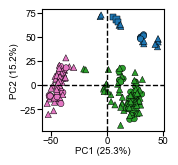

In [16]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5

fig = plt.figure()
spec = fig.add_gridspec(nrows=1, ncols=1)

# frame = fig.add_subplot(spec[:,:])
ax1 = fig.add_subplot(spec[:,:])

sns.scatterplot(
    data=data,
    x="rotated.PC1", 
    y="rotated.PC2",
    hue="mu_set",
    hue_order=["0.11","0.05","none"],
    style="Strain Type",
    style_order=['WT', 'TF KO', 'TPS'],
    markers=["o","^","s"],
    palette=["tab:green", "tab:blue", "tab:pink"],
    edgecolor="k",
    ax=ax1,
    s=20
)

ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])

ax1.hlines(y=0,xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linewidths=1, colors="k", linestyle="--")
ax1.vlines(x=0,ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linewidths=1, colors="k", linestyle="--")

ax1.set_xlabel("PC1 ("+str(np.round(variances.loc["PC1"].values[0],1))+"%)")
ax1.set_ylabel("PC2 ("+str(np.round(variances.loc["PC2"].values[0],1))+"%)")

ax1.get_legend().remove()

w=40/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

# plt.savefig("PCA.svg", dpi=900);

### Data Source

In [17]:
all_names = set(ica_data_p1k_with_ddb.sample_names)
p1k_names = set(ica_data_p1k.sample_names)
hcd_names = set(hcd_sample_table.index)

In [18]:
len(all_names)

1103

In [19]:
len(p1k_names)

1035

In [20]:
len(all_names-p1k_names)

68

In [21]:
ddb_metadata = metadata[(metadata.project == "DDB2") | (metadata.project == "DDB3")]

In [22]:
len(ddb_metadata)

122

In [23]:
ddb_metadata["Media version"].unique()

array([1], dtype=int64)

In [24]:
new_metadata = metadata[(metadata.project != "DDB2") & (metadata.project != "DDB3")]

In [25]:
len(new_metadata)

68

In [26]:
len(new_metadata[new_metadata["Media version"] == 1])

22

In [27]:
len(new_metadata[new_metadata["Media version"] != 1])

46

In [28]:
# new_metadata.to_excel("RNA-seq_data_availability.xlsx")

In [29]:
# metadata.to_excel("RNA-seq_data_availability.xlsx")

### Phase planes

In [30]:
A_df = ica_data_p1k_with_ddb.A.loc[["FliA", "FlhDC-2", "Crp-1", "Acetate", "ppGpp", "Translation", "Fur-1", "Zinc-1", "Zinc-2"]].T
A_df = pd.concat([A_df,metadata],axis=1).dropna()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


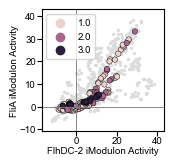

In [31]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5

fig = plt.figure()
spec = fig.add_gridspec(nrows=1, ncols=1)

# frame = fig.add_subplot(spec[:,:])
ax1 = fig.add_subplot(spec[:,:])

imodulon_2 = "FliA"
imodulon_1 = "FlhDC-2"

compare_activities(ica_data_p1k,imodulon_1,imodulon_2, ax=ax1, scatter_kwargs={"s":2}, groups=None,colors="gainsboro", fit_metric=None)

sns.scatterplot(
    data=A_df,
    x=imodulon_1, 
    y=imodulon_2,
    hue="Media version",
    # hue_order=["0.11","0.05","none"],
    # style="Strain Type",
    # style_order=['WT', 'TF KO', 'TPS'],
    # markers=["o","^","s"],
    # palette=["tab:green", "tab:blue", "tab:pink"],
    edgecolor="k",
    ax=ax1,
    s=15
)

compare_activities(ica_data_p1k,imodulon_1, imodulon_2, ax=ax1, scatter_kwargs={"s":0}, groups=None,colors="gainsboro", fit_metric=None)

# ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
# ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])

# ax1.hlines(y=0,xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linewidths=1, colors="k", linestyle="--")
# ax1.vlines(x=0,ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linewidths=1, colors="k", linestyle="--")

# ax1.get_legend().remove()

w=40/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

# plt.savefig("FliA_FlhDC-2_phaseplane.svg", dpi=900)

In [32]:
A_df = ica_data_p1k_with_ddb.A.loc[["FliA", "FlhDC-2", "Crp-1", "Acetate", "ppGpp", "Translation", "Fur-1", "Zinc-1", "Zinc-2"]].T
A_df = pd.concat([A_df,metadata],axis=1).dropna()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


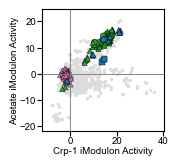

In [33]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5

fig = plt.figure()
spec = fig.add_gridspec(nrows=1, ncols=1)

# frame = fig.add_subplot(spec[:,:])
ax1 = fig.add_subplot(spec[:,:])

imodulon_2 = "Acetate"
imodulon_1 = "Crp-1"

compare_activities(ica_data_p1k,imodulon_1,imodulon_2, ax=ax1, scatter_kwargs={"s":2}, groups=None,colors="gainsboro", fit_metric=None)

sns.scatterplot(
    data=A_df,
    x=imodulon_1, 
    y=imodulon_2,
    hue="mu_set",
    hue_order=["0.11","0.05","none"],
    style="Strain Type",
    style_order=['WT', 'TF KO', 'TPS'],
    markers=["o","^","s"],
    palette=["tab:green", "tab:blue", "tab:pink"],
    edgecolor="k",
    ax=ax1,
    s=15
)

compare_activities(ica_data_p1k,imodulon_1, imodulon_2, ax=ax1, scatter_kwargs={"s":0}, groups=None,colors="gainsboro", fit_metric=None)

# ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
# ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])

# ax1.hlines(y=0,xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linewidths=1, colors="k", linestyle="--")
# ax1.vlines(x=0,ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linewidths=1, colors="k", linestyle="--")

ax1.get_legend().remove()

w=40/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

# plt.savefig("Crp-1_Acetate_phaseplane.svg", dpi=900)

In [34]:
A_df = A_df[A_df["mu_set"] != "none"]
A_df = A_df[A_df["Acetate"] < 0]
A_df = A_df[A_df["Crp-1"] < 0]
A_df

FliA   FlhDC-2     Crp-1  \
DDB3__PD-006_del-baeR_Fed-batch_12h__1  2.104100 -3.731375 -2.030720   
DDB3__PD-006_del-baeR_Fed-batch_12h__2  1.167090 -6.126496 -3.293041   
PD_121_R15_S05#                         0.469183 -6.668586 -1.452803   
PD_122_R15_S05#                         0.184419 -6.618233 -1.279925   

                                         Acetate      ppGpp  Translation  \
DDB3__PD-006_del-baeR_Fed-batch_12h__1 -5.077939 -12.112118    -6.203455   
DDB3__PD-006_del-baeR_Fed-batch_12h__2 -5.759539 -11.898989    -6.850504   
PD_121_R15_S05#                        -2.898199  -8.251350    -6.459737   
PD_122_R15_S05#                        -2.509510  -8.005840    -6.924444   

                                           Fur-1     Zinc-1    Zinc-2  \
DDB3__PD-006_del-baeR_Fed-batch_12h__1  0.842692  20.326381  2.627139   
DDB3__PD-006_del-baeR_Fed-batch_12h__2  0.875455  20.729958  3.708829   
PD_121_R15_S05#                         0.511824   7.729079  2.115078   
PD_122_R15_S05#                         0.077787   8.183168  2.364077   

                                          project Strain Type  \
DDB3__PD-006_del-baeR_Fed-batch_12h__1       DDB3       TF KO   
DDB3__PD-006_del-baeR_Fed-batch_12h__2       DDB3       TF KO   
PD_121_R15_S05#                         ddb_ff_sd       TF KO   
PD_122_R15_S05#                         ddb_ff_sd       TF KO   

                                                       Strain Description  \
DDB3__PD-006_del-baeR_Fed-batch_12h__1  Escherichia coli BW25113 del-baeR   
DDB3__PD-006_del-baeR_Fed-batch_12h__2  Escherichia coli BW25113 del-baeR   
PD_121_R15_S05#                          Escherichia coli BW25113 del-crp   
PD_122_R15_S05#                          Escherichia coli BW25113 del-crp   

                                          Short_genotype Culture Type  \
DDB3__PD-006_del-baeR_Fed-batch_12h__1  BW25113 del-baeR    Fed-batch   
DDB3__PD-006_del-baeR_Fed-batch_12h__2  BW25113 del-baeR    Fed-batch   
PD_121_R15_S05#                          BW25113 del-crp    Fed-batch   
PD_122_R15_S05#                          BW25113 del-crp    Fed-batch   

                                        Media version Growth Rate (1/hr)  \
DDB3__PD-006_del-baeR_Fed-batch_12h__1            1.0               0.11   
DDB3__PD-006_del-baeR_Fed-batch_12h__2            1.0               0.11   
PD_121_R15_S05#                                   3.0               0.05   
PD_122_R15_S05#                                   3.0               0.05   

                                       mu_set  
DDB3__PD-006_del-baeR_Fed-batch_12h__1   0.11  
DDB3__PD-006_del-baeR_Fed-batch_12h__2   0.11  
PD_121_R15_S05#                          0.05  
PD_122_R15_S05#                          0.05

In [35]:
A_df = ica_data_p1k_with_ddb.A.loc[["FliA", "FlhDC-2", "Crp-1", "Acetate", "ppGpp", "Translation", "Fur-1", "Zinc-1", "Zinc-2"]].T
A_df = pd.concat([A_df,metadata],axis=1).dropna()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


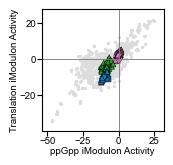

In [36]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5

fig = plt.figure()
spec = fig.add_gridspec(nrows=1, ncols=1)

# frame = fig.add_subplot(spec[:,:])
ax1 = fig.add_subplot(spec[:,:])

imodulon_2 = "Translation"
imodulon_1 = "ppGpp"

compare_activities(ica_data_p1k,imodulon_1,imodulon_2, ax=ax1, scatter_kwargs={"s":2}, groups=None,colors="gainsboro", fit_metric=None)

sns.scatterplot(
    data=A_df,
    x=imodulon_1, 
    y=imodulon_2,
    hue="mu_set",
    hue_order=["0.11","0.05","none"],
    style="Strain Type",
    style_order=['WT', 'TF KO', 'TPS'],
    markers=["o","^","s"],
    palette=["tab:green", "tab:blue", "tab:pink"],
    edgecolor="k",
    ax=ax1,
    s=15
)

compare_activities(ica_data_p1k,imodulon_1, imodulon_2, ax=ax1, scatter_kwargs={"s":0}, groups=None,colors="gainsboro", fit_metric=None)

# ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
# ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])

# ax1.hlines(y=0,xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linewidths=1, colors="k", linestyle="--")
# ax1.vlines(x=0,ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linewidths=1, colors="k", linestyle="--")

ax1.get_legend().remove()

w=40/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

# plt.savefig("ppGpp_Translation_phaseplane.svg", dpi=900)

In [37]:
A_df[A_df["Short_genotype"].str.contains("zur")]

FliA   FlhDC-2      Crp-1    Acetate     ppGpp  Translation  \
DDB_0238 -1.350074 -0.259729  -2.625565  -1.064867  0.833716     2.365454   
DDB_0239  0.006806 -1.439588  11.701306  11.363214 -6.876129    -3.086986   
DDB_0240 -0.596479 -2.653044  10.832125  11.295157 -7.748309    -2.203364   
DDB_0245 -1.912448 -1.739384  -2.672565  -0.424803  1.918548     3.991209   
DDB_0246 -0.980448 -0.300871  -2.257822  -0.422013  1.382947     3.668369   
DDB_0247 -0.876341 -3.687632   8.504606   8.792579 -8.533152    -3.229549   
DDB_0248  1.917492  3.315736  10.598879  11.177529 -7.965922    -2.336056   
DDB_0253 -0.433379 -2.214972  -2.489337  -1.707985  0.532555     2.682401   
DDB_0254 -1.677417 -2.692776  -2.809554  -1.046917  0.826825     3.766775   
DDB_0255 -1.168798 -4.499233   9.829763  12.004503 -7.203050    -1.518393   

              Fur-1     Zinc-1    Zinc-2     project Strain Type  \
DDB_0238  -2.133612   3.625736 -2.422616  ddb_pd_036       TF KO   
DDB_0239  10.846942  18.945117 -0.585820  ddb_pd_036       TF KO   
DDB_0240  12.565864  18.799466 -0.318261  ddb_pd_036       TF KO   
DDB_0245  -1.265684   2.274255 -2.780382  ddb_pd_036       TF KO   
DDB_0246  -1.810331   2.879120 -2.475226  ddb_pd_036       TF KO   
DDB_0247  -0.193904  16.981929  0.733999  ddb_pd_036       TF KO   
DDB_0248   9.737559  16.043602 -0.679892  ddb_pd_036       TF KO   
DDB_0253  -2.169148  12.060233 -0.673905  ddb_pd_036       TF KO   
DDB_0254  -1.763828  13.876626 -0.800343  ddb_pd_036       TF KO   
DDB_0255  -1.554596  19.266208 -2.026041  ddb_pd_036       TF KO   

                        Strain Description   Short_genotype Culture Type  \
DDB_0238  Escherichia coli BW25113 del-zur  BW25113 del-zur        Batch   
DDB_0239  Escherichia coli BW25113 del-zur  BW25113 del-zur    Fed-batch   
DDB_0240  Escherichia coli BW25113 del-zur  BW25113 del-zur    Fed-batch   
DDB_0245  Escherichia coli BW25113 del-zur  BW25113 del-zur        Batch   
DDB_0246  Escherichia coli BW25113 del-zur  BW25113 del-zur        Batch   
DDB_0247  Escherichia coli BW25113 del-zur  BW25113 del-zur    Fed-batch   
DDB_0248  Escherichia coli BW25113 del-zur  BW25113 del-zur    Fed-batch   
DDB_0253  Escherichia coli BW25113 del-zur  BW25113 del-zur        Batch   
DDB_0254  Escherichia coli BW25113 del-zur  BW25113 del-zur        Batch   
DDB_0255  Escherichia coli BW25113 del-zur  BW25113 del-zur    Fed-batch   

          Media version Growth Rate (1/hr) mu_set  
DDB_0238            1.0              0.543   none  
DDB_0239            1.0              0.109   0.11  
DDB_0240            1.0              0.119   0.11  
DDB_0245            1.0                max   none  
DDB_0246            1.0                max   none  
DDB_0247            1.0              0.104   0.11  
DDB_0248            1.0              0.108   0.11  
DDB_0253            1.0                max   none  
DDB_0254            1.0                max   none  
DDB_0255            1.0              0.114   0.11

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


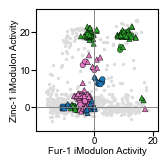

In [38]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5

fig = plt.figure()
spec = fig.add_gridspec(nrows=1, ncols=1)

# frame = fig.add_subplot(spec[:,:])
ax1 = fig.add_subplot(spec[:,:])

imodulon_2 = "Zinc-1"
imodulon_1 = "Fur-1"

compare_activities(ica_data_p1k,imodulon_1,imodulon_2, ax=ax1, scatter_kwargs={"s":2}, groups=None,colors="gainsboro", fit_metric=None)

sns.scatterplot(
    data=A_df,
    x=imodulon_1, 
    y=imodulon_2,
    hue="mu_set",
    hue_order=["0.11","0.05","none"],
    style="Strain Type",
    style_order=['WT', 'TF KO', 'TPS'],
    markers=["o","^","s"],
    palette=["tab:green", "tab:blue", "tab:pink"],
    edgecolor="k",
    ax=ax1,
    s=15
)

compare_activities(ica_data_p1k,imodulon_1, imodulon_2, ax=ax1, scatter_kwargs={"s":0}, groups=None,colors="gainsboro", fit_metric=None)

fur_lower = ax1.get_xlim()[0]
fur_upper = ax1.get_xlim()[1]
zinc_lower = ax1.get_ylim()[0]
zinc_upper = ax1.get_ylim()[1]

# ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
# ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])

# ax1.hlines(y=0,xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linewidths=1, colors="k", linestyle="--")
# ax1.vlines(x=0,ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linewidths=1, colors="k", linestyle="--")

ax1.get_legend().remove()

w=40/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

# plt.savefig("Fur-1_Zinc-1_phaseplane.svg", dpi=900)

### Motility boxplots

In [39]:
A_df = ica_data_p1k_with_ddb.A.loc[["FliA", "FlhDC-2", "Crp-1", "Acetate", "ppGpp", "Translation", "Fur-1", "Zinc-1"]].T
A_df = pd.concat([A_df,metadata],axis=1).dropna()

In [40]:
A_df["Short_genotype"]

DDB2__PD-005_BW25113_Batch_6h__1                 BW25113
DDB2__PD-005_BW25113_Batch_6h__2                 BW25113
DDB2__PD-003_BW25113_Batch_9h__1                 BW25113
DDB2__PD-003_BW25113_Batch_9h__2                 BW25113
DDB2__PD-003_BW25113_Fed-batch_6h__1             BW25113
                                              ...       
PD_123_R11_S05#                         BW25113 del-rpoS
PD_123_R13_S05#                         BW25113 del-fliA
PD_123_R5_S05#1                                  BW25113
PD_123_R7_S05#1                         BW25113 del-prpR
PD_123_R9_S05#1                          BW25113 del-cra
Name: Short_genotype, Length: 190, dtype: object

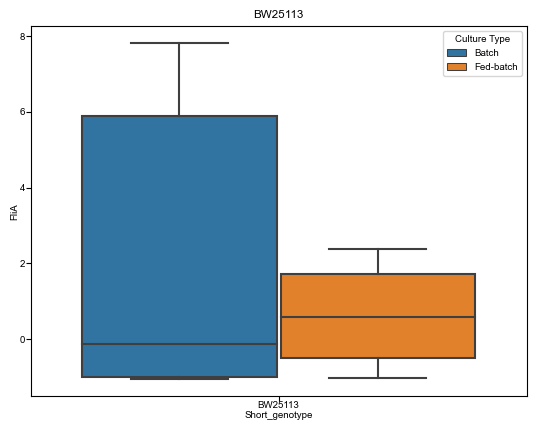

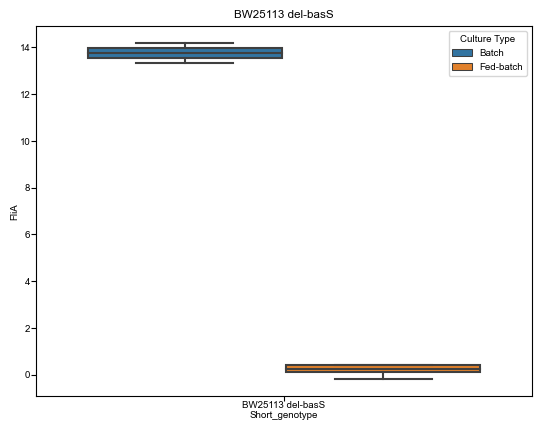

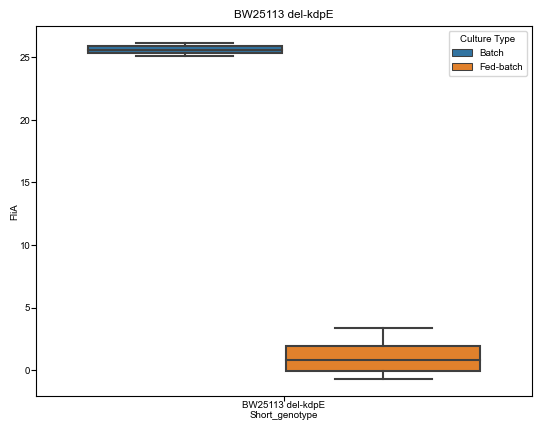

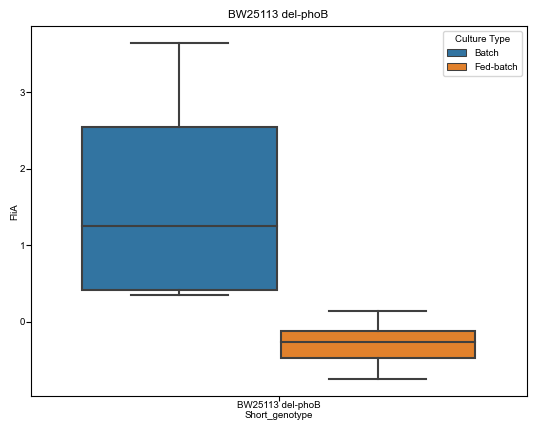

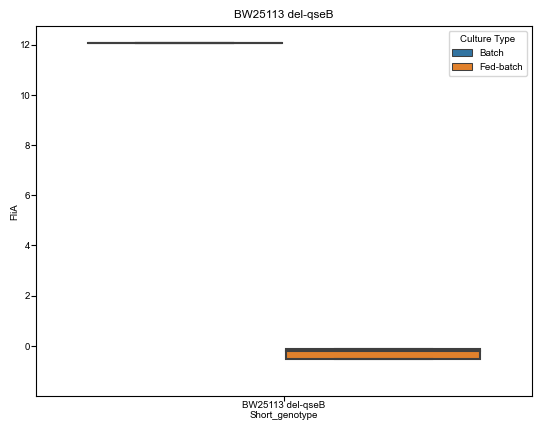

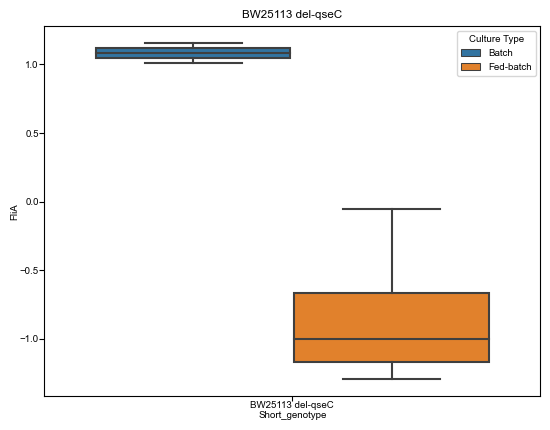

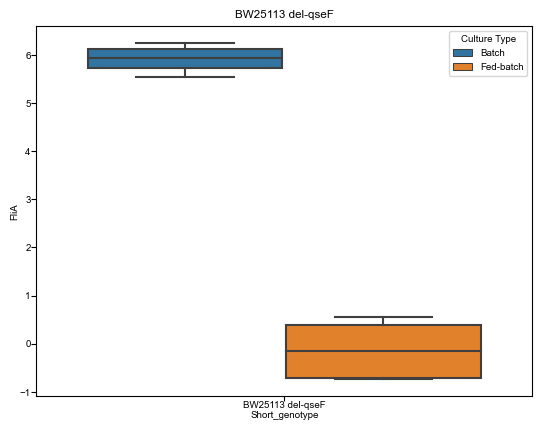

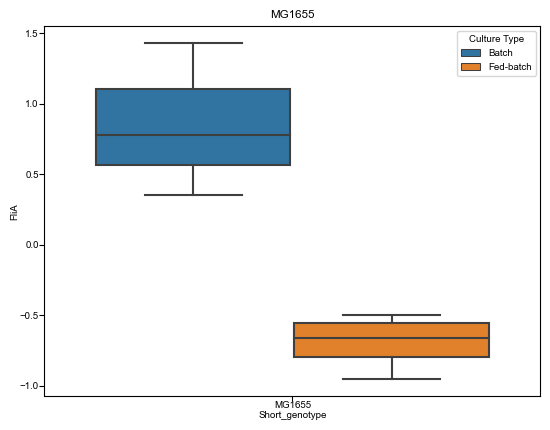

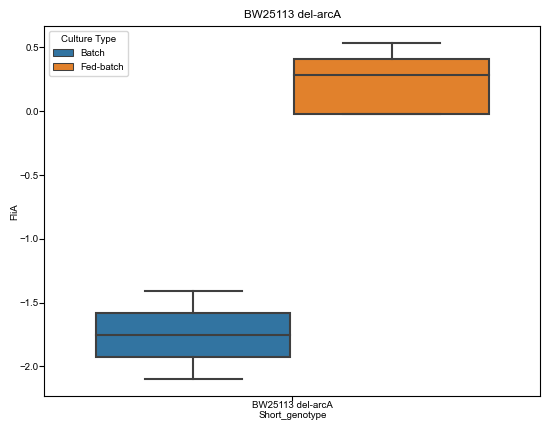

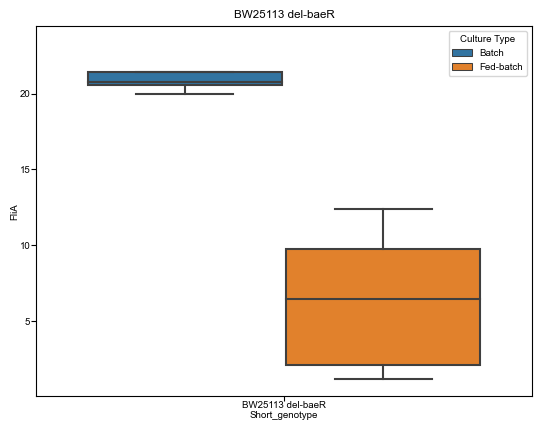

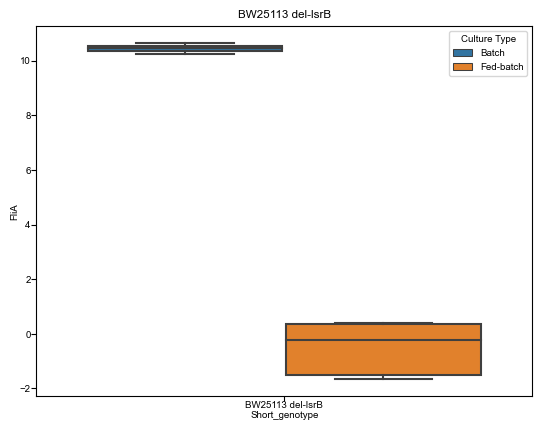

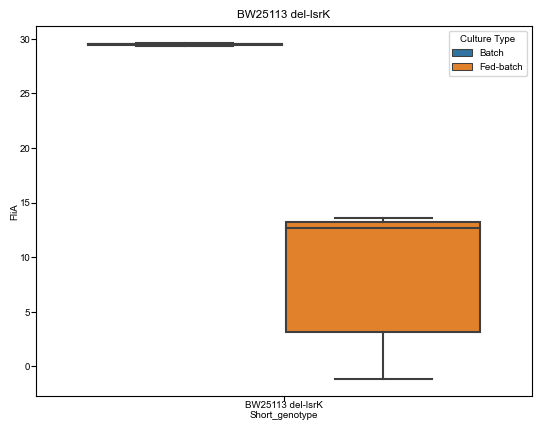

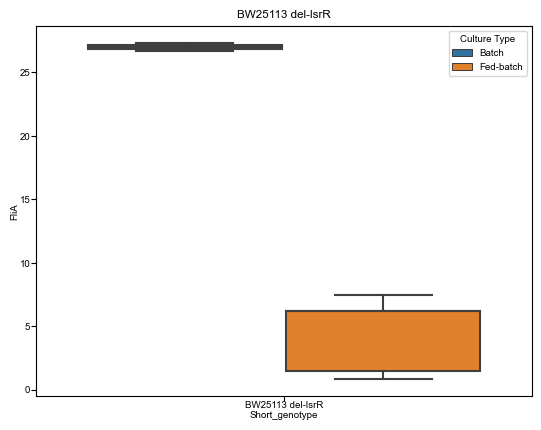

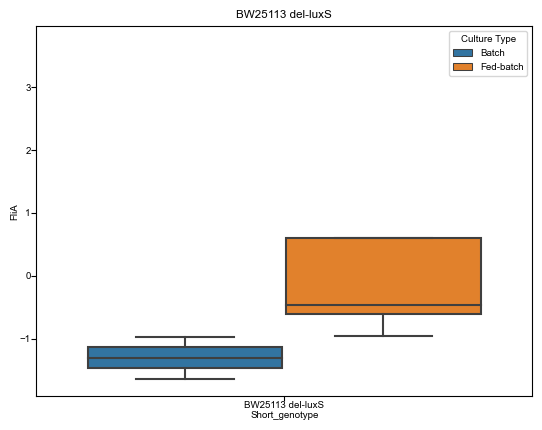

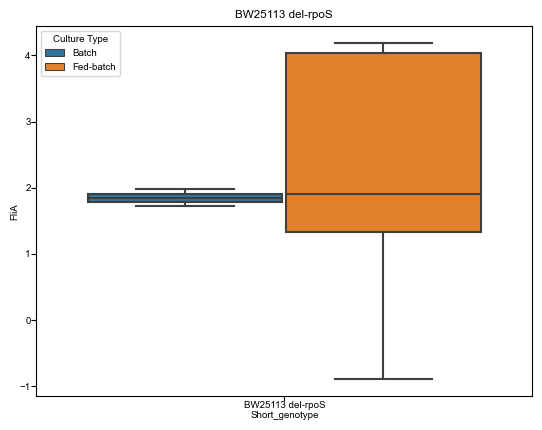

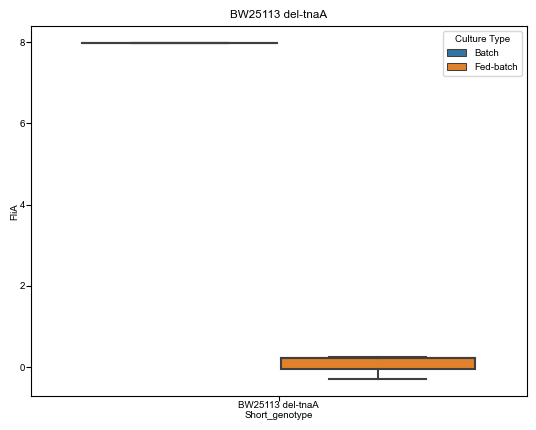

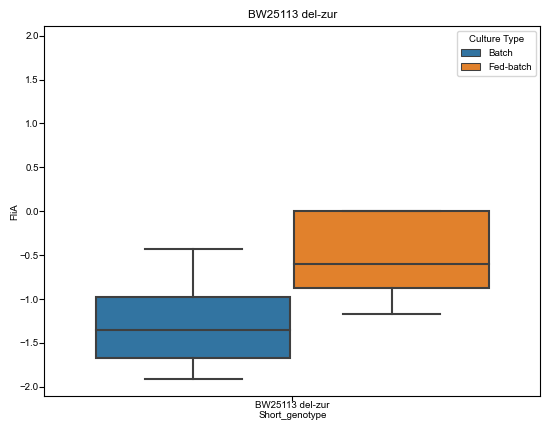

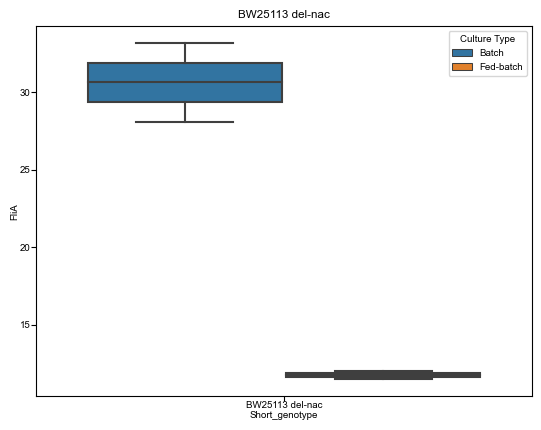

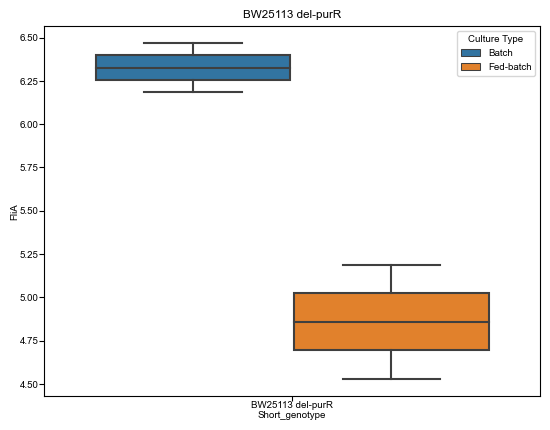

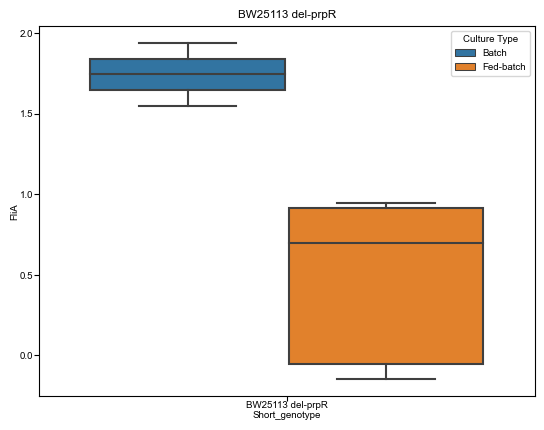

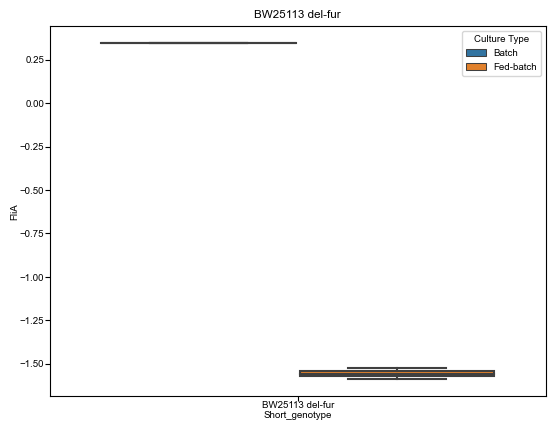

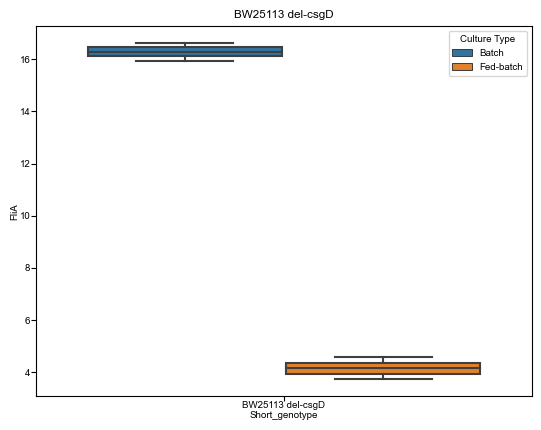

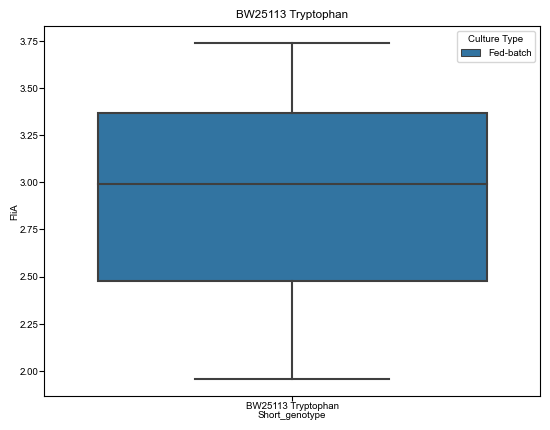

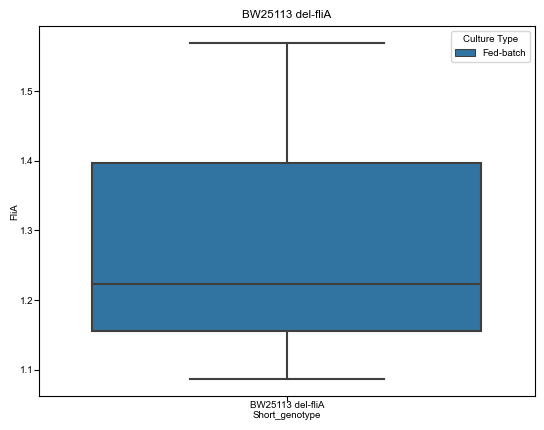

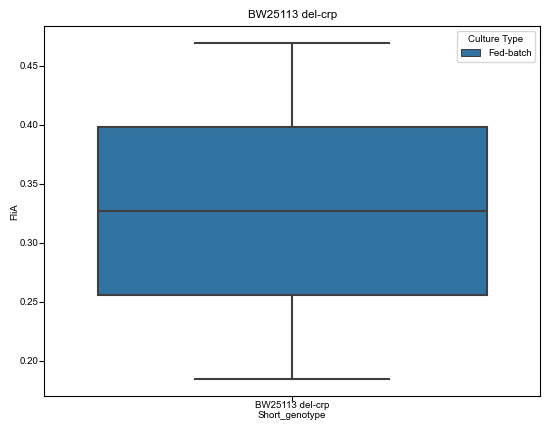

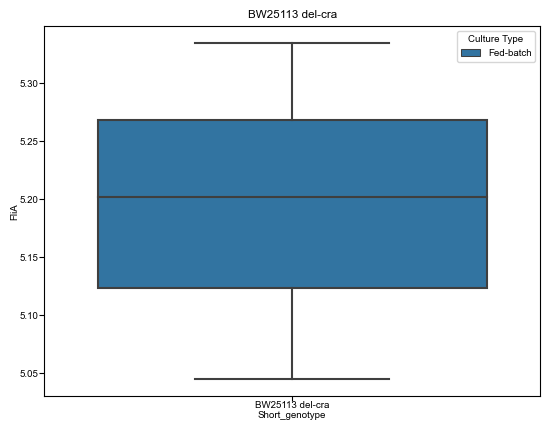

In [41]:
for genotype in A_df["Short_genotype"].unique():
    data = A_df[A_df["Short_genotype"] == genotype]
    fig, ax = plt.subplots()

    sns.boxplot(
        data = data,
        x = "Short_genotype",
        y = "FliA",
        hue = "Culture Type",
        fliersize = 0,
        ax = ax
    )
    ax.set_title(genotype)

### Metal Boxplots

In [42]:
A_df = ica_data_p1k_with_ddb.A.loc[["FliA", "FlhDC-2", "Crp-1", "Acetate", "ppGpp", "Translation", "Fur-1", "Zinc-1"]].T
A_df = pd.concat([A_df,metadata],axis=1).dropna()

<Axes: xlabel='Media version', ylabel='Fur-1'>

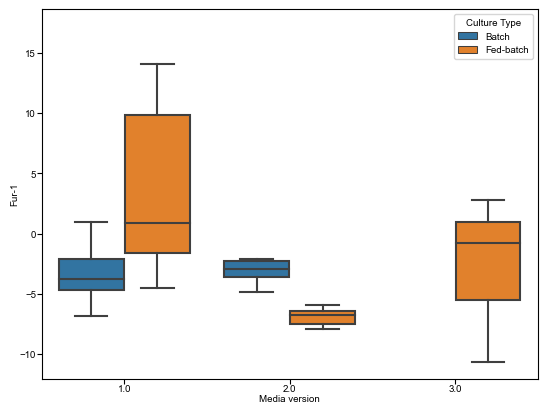

In [43]:
sns.boxplot(
    data = A_df,
    x = "Media version",
    y = "Fur-1",
    hue = "Culture Type",
    fliersize = 0
)

<Axes: xlabel='Media version', ylabel='Zinc-1'>

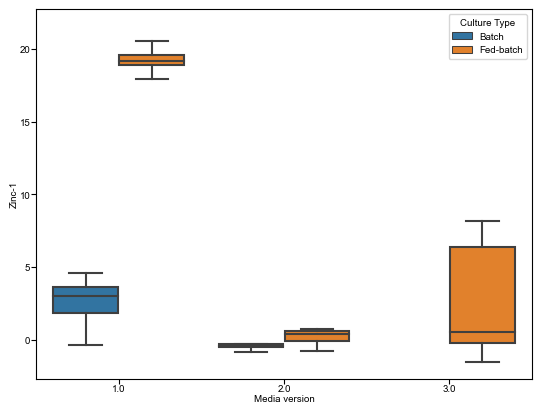

In [44]:
sns.boxplot(
    data = A_df,
    x = "Media version",
    y = "Zinc-1",
    hue = "Culture Type",
    fliersize = 0
)

<Axes: xlabel='Strain Type', ylabel='FlhDC-2'>

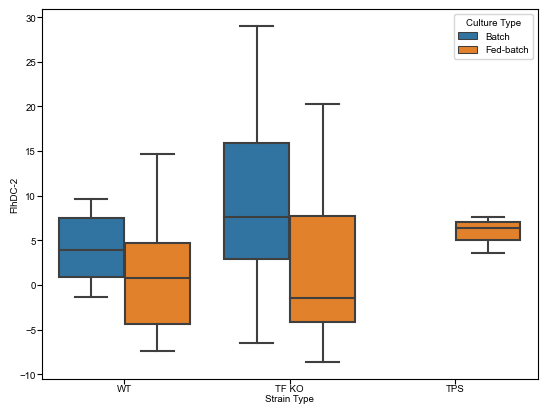

In [45]:
sns.boxplot(
    data = A_df,
    x = "Strain Type",
    y = "FlhDC-2",
    hue = "Culture Type",
    fliersize = 0
)

#### Custom Barplots

In [46]:
metadata = pd.read_csv("R/metadata_for_PCA.csv", index_col=0)
df1 = ica_data_p1k_with_ddb.A.T[["Fur-1", "Zinc-1"]]
df2 = pd.concat([df1,metadata],axis=1).dropna()
df2["pos1"] = -0.2
df2["pos2"] = 0.2
df2["pos3"] = 0.8
df2["pos4"] = 1.2
df2["pos5"] = 1.8
df2["pos6"] = 2.2

In [47]:
df2

Fur-1     Zinc-1    project  \
DDB2__PD-005_BW25113_Batch_6h__1     -4.771833   2.881477       DDB2   
DDB2__PD-005_BW25113_Batch_6h__2     -4.448048   3.074162       DDB2   
DDB2__PD-003_BW25113_Batch_9h__1     -0.212429  10.391707       DDB2   
DDB2__PD-003_BW25113_Batch_9h__2      0.061223   9.915875       DDB2   
DDB2__PD-003_BW25113_Fed-batch_6h__1 -2.332351  19.013575       DDB2   
...                                        ...        ...        ...   
PD_123_R11_S05#                      -8.924534   0.850239  ddb_ff_sd   
PD_123_R13_S05#                       0.194580  -0.435905  ddb_ff_sd   
PD_123_R5_S05#1                       2.139440   6.172782  ddb_ff_sd   
PD_123_R7_S05#1                       0.114831   0.076359  ddb_ff_sd   
PD_123_R9_S05#1                      -2.370756  -0.539580  ddb_ff_sd   

                                     Strain Type  \
DDB2__PD-005_BW25113_Batch_6h__1              WT   
DDB2__PD-005_BW25113_Batch_6h__2              WT   
DDB2__PD-003_BW25113_Batch_9h__1              WT   
DDB2__PD-003_BW25113_Batch_9h__2              WT   
DDB2__PD-003_BW25113_Fed-batch_6h__1          WT   
...                                          ...   
PD_123_R11_S05#                            TF KO   
PD_123_R13_S05#                            TF KO   
PD_123_R5_S05#1                               WT   
PD_123_R7_S05#1                            TF KO   
PD_123_R9_S05#1                            TF KO   

                                                     Strain Description  \
DDB2__PD-005_BW25113_Batch_6h__1               Escherichia coli BW25113   
DDB2__PD-005_BW25113_Batch_6h__2               Escherichia coli BW25113   
DDB2__PD-003_BW25113_Batch_9h__1               Escherichia coli BW25113   
DDB2__PD-003_BW25113_Batch_9h__2               Escherichia coli BW25113   
DDB2__PD-003_BW25113_Fed-batch_6h__1           Escherichia coli BW25113   
...                                                                 ...   
PD_123_R11_S05#                       Escherichia coli BW25113 del-rpoS   
PD_123_R13_S05#                       Escherichia coli BW25113 del-fliA   
PD_123_R5_S05#1                                Escherichia coli BW25113   
PD_123_R7_S05#1                       Escherichia coli BW25113 del-prpR   
PD_123_R9_S05#1                        Escherichia coli BW25113 del-cra   

                                        Short_genotype Culture Type  \
DDB2__PD-005_BW25113_Batch_6h__1               BW25113        Batch   
DDB2__PD-005_BW25113_Batch_6h__2               BW25113        Batch   
DDB2__PD-003_BW25113_Batch_9h__1               BW25113        Batch   
DDB2__PD-003_BW25113_Batch_9h__2               BW25113        Batch   
DDB2__PD-003_BW25113_Fed-batch_6h__1           BW25113    Fed-batch   
...                                                ...          ...   
PD_123_R11_S05#                       BW25113 del-rpoS    Fed-batch   
PD_123_R13_S05#                       BW25113 del-fliA    Fed-batch   
PD_123_R5_S05#1                                BW25113    Fed-batch   
PD_123_R7_S05#1                       BW25113 del-prpR    Fed-batch   
PD_123_R9_S05#1                        BW25113 del-cra    Fed-batch   

                                      Media version Growth Rate (1/hr) mu_set  \
DDB2__PD-005_BW25113_Batch_6h__1                1.0                max   none   
DDB2__PD-005_BW25113_Batch_6h__2                1.0                max   none   
DDB2__PD-003_BW25113_Batch_9h__1                1.0                max   none   
DDB2__PD-003_BW25113_Batch_9h__2                1.0                max   none   
DDB2__PD-003_BW25113_Fed-batch_6h__1            1.0               0.11   0.11   
...                                             ...                ...    ...   
PD_123_R11_S05#                                 3.0               0.05   0.05   
PD_123_R13_S05#                                 3.0               0.05   0.05   
PD_123_R5_S05#1                                 3.0               0.

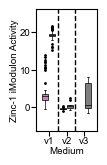

In [48]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5
plt.rcParams['axes.labelpad']= 0.5

fig, ax = plt.subplots()

df = df2[(df2["Media version"] == 1) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(linewidth=0.5,facecolor="tab:pink"),
    positions=[-0.2]
)

df = df2[(df2["Media version"] == 1) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[0.2]
)


df = df2[(df2["Media version"] == 2) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:pink"),
    positions=[0.8]
)

df = df2[(df2["Media version"] == 2) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[1.2]
)


df = df2[(df2["Media version"] == 3) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:pink"),
    positions=[1.8]
)

df = df2[(df2["Media version"] == 3) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[2.2]
)

ax.set_xticks([0,1,2],["v1","v2","v3"])
ax.set_xlabel("Medium")
ax.set_ylabel("Zinc-1 iModulon Activity")

ax.set_ylim(zinc_lower, zinc_upper)
ax.vlines(x=[0.5,1.5], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=1, color="k", linestyle="--")

w=20/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

# plt.savefig("Zinc-1_by_medium.svg", dpi=900)

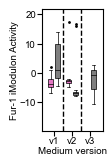

In [49]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5
plt.rcParams['axes.labelpad']= 0.5

fig, ax = plt.subplots()

df = df2[(df2["Media version"] == 1) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(linewidth=0.5,facecolor="tab:pink"),
    positions=[-0.2]
)

df = df2[(df2["Media version"] == 1) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[0.2]
)


df = df2[(df2["Media version"] == 2) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:pink"),
    positions=[0.8]
)

df = df2[(df2["Media version"] == 2) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[1.2]
)


df = df2[(df2["Media version"] == 3) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:pink"),
    positions=[1.8]
)

df = df2[(df2["Media version"] == 3) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[2.2]
)

ax.set_xticks([0,1,2],["v1","v2","v3"])
ax.set_xlabel("Medium version")
ax.set_ylabel("Fur-1 iModulon Activity")

ax.set_ylim(fur_lower, fur_upper)
ax.vlines(x=[0.5,1.5], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=1, color="k", linestyle="--")

w=20/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

# plt.savefig("Fur-1_by_medium.svg", dpi=900)

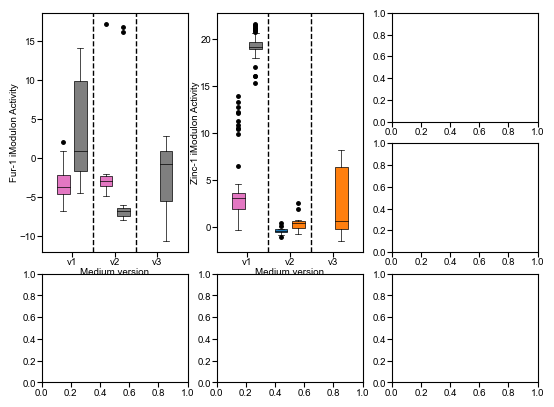

In [50]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5

fig = plt.figure()
spec = fig.add_gridspec(nrows=3, ncols=3)

# frame = fig.add_subplot(spec[:,:])
ax1 = fig.add_subplot(spec[:2,0])
ax2 = fig.add_subplot(spec[:2,1])
ax3 = fig.add_subplot(spec[2,0])
ax4 = fig.add_subplot(spec[2,1])
ax5 = fig.add_subplot(spec[0,2])
ax6 = fig.add_subplot(spec[1,2])
ax7 = fig.add_subplot(spec[2,2])

######################################################
######################################################

df = df2[(df2["Media version"] == 1) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax1,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(linewidth=0.5,facecolor="tab:pink"),
    positions=[-0.2]
)

df = df2[(df2["Media version"] == 1) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax1,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[0.2]
)


df = df2[(df2["Media version"] == 2) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax1,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:pink"),
    positions=[0.8]
)

df = df2[(df2["Media version"] == 2) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax1,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[1.2]
)


df = df2[(df2["Media version"] == 3) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax1,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:pink"),
    positions=[1.8]
)

df = df2[(df2["Media version"] == 3) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax1,
    column="Fur-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[2.2]
)

ax1.set_xticks([0,1,2],["v1","v2","v3"])
ax1.set_xlabel("Medium version")
ax1.set_ylabel("Fur-1 iModulon Activity")

ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])
ax1.vlines(x=[0.5,1.5], ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linewidth=1, color="k", linestyle="--")

######################################################
######################################################

df = df2[(df2["Media version"] == 1) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax2,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(linewidth=0.5,facecolor="tab:pink"),
    positions=[-0.2]
)

df = df2[(df2["Media version"] == 1) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax2,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[0.2]
)


df = df2[(df2["Media version"] == 2) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax2,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:blue"),
    positions=[0.8]
)

df = df2[(df2["Media version"] == 2) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax2,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:orange"),
    positions=[1.2]
)


df = df2[(df2["Media version"] == 3) & (df2["Culture Type"] == "Batch")]

df.boxplot(
    ax=ax2,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:blue"),
    positions=[1.8]
)

df = df2[(df2["Media version"] == 3) & (df2["Culture Type"] == "Fed-batch")]

df.boxplot(
    ax=ax2,
    column="Zinc-1",
    grid=False, 
    widths=0.3,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker=".",markersize=5),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:orange"),
    positions=[2.2]
)

ax2.set_xticks([0,1,2],["v1","v2","v3"])
ax2.set_xlabel("Medium version")
ax2.set_ylabel("Zinc-1 iModulon Activity")

ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1])
ax2.vlines(x=[0.5,1.5], ymin=ax2.get_ylim()[0], ymax=ax2.get_ylim()[1], linewidth=1, color="k", linestyle="--")

######################################################
######################################################

w=120/25.4
h=90/25.4
# fig.set_size_inches(w=w,h=h)

### DiMAs of all strains separately 

In [57]:
hcd_sample_table["Strain Description"].unique()

array(['Escherichia coli BW25113', 'Escherichia coli BW25113 del-basS',
       'Escherichia coli BW25113 del-kdpE',
       'Escherichia coli BW25113 del-phoB',
       'Escherichia coli BW25113 del-qseB',
       'Escherichia coli BW25113 del-qseC',
       'Escherichia coli BW25113 del-qseF',
       'Escherichia coli K-12 MG1655 del-fhuA',
       'Escherichia coli BW25113 del-arcA',
       'Escherichia coli BW25113 del-baeR',
       'Escherichia coli BW25113 del-lsrB',
       'Escherichia coli BW25113 del-lsrK',
       'Escherichia coli BW25113 del-lsrR',
       'Escherichia coli BW25113 del-luxS',
       'Escherichia coli BW25113 del-rpoS',
       'Escherichia coli BW25113 del-tnaA',
       'Escherichia coli BW25113 del-zur',
       'Escherichia coli BW25113 del-nac',
       'Escherichia coli BW25113 del-purR',
       'Escherichia coli BW25113 del-prpR',
       'Escherichia coli BW25113 del-fur',
       'Escherichia coli BW25113 del-csgD',
       'Escherichia coli K-12 BW25113 FolE(T198

#### WT (BW25113)

In [58]:
batch_samples = hcd_sample_table[(hcd_sample_table["Culture Type"] == "Batch") & (hcd_sample_table["Strain Description"] == "Escherichia coli BW25113")].index
fed_batch_samples = hcd_sample_table[(hcd_sample_table["Culture Type"] == "Fed-batch") & (hcd_sample_table["Strain Description"] == "Escherichia coli BW25113")].index

In [59]:
len(batch_samples)

11

In [60]:
len(fed_batch_samples)

24

difference    pvalue    qvalue          0          1
Crp-1            16.048038  0.001230  0.012361  -1.867002  14.181036
UC-3             14.207453  0.000093  0.002660  -2.892506  11.314947
Acetate          14.029377  0.000025  0.001704  -0.950265  13.079112
Propionate       12.666344  0.000009  0.001035   0.324425  12.990769
Curli-1          11.693742  0.000141  0.003541  -4.030059   7.663683
Glycolate        11.635956  0.000047  0.001881   3.257980  14.893936
Crp-2            11.506018  0.001007  0.011244  -1.665462   9.840556
Curli-2          11.394248  0.000260  0.004745   0.895951  12.290199
Maltose           9.695001  0.002455  0.018975  -2.648401   7.046600
Quorum Sensing    9.238441  0.000010  0.001035  -0.036527   9.201913
Tryptophanase     8.880760  0.000289  0.004839  -0.031230   8.849530
Zinc-1            8.279832  0.001745  0.015249   5.048653  13.328485
NtrC-1            7.730280  0.000350  0.005270   0.652690   8.382971
PAL 10 Del        7.548168  0.000080  0.002660  -0.306003   7.242165
UC-8              7.101350  0.005705  0.027968   5.002550  12.103900
Fur-1             5.764743  0.030373  0.088479  -3.199046   2.565697
Putrescine        5.706397  0.005249  0.026531  -6.335434  -0.629037
Nitrogen          5.031961  0.000241  0.004745   0.658480   5.690441
NtrC-2           -5.456569  0.004322  0.024132  -1.621728  -7.078297
minicoli KOs     -6.009904  0.002126  0.017093   0.910084  -5.099820
Purine           -6.075169  0.011426  0.046871  -0.081139  -6.156307
Translation      -8.230862  0.015423  0.055358   2.442342  -5.788521
Thiamine-1       -8.550179  0.000444  0.005952 -10.436908 -18.987086
FDH-N/NRA        -8.838826  0.004215  0.024132   8.240588  -0.598238
Magnesium        -9.330086  0.000232  0.004745   6.455966  -2.874121
ppGpp            -9.381997  0.016018  0.056486   0.340413  -9.041584
crp KO-1         -9.614475  0.000367  0.005270   2.329496  -7.284979
Pyrimidine      -10.975974  0.001743  0.015249  -2.434279 -13.410253
Osmoprotectant  -13.732593  0.000045  0.001881  14.399528   0.666934

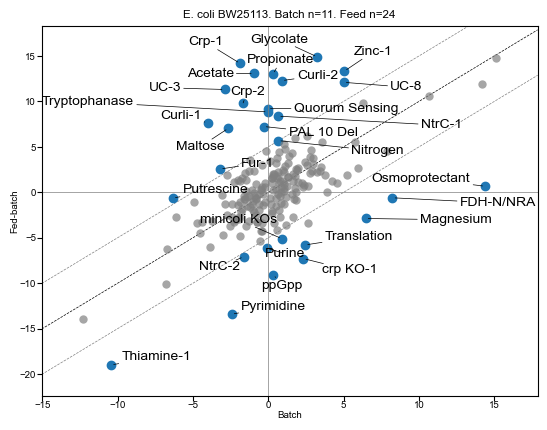

In [61]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, wt_table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=0.1,
    threshold=5,
    line45_margin=5,
    table=True
)
ax.set_title("E. coli BW25113. Batch n="+str(len(batch_samples))+". Feed n="+str(len(fed_batch_samples)))
plt.xlabel("Batch")
plt.ylabel("Fed-batch")
wt_table

#### WT (MG1655)

In [62]:
batch_samples = hcd_sample_table[(hcd_sample_table["Culture Type"] == "Batch") & (hcd_sample_table["Strain Description"] == "Escherichia coli K-12 MG1655 del-fhuA")].index
fed_batch_samples = hcd_sample_table[(hcd_sample_table["Culture Type"] == "Fed-batch") & (hcd_sample_table["Strain Description"] == "Escherichia coli K-12 MG1655 del-fhuA")].index

difference    pvalue    qvalue          0          1
UC-3             16.240982  0.000054  0.002155  -2.886513  13.354469
Crp-1            16.041435  0.001231  0.010778  -1.309877  14.731558
Zinc-1           15.839987  0.000200  0.004193   3.308725  19.148712
Propionate       13.622475  0.000006  0.000852  -0.401810  13.220666
Acetate          12.969610  0.000037  0.001847  -0.085739  12.883871
Glycolate        12.824009  0.000030  0.001847   4.426619  17.250628
Crp-2            10.761577  0.001227  0.010778   0.805118  11.566696
Maltose           9.883608  0.002335  0.019519  -1.122912   8.760696
Quorum Sensing    9.567194  0.000008  0.000852   0.875197  10.442391
Tryptophanase     8.838366  0.000294  0.004931  -0.419299   8.419066
NtrC-1            8.790939  0.000209  0.004193   0.693472   9.484412
Curli-2           8.321257  0.000777  0.009189   0.240016   8.561273
Fur-1             7.985715  0.016040  0.055389  -3.879934   4.105780
Curli-1           7.917180  0.000659  0.008705  -2.913904   5.003276
FucR/ExuR         5.877027  0.000665  0.008705  -0.366616   5.510411
PAL 10 Del        5.757223  0.000289  0.004931   0.579736   6.336959
ykgR              5.360849  0.012832  0.046896   1.843198   7.204047
NrdR              5.291279  0.006844  0.036202  -2.807762   2.483517
Nitrogen          5.266224  0.000194  0.004193   0.592507   5.858731
Rhamnose          5.173431  0.000851  0.009508  -0.438339   4.735092
NtrC-2           -5.273115  0.004775  0.029433  -2.106444  -7.379559
Purine           -5.534353  0.013836  0.048790  -0.736451  -6.270804
Translation      -6.728130  0.023711  0.068085   2.172685  -4.555445
Thiamine-1       -7.563242  0.000693  0.008705 -11.156414 -18.719656
ppGpp            -7.641007  0.023366  0.068085  -1.185716  -8.826723
FDH-N/NRA        -9.075888  0.003943  0.027328   8.171197  -0.904690
FlhDC-2          -9.883423  0.006798  0.036202   4.041727  -5.841696
Osmoprotectant  -10.636068  0.000124  0.004164  13.857181   3.221113
crp KO-1        -11.219732  0.000203  0.004193   1.067222 -10.152510
Pyrimidine      -12.439835  0.001233  0.010778  -1.186170 -13.626005

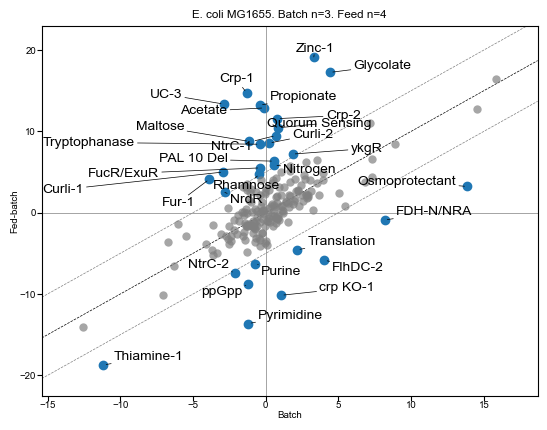

In [63]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, mg1655_table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=0.1,
    threshold=5,
    line45_margin=5,
    table=True
)
ax.set_title("E. coli MG1655. Batch n="+str(len(batch_samples))+". Feed n="+str(len(fed_batch_samples)))
plt.xlabel("Batch")
plt.ylabel("Fed-batch")
mg1655_table

#### Other strains

In [66]:
hcd_sample_table["Strain Description"].unique()

array(['Escherichia coli BW25113', 'Escherichia coli BW25113 del-basS',
       'Escherichia coli BW25113 del-kdpE',
       'Escherichia coli BW25113 del-phoB',
       'Escherichia coli BW25113 del-qseB',
       'Escherichia coli BW25113 del-qseC',
       'Escherichia coli BW25113 del-qseF',
       'Escherichia coli K-12 MG1655 del-fhuA',
       'Escherichia coli BW25113 del-arcA',
       'Escherichia coli BW25113 del-baeR',
       'Escherichia coli BW25113 del-lsrB',
       'Escherichia coli BW25113 del-lsrK',
       'Escherichia coli BW25113 del-lsrR',
       'Escherichia coli BW25113 del-luxS',
       'Escherichia coli BW25113 del-rpoS',
       'Escherichia coli BW25113 del-tnaA',
       'Escherichia coli BW25113 del-zur',
       'Escherichia coli BW25113 del-nac',
       'Escherichia coli BW25113 del-purR',
       'Escherichia coli BW25113 del-prpR',
       'Escherichia coli BW25113 del-fur',
       'Escherichia coli BW25113 del-csgD',
       'Escherichia coli K-12 BW25113 FolE(T198

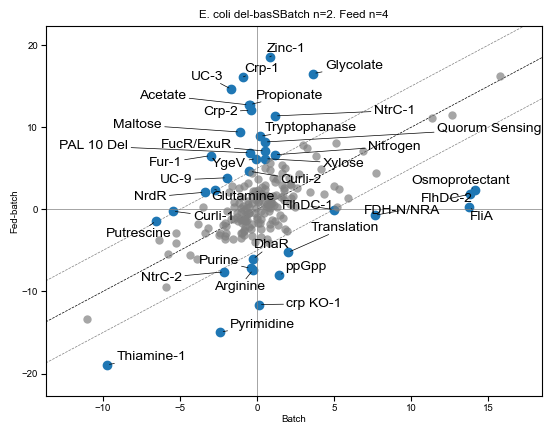

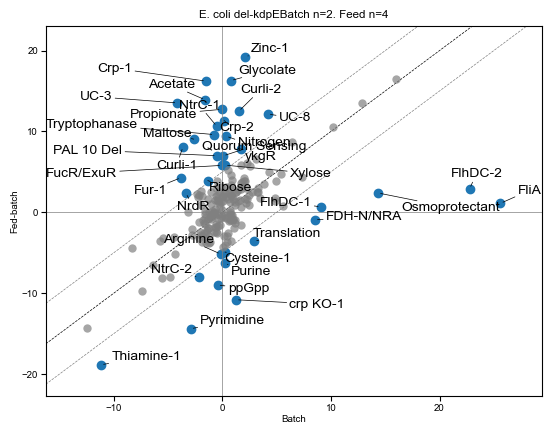

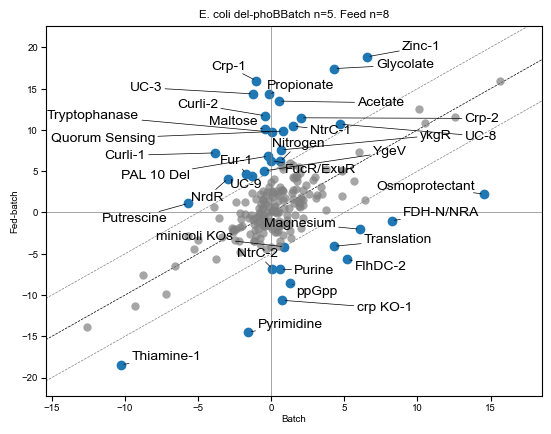

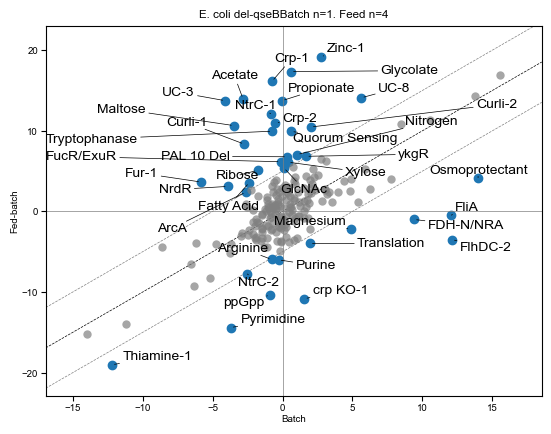

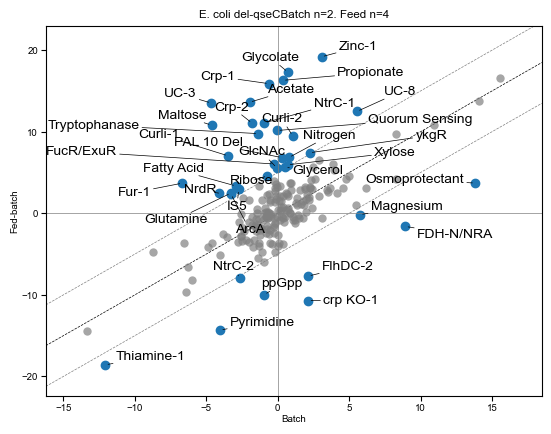

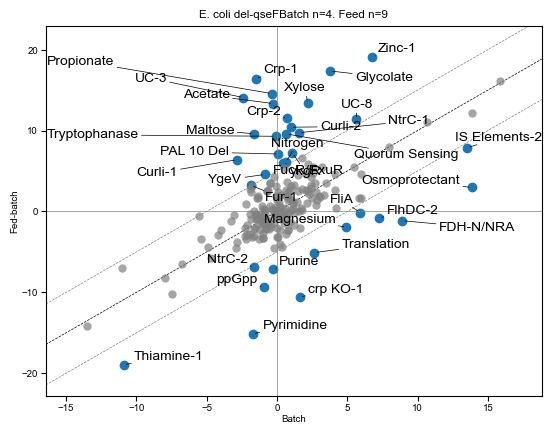

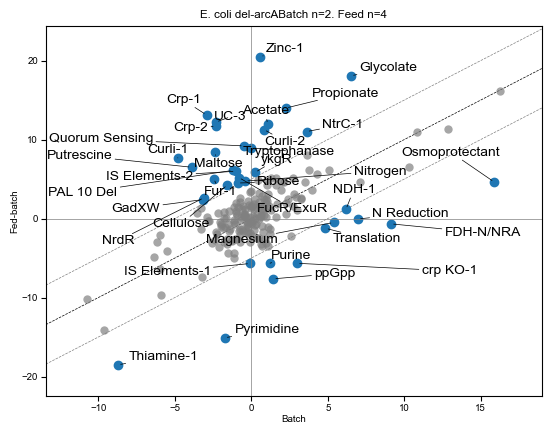

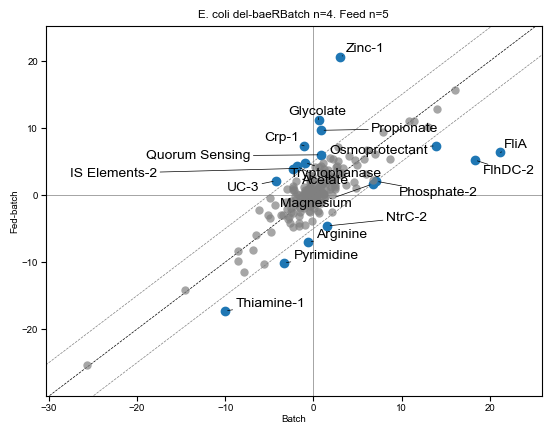

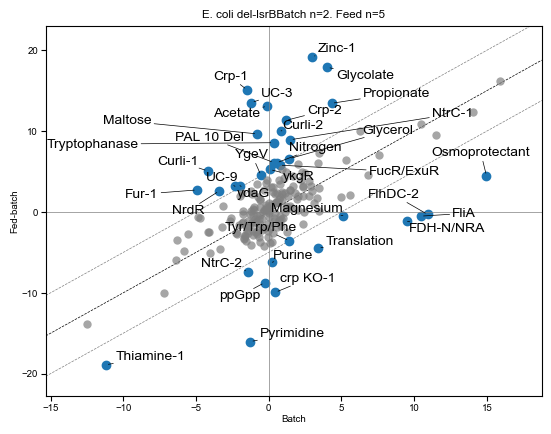

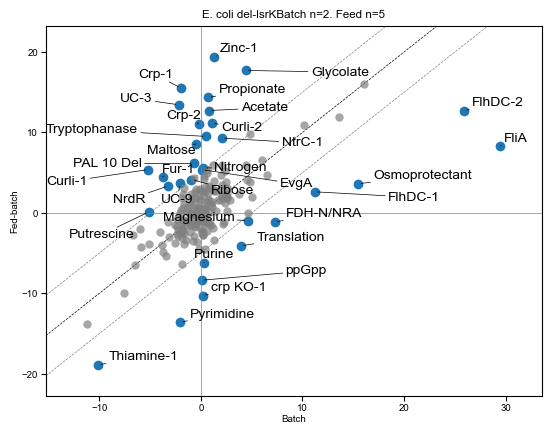

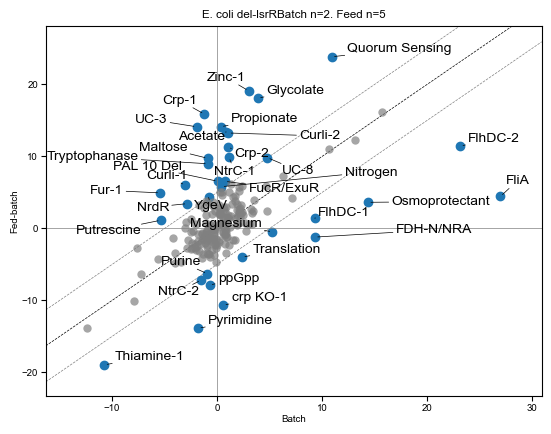

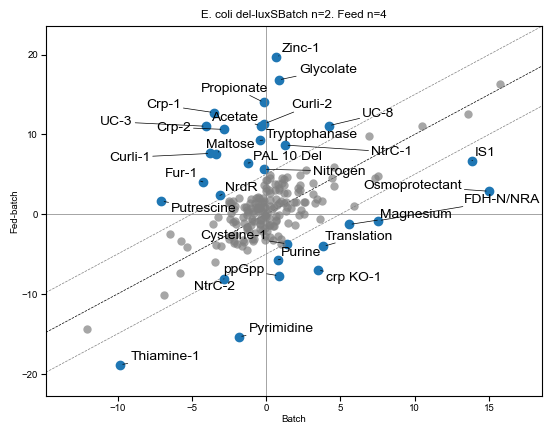

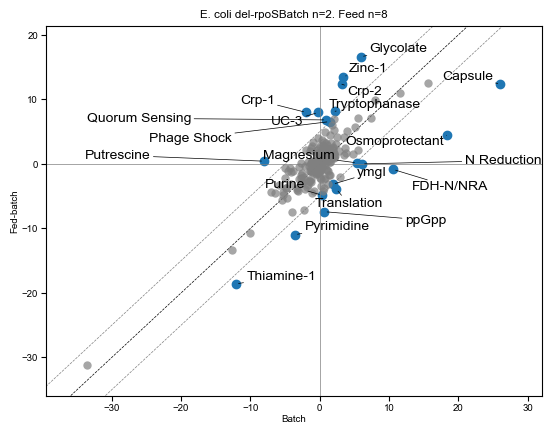

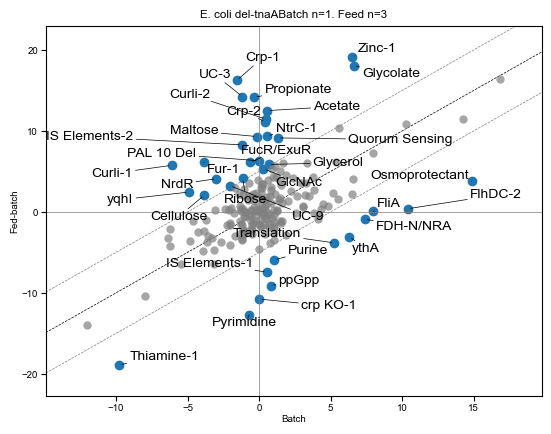

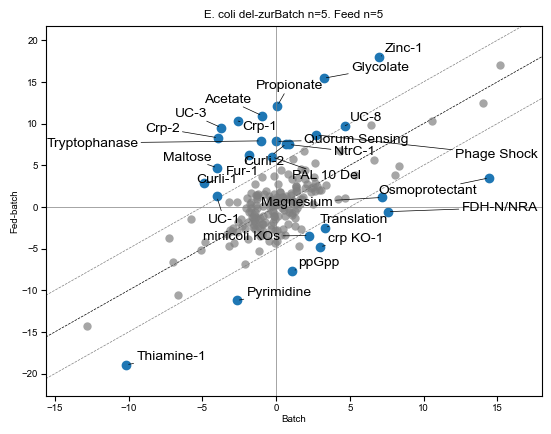

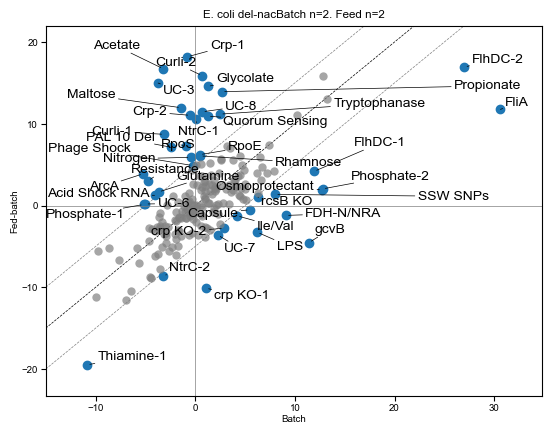

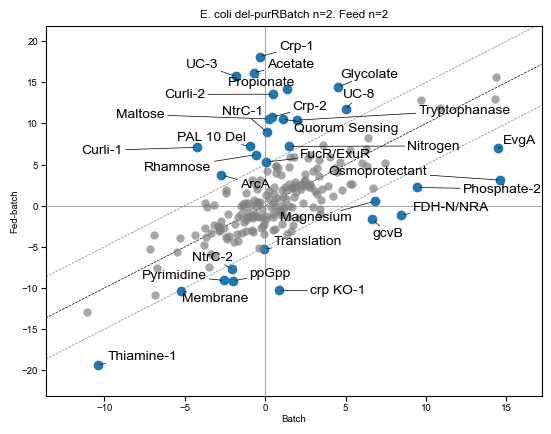

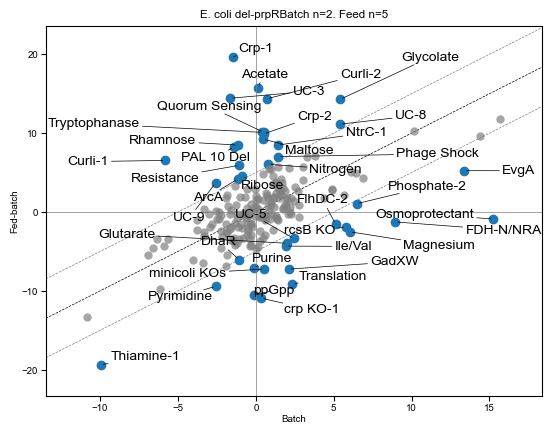

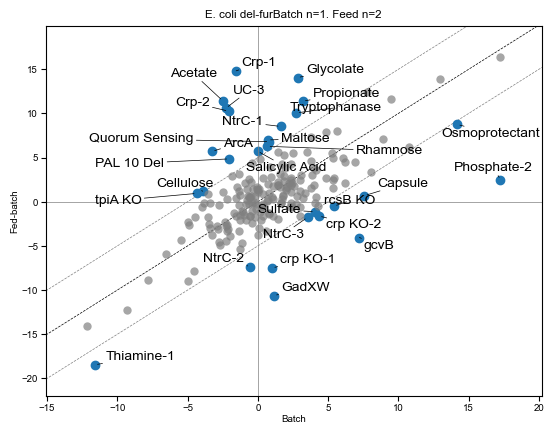

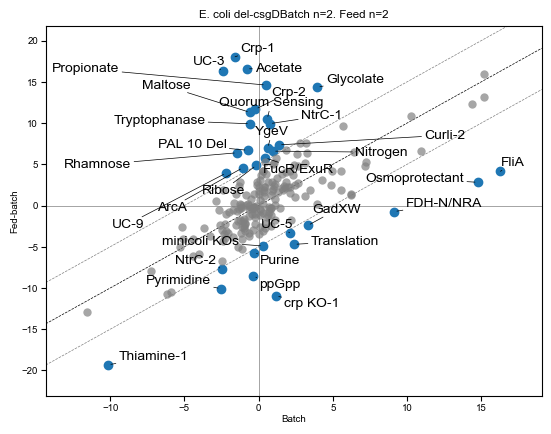

In [67]:
for strain in hcd_sample_table["Strain Description"].unique():
    
    if (strain != "Escherichia coli BW25113") & (strain != "Escherichia coli K-12 MG1655 del-fhuA") & (strain != "Escherichia coli BW25113 del-fliA") & (strain != "Escherichia coli BW25113 del-crp") & (strain != "Escherichia coli BW25113 del-cra"):
        
        strain_short = hcd_sample_table[hcd_sample_table["Strain Description"] == strain]["Strain"].unique()[0]
        
        if strain_short != "HMP3071":
            
            batch_samples = hcd_sample_table[(hcd_sample_table["Culture Type"] == "Batch") & (hcd_sample_table["Strain Description"] == strain)].index
            fed_batch_samples = hcd_sample_table[(hcd_sample_table["Culture Type"] == "Fed-batch") & (hcd_sample_table["Strain Description"] == strain)].index
            
            sample_1 = batch_samples
            sample_2 = fed_batch_samples

            ax, vars()["table_"+strain.split("-")[-1]] = plot_dima(
                ica_data_p1k_with_ddb,
                sample_1,
                sample_2,
                fdr=0.1,
                threshold=5,
                line45_margin=5,
                table=True
            )
            ax.set_title("E. coli del-"+strain.split("-")[-1]+"Batch n="+str(len(batch_samples))+". Feed n="+str(len(fed_batch_samples)))
            plt.xlabel("Batch")
            plt.ylabel("Fed-batch")

In [69]:
separate_strain_iMs = pd.concat(
    [
        table_arcA,
        table_baeR,
        table_basS,
        table_csgD,
        # table_fhuA,
        table_fur,
        table_kdpE,
        table_lsrB,
        table_lsrK,
        table_lsrR,
        table_luxS,
        table_nac,
        table_phoB,
        table_prpR,
        table_purR,
        table_qseF,
        table_rpoS,
        table_tnaA,
        table_zur
    ]
).index.unique()

In [70]:
len(separate_strain_iMs)

84

### All samples

#### only DDB from P1K

In [71]:
batch_samples = ddb_metadata[ddb_metadata["Culture Type"] == "Batch"].index
fed_batch_samples = ddb_metadata[ddb_metadata["Culture Type"] == "Fed-batch"].index

difference    pvalue    qvalue          0          1
Crp-1            15.974692  0.001245  0.012011  -1.506750  14.467942
Zinc-1           15.598691  0.000212  0.004706   3.822002  19.420693
UC-3             15.104815  0.000072  0.002906  -2.525383  12.579432
Glycolate        13.626711  0.000023  0.001532   3.427129  17.053840
Propionate       12.716874  0.000009  0.001532   0.364854  13.081728
Acetate          12.318733  0.000047  0.002341  -0.248172  12.070561
Crp-2            10.680058  0.001255  0.012011   0.101665  10.781723
Maltose          10.341688  0.002075  0.016687  -1.483300   8.858387
Curli-1           9.042935  0.000397  0.005319  -3.931201   5.111734
Curli-2           8.950564  0.000607  0.007183   0.689592   9.640156
Tryptophanase     8.820599  0.000297  0.004706  -0.180968   8.639631
NtrC-1            8.135900  0.000286  0.004706   0.997718   9.133618
Quorum Sensing    8.107228  0.000021  0.001532   1.242762   9.349990
Fur-1             7.382296  0.018820  0.062013  -3.371669   4.010627
PAL 10 Del        6.280226  0.000194  0.004706  -0.216039   6.064187
Putrescine        5.470540  0.005871  0.032780  -6.337750  -0.867210
FucR/ExuR         5.449955  0.000883  0.009863   0.124364   5.574318
NrdR              5.427271  0.006396  0.033830  -2.738178   2.689093
ykgR              5.296035  0.013261  0.049360   0.894025   6.190061
Xylose            5.230435  0.000342  0.004916   0.834303   6.064737
Nitrogen          5.104445  0.000225  0.004706   0.520832   5.625277
NtrC-2           -5.348028  0.004583  0.028787  -1.574526  -6.922554
Purine           -6.108187  0.011298  0.045418  -0.108098  -6.216286
Magnesium        -6.132689  0.001151  0.012011   5.566932  -0.565757
Translation      -6.732000  0.023683  0.073446   2.667106  -4.064894
Thiamine-1       -8.105390  0.000540  0.006785 -10.626013 -18.731403
ppGpp            -8.214519  0.020504  0.065417  -0.514597  -8.729116
FliA             -8.238484  0.003665  0.025405   9.379179   1.140695
FDH-N/NRA        -9.116534  0.003898  0.026119   8.259162  -0.857371
FlhDC-2          -9.164725  0.008030  0.038431   9.612237   0.447512
crp KO-1        -10.635487  0.000250  0.004706   1.250659  -9.384829
Osmoprotectant  -10.819696  0.000116  0.003895  14.551584   3.731888
Pyrimidine      -12.109488  0.001330  0.012149  -2.183711 -14.293198

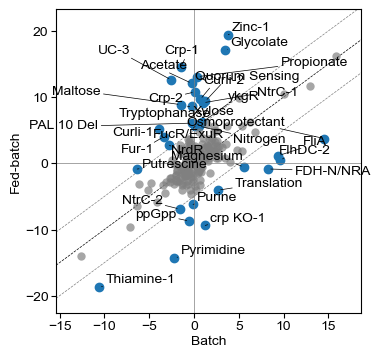

In [72]:
plt.rcParams['font.size'] = 10
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2

plt.rcParams['axes.labelpad']= 2

fig,ax = plt.subplots()

sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, dima_table_p1k = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True,
    ax=ax
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")

w=100/25.4
h=100/25.4
fig.set_size_inches(w=w,h=h)
plt.savefig("Fed-batch_DiMA_P1K.svg")

ica_data_p1k_with_ddb.imodulon_table.loc[dima_table_p1k.index].to_excel("dima_table_p1k.xlsx")
dima_table_p1k

In [73]:
batch_samples = ddb_metadata[ddb_metadata["Culture Type"] == "Batch"].index
fed_batch_samples = ddb_metadata[ddb_metadata["Culture Type"] == "Fed-batch"].index

In [74]:
df_batch = ica_data_p1k_with_ddb.A[batch_samples].T[["Zinc-1", "Fur-1"]].reset_index()
df_fb = ica_data_p1k_with_ddb.A[fed_batch_samples].T[["Zinc-1", "Fur-1"]].reset_index()

In [75]:
df_batch["Timepoint"] = df_batch["index"].str.split("Batch_",expand=True)[1].str.split("__",expand=True)[0]
df_fb["Timepoint"] = df_fb["index"].str.split("Fed-batch_",expand=True)[1].str.split("__",expand=True)[0]

In [76]:
df_batch["Timepoint"].unique()

array(['6h', '9h', '12h'], dtype=object)

In [77]:
df_fb["Timepoint"].unique()

array(['6h', '15h', '21h', '12h', '18h'], dtype=object)

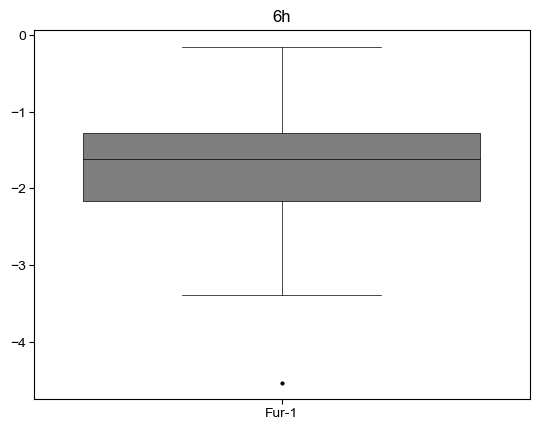

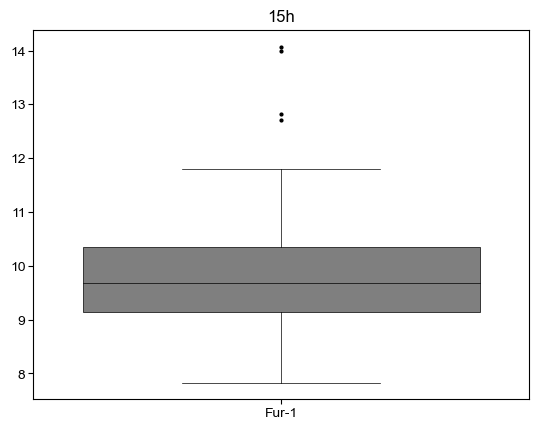

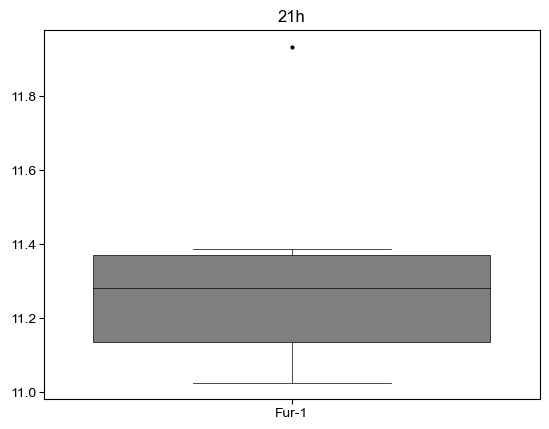

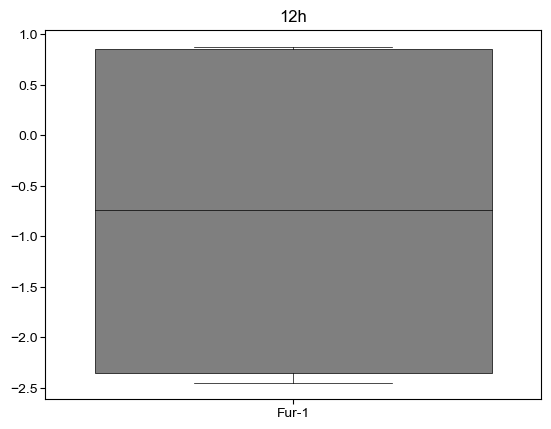

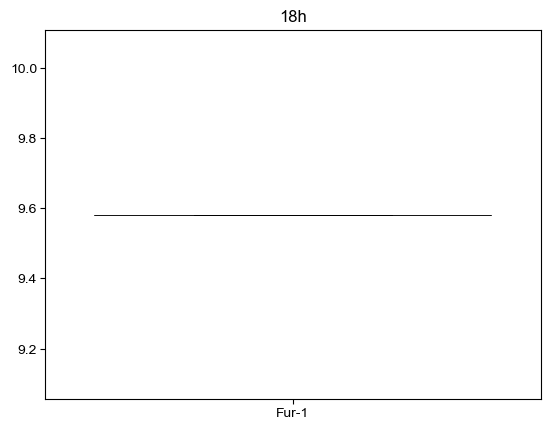

In [78]:
for timepoint in df_fb["Timepoint"].unique():
    
    fig, ax = plt.subplots()

    data = df_fb[df_fb["Timepoint"] == timepoint]

    data.boxplot(
        ax=ax,
        column="Fur-1",
        grid=False, 
        widths=0.8,
        capprops=dict(linewidth=0.5,color="k"),
        whiskerprops=dict(linewidth=0.5,color="k"),
        medianprops=dict(linewidth=0.5,color="k"),
        flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
        patch_artist=True,
        color="k",
        boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
        positions=[0.0]
    )
    ax.set_title(timepoint)

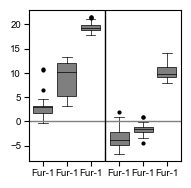

In [79]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2

plt.rcParams['axes.labelpad']= 2

fig, ax = plt.subplots()

########################################################################################
########################################################################################
########################################################################################

data = df_batch[(df_batch["Timepoint"] == "6h") | (df_batch["Timepoint"] == "12h")]

data.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[0.0]
)

########################################################################################
########################################################################################
########################################################################################

data = df_batch[df_batch["Timepoint"] == "9h"]

data.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[1.0]
)

########################################################################################
########################################################################################
########################################################################################

# data = df_fb[df_fb["Timepoint"] == "12h"]
data = df_fb

data.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[2.0]
)

########################################################################################
########################################################################################
########################################################################################

# data = df_batch[(df_batch["Timepoint"] == "6h") | (df_batch["Timepoint"] == "12h")]
data = df_batch

data.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[3.2]
)

########################################################################################
########################################################################################
########################################################################################

data = df_fb[(df_fb["Timepoint"] == "6h") | (df_fb["Timepoint"] == "12h")]

data.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[4.2]
)

########################################################################################
########################################################################################
########################################################################################

data = df_fb
data = data[data["Timepoint"] != "6h"]
data = data[data["Timepoint"] != "12h"]


data.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[5.2]
)

ax.set_xlim(-0.6,5.8)
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])

ax.hlines(xmin=ax.get_ylim()[0], xmax=ax.get_ylim()[1], y=0, linestyle="-", color="grey", linewidths=1)
ax.vlines(ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], x=2.6, linestyle="-", color="k", linewidths=1)


w=50/25.4
h=50/25.4
fig.set_size_inches(w=w,h=h)

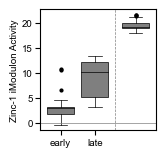

In [80]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2

plt.rcParams['axes.labelpad']= 2

fig, ax = plt.subplots()

########################################################################################
########################################################################################
########################################################################################

data = df_batch[(df_batch["Timepoint"] == "6h") | (df_batch["Timepoint"] == "12h")]

data.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[0.0]
)

########################################################################################
########################################################################################
########################################################################################

data = df_batch[df_batch["Timepoint"] == "9h"]

data.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[1.0]
)

########################################################################################
########################################################################################
########################################################################################

# data = df_fb[df_fb["Timepoint"] == "12h"]
data = df_fb

data.boxplot(
    ax=ax,
    column="Zinc-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[2.2]
)



ax.set_xlim(-0.6,2.8)
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])

ax.hlines(xmin=ax.get_ylim()[0], xmax=ax.get_ylim()[1], y=0, linestyle="-", color="grey", linewidths=0.5)
ax.vlines(ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], x=1.6, linestyle="--", color="grey", linewidths=0.5)

ax.set_ylabel("Zinc-1 iModulon Activity")

w=38/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

ax.set_xticks([0.0,1.0],labels=["early", "late"])

# plt.savefig("Zinc-1_boxplots.svg", dpi=900)

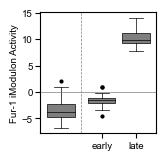

In [81]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2

plt.rcParams['axes.labelpad']= 2

fig, ax = plt.subplots()

########################################################################################
########################################################################################
########################################################################################

# data = df_batch[(df_batch["Timepoint"] == "6h") | (df_batch["Timepoint"] == "12h")]
data = df_batch

data.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[0.0]
)

########################################################################################
########################################################################################
########################################################################################

data = df_fb[(df_fb["Timepoint"] == "6h") | (df_fb["Timepoint"] == "12h")]

data.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[1.2]
)

########################################################################################
########################################################################################
########################################################################################

data = df_fb
data = data[data["Timepoint"] != "6h"]
data = data[data["Timepoint"] != "12h"]


data.boxplot(
    ax=ax,
    column="Fur-1",
    grid=False, 
    widths=0.8,
    capprops=dict(linewidth=0.5,color="k"),
    whiskerprops=dict(linewidth=0.5,color="k"),
    medianprops=dict(linewidth=0.5,color="k"),
    flierprops=dict(markerfacecolor="k",markeredgecolor=None,marker="o",markersize=2),
    patch_artist=True,
    color="k",
    boxprops=dict(color="k",linewidth=0.5,facecolor="tab:grey"),
    positions=[2.2]
)



ax.set_xlim(-0.6,2.8)
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])

ax.hlines(xmin=ax.get_ylim()[0], xmax=ax.get_ylim()[1], y=0, linestyle="-", color="grey", linewidths=0.5)
ax.vlines(ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], x=0.6, linestyle="--", color="grey", linewidths=0.5)

ax.set_ylabel("Fur-1 iModulon Activity")

w=38/25.4
h=40/25.4
fig.set_size_inches(w=w,h=h)

ax.set_xticks([1.2,2.2],labels=["early", "late"])

# plt.savefig("Fur-1_boxplots.svg", dpi=900)

#### all projects

In [82]:
batch_samples = hcd_sample_table[hcd_sample_table["Culture Type"] == "Batch"].index
fed_batch_samples = hcd_sample_table[hcd_sample_table["Culture Type"] == "Fed-batch"].index

difference    pvalue    qvalue          0          1
Crp-1            16.017856  0.001236  0.011968  -1.594037  14.423819
UC-3             14.457333  0.000086  0.002893  -2.680725  11.776608
Acetate          12.694172  0.000041  0.002039  -0.578768  12.115404
Glycolate        12.327160  0.000036  0.002039   3.375571  15.702731
Propionate       11.869585  0.000012  0.002006   0.538821  12.408406
Zinc-1           10.863083  0.000737  0.008227   3.499070  14.362153
Crp-2            10.565145  0.001295  0.011968  -0.617434   9.947711
Maltose           9.627381  0.002499  0.018674  -1.693432   7.933949
Curli-2           9.284425  0.000536  0.007693   0.678593   9.963017
Curli-1           9.134994  0.000382  0.006949  -4.052513   5.082481
Tryptophanase     8.593495  0.000329  0.006605  -0.015307   8.578188
Quorum Sensing    8.180177  0.000020  0.002006   0.886527   9.066704
NtrC-1            7.406146  0.000415  0.006949   0.900153   8.306299
PAL 10 Del        6.742811  0.000138  0.003976  -0.454728   6.288083
Fur-1             5.253118  0.036014  0.097611  -2.922090   2.331028
UC-8              5.094656  0.013045  0.052440   4.787248   9.881905
minicoli KOs     -5.005020  0.003663  0.026294   0.354816  -4.650205
NtrC-2           -5.085632  0.005299  0.034356  -1.744261  -6.829893
Purine           -5.835767  0.012417  0.050933  -0.140091  -5.975858
FliA             -6.384793  0.006778  0.038139   7.903086   1.518293
FlhDC-2          -6.639787  0.015756  0.056551   8.232389   1.592603
Magnesium        -7.167295  0.000650  0.008163   5.920612  -1.246683
Translation      -7.340829  0.019756  0.065098   2.265646  -5.075183
Thiamine-1       -8.213442  0.000515  0.007693 -10.526568 -18.740010
ppGpp            -8.426985  0.019568  0.065098  -0.431114  -8.858099
FDH-N/NRA        -8.930960  0.004107  0.027514   8.200933  -0.730027
crp KO-1         -9.931204  0.000325  0.006605   1.472314  -8.458890
Pyrimidine      -10.393812  0.002020  0.016920  -2.376849 -12.770661
Osmoprotectant  -12.027096  0.000076  0.002893  14.526461   2.499364

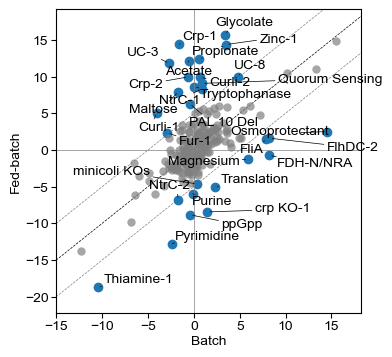

In [83]:
plt.rcParams['font.size'] = 10
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2

plt.rcParams['axes.labelpad']= 2

fig,ax = plt.subplots()

sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, dima_table_w_tps = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True,
    ax=ax
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")

w=100/25.4
h=100/25.4
fig.set_size_inches(w=w,h=h)
plt.savefig("Fed-batch_DiMA_all_strains_all_projects.svg")

ica_data_p1k_with_ddb.imodulon_table.loc[dima_table_w_tps.index].to_excel("Fed-batch_DiMA_table.xlsx")
dima_table_w_tps

In [84]:
len(dima_table_w_tps)

29

<Axes: ylabel='None'>

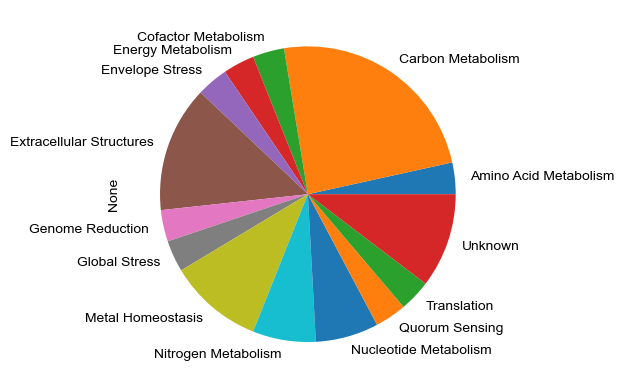

In [85]:
ica_data_p1k_with_ddb.imodulon_table.loc[dima_table_w_tps.index].groupby("functional_category").size().plot(kind="pie")

### Tryptophan producer removed

In [86]:
hcd_sample_table["Strain"].unique()

array(['BW25113', 'MG1655', 'DDB35', 'SDT107', 'DDB7', 'SDT169', 'SDT172',
       'SDT173', 'SDT175', 'SDT176', 'HMP3071', 'SDT180', 'SDT201',
       'SDT202', 'SDT178'], dtype=object)

In [87]:
hcd_sample_no_tps_table = hcd_sample_table[hcd_sample_table["Strain"] != "HMP3071"]

batch_samples = hcd_sample_no_tps_table[hcd_sample_no_tps_table["Culture Type"] == "Batch"].index
fed_batch_samples = hcd_sample_no_tps_table[hcd_sample_no_tps_table["Culture Type"] == "Fed-batch"].index

difference    pvalue    qvalue          0          1
Crp-1            16.020145  0.001236  0.011914  -1.594037  14.426108
UC-3             14.611993  0.000083  0.002771  -2.680725  11.931268
Acetate          12.858470  0.000038  0.001922  -0.578768  12.279702
Glycolate        12.481576  0.000034  0.001922   3.375571  15.857147
Propionate       11.889843  0.000012  0.001891   0.538821  12.428664
Zinc-1           11.207523  0.000665  0.007501   3.499070  14.706594
Crp-2            10.593383  0.001285  0.011914  -0.617434   9.975950
Maltose           9.719103  0.002439  0.018524  -1.693432   8.025670
Curli-2           9.455421  0.000503  0.007223   0.678593  10.134014
Curli-1           9.391916  0.000342  0.006256  -4.052513   5.339403
Tryptophanase     8.684387  0.000315  0.006256  -0.015307   8.669079
Quorum Sensing    8.270904  0.000019  0.001891   0.886527   9.157431
NtrC-1            7.534083  0.000388  0.006497   0.900153   8.434236
PAL 10 Del        6.788642  0.000134  0.003849  -0.454728   6.333914
Fur-1             5.555116  0.032527  0.089561  -2.922090   2.633026
UC-8              5.189774  0.012485  0.050191   4.787248   9.977022
NtrC-2           -5.147822  0.005117  0.033180  -1.744261  -6.892084
Purine           -5.851053  0.012350  0.050191  -0.140091  -5.991144
FliA             -6.417598  0.006698  0.038142   7.903086   1.485489
FlhDC-2          -6.741954  0.015281  0.057719   8.232389   1.490436
Magnesium        -7.104112  0.000672  0.007501   5.920612  -1.183500
Translation      -7.213041  0.020505  0.067565   2.265646  -4.947395
Thiamine-1       -8.271994  0.000501  0.007223 -10.526568 -18.798562
ppGpp            -8.453619  0.019454  0.065820  -0.431114  -8.884733
FDH-N/NRA        -8.985707  0.004044  0.028027   8.200933  -0.784774
crp KO-1        -10.007798  0.000315  0.006256   1.472314  -8.535484
Pyrimidine      -10.432014  0.002000  0.016754  -2.376849 -12.808864
Osmoprotectant  -11.917350  0.000079  0.002771  14.526461   2.609111

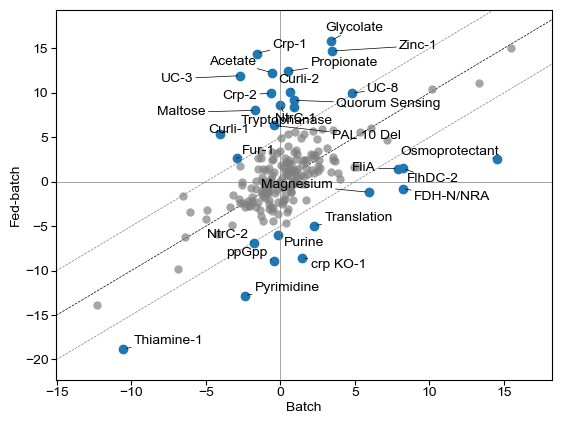

In [88]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, dima_table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
dima_table

In [89]:
len(dima_table)

28

<Axes: ylabel='None'>

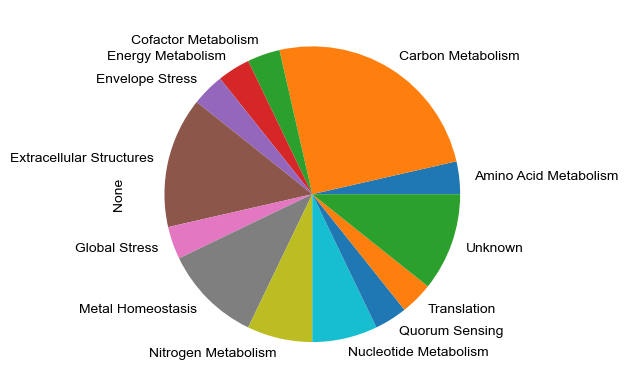

In [91]:
ica_data_p1k_with_ddb.imodulon_table.loc[dima_table.index].groupby("functional_category").size().plot(kind="pie")

### By project

#### DDB2

In [92]:
batch_samples = hcd_sample_table[(hcd_sample_table.project == "DDB2") & (hcd_sample_table["Culture Type"] == "Batch")].index
fed_batch_samples = hcd_sample_table[(hcd_sample_table.project == "DDB2") & (hcd_sample_table["Culture Type"] == "Fed-batch")].index

difference    pvalue    qvalue          0          1
Crp-1            17.104010  0.001032  0.010373  -1.227955  15.876055
UC-3             16.436895  0.000051  0.002051  -2.560940  13.875956
Zinc-1           14.230038  0.000294  0.003938   4.817156  19.047194
Propionate       14.190431  0.000005  0.000968  -0.140236  14.050195
Acetate          13.883856  0.000027  0.001343  -0.484692  13.399164
Glycolate        13.839888  0.000021  0.001343   3.342889  17.182778
Maltose          11.444574  0.001587  0.012756  -1.708919   9.735656
Crp-2            10.837482  0.001202  0.010983   0.569264  11.406746
Curli-1           9.762012  0.000294  0.003938  -3.469650   6.292362
NtrC-1            9.658555  0.000141  0.003028   0.747144  10.405699
Curli-2           9.627197  0.000473  0.005937   0.646561  10.273758
Tryptophanase     9.600134  0.000212  0.003277  -0.275231   9.324903
Quorum Sensing    8.973457  0.000012  0.001215   0.624274   9.597731
Fur-1             7.075569  0.020485  0.060788  -3.044975   4.030594
PAL 10 Del        6.843171  0.000129  0.003028   0.053098   6.896269
Xylose            6.280893  0.000158  0.003028   0.992734   7.273627
UC-8              6.145133  0.008265  0.035345   5.419468  11.564601
ykgR              6.061467  0.009129  0.037626   1.342443   7.403910
FucR/ExuR         6.027943  0.000604  0.006743   0.050217   6.078161
NrdR              5.760161  0.005444  0.030420  -2.747666   3.012496
Nitrogen          5.705507  0.000130  0.003028   0.696346   6.401853
Putrescine        5.086980  0.007096  0.031008  -6.349661  -1.262681
NtrC-2           -5.806315  0.003597  0.024102  -1.465542  -7.271857
Purine           -6.581675  0.009656  0.038056  -0.123569  -6.705243
Magnesium        -6.669642  0.000849  0.008979   5.610152  -1.059490
FliA             -6.716682  0.006018  0.030420   6.559657  -0.157025
Translation      -7.324531  0.019850  0.060451   2.765517  -4.559014
Thiamine-1       -7.951897  0.000579  0.006743 -10.853186 -18.805082
ppGpp            -8.966320  0.017443  0.053939  -0.138435  -9.104755
FDH-N/NRA        -9.522156  0.003489  0.024102   8.558519  -0.963637
FlhDC-2         -10.408106  0.006054  0.030420   8.123993  -2.284112
Osmoprotectant  -11.194971  0.000102  0.003028  14.069882   2.874911
crp KO-1        -11.811911  0.000166  0.003028   1.328186 -10.483725
Pyrimidine      -12.675459  0.001170  0.010983  -2.116621 -14.792080

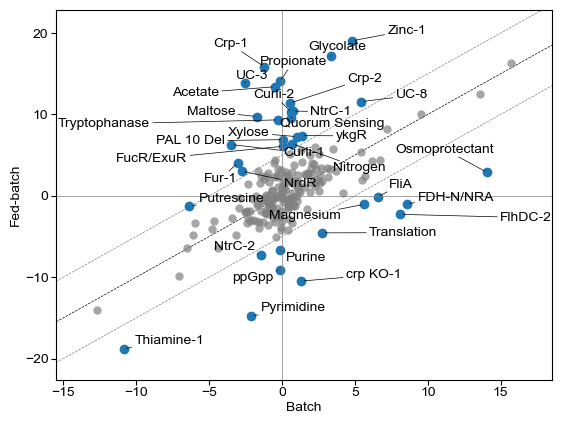

In [93]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
table

<Axes: ylabel='None'>

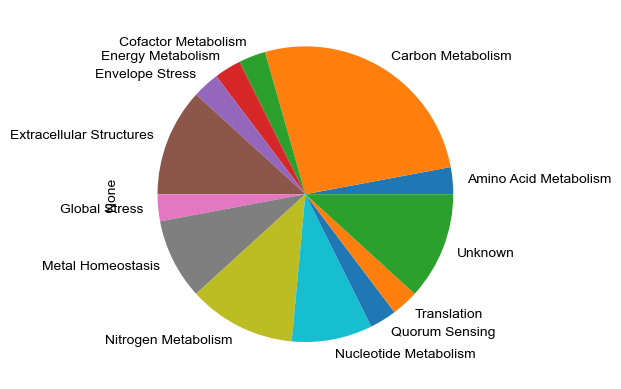

In [94]:
ica_data_p1k_with_ddb.imodulon_table.loc[table.index].groupby("functional_category").size().plot(kind="pie")

#### DDB3

In [95]:
batch_samples = hcd_sample_table[(hcd_sample_table.project == "DDB3") & (hcd_sample_table["Culture Type"] == "Batch")].index
fed_batch_samples = hcd_sample_table[(hcd_sample_table.project == "DDB3") & (hcd_sample_table["Culture Type"] == "Fed-batch")].index

difference    pvalue    qvalue          0          1
Zinc-1           17.422323  0.000141  0.004059   2.475617  19.897941
Crp-1            14.552631  0.001602  0.014632  -1.883944  12.668687
UC-3             13.400040  0.000117  0.004059  -2.477277  10.922763
Glycolate        13.347986  0.000025  0.002528   3.541101  16.889087
Propionate       10.796032  0.000020  0.002528   1.048211  11.844243
Crp-2            10.514051  0.001314  0.013897  -0.530969   9.983082
Acetate          10.301076  0.000104  0.004059   0.071826  10.372902
Maltose           8.915485  0.003040  0.022759  -1.178052   7.737433
Curli-1           8.158806  0.000589  0.008450  -4.555652   3.603155
Curli-2           8.082743  0.000856  0.010125   0.747810   8.830554
Tryptophanase     7.817442  0.000473  0.008229  -0.053437   7.764005
Fur-1             7.798781  0.016839  0.061538  -3.813667   3.985114
Quorum Sensing    6.953892  0.000047  0.003127   2.079540   9.033432
NtrC-1            6.171451  0.000831  0.010125   1.336729   7.508180
Putrescine        5.959748  0.004670  0.029336  -6.321634  -0.361886
PAL 10 Del        5.581137  0.000333  0.008229  -0.580167   5.000970
baeR KO           5.201139  0.000830  0.010125  -5.644215  -0.443076
NrdR              5.001199  0.007941  0.043138  -2.725342   2.275857
Magnesium        -5.443334  0.001750  0.015266   5.508458   0.065124
Purine           -5.504338  0.013989  0.056237  -0.087168  -5.591506
Translation      -5.967479  0.030222  0.087991   2.533961  -3.433518
ppGpp            -7.225611  0.025799  0.083854  -1.023522  -8.249133
FlhDC-2          -7.687822  0.011683  0.053369  11.625743   3.937921
Thiamine-1       -8.318595  0.000491  0.008229 -10.318662 -18.637257
FDH-N/NRA        -8.575738  0.004547  0.029336   7.854150  -0.721588
crp KO-1         -9.126452  0.000446  0.008229   1.145768  -7.980684
Osmoprotectant  -10.376383  0.000137  0.004059  15.203299   4.826916
FliA            -10.394934  0.002017  0.016218  13.193825   2.798891
Pyrimidine      -11.381259  0.001579  0.014632  -2.274479 -13.655738

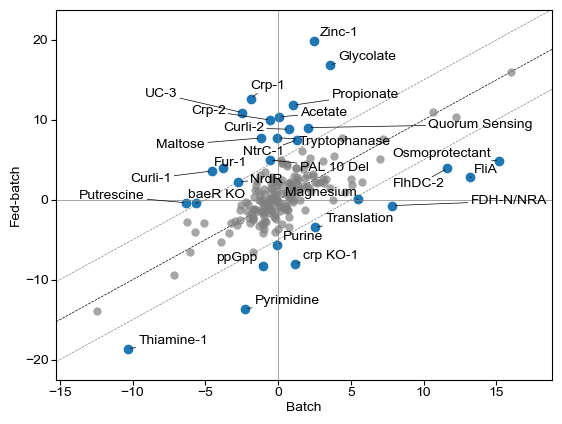

In [96]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
table

<Axes: ylabel='None'>

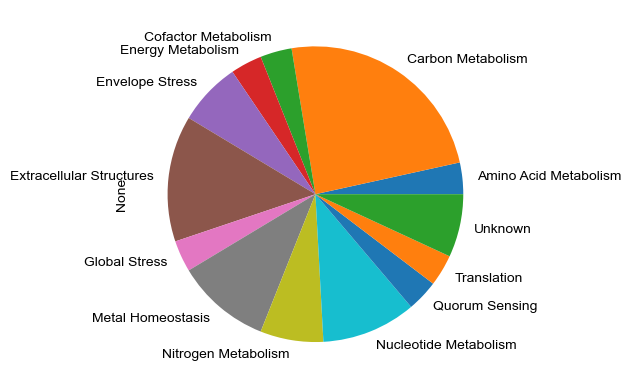

In [97]:
ica_data_p1k_with_ddb.imodulon_table.loc[table.index].groupby("functional_category").size().plot(kind="pie")

#### ddb_pd_036

In [98]:
batch_samples = hcd_sample_table[(hcd_sample_table.project == "ddb_pd_036") & (hcd_sample_table["Culture Type"] == "Batch")].index
fed_batch_samples = hcd_sample_table[(hcd_sample_table.project == "ddb_pd_036") & (hcd_sample_table["Culture Type"] == "Fed-batch")].index

difference    pvalue    qvalue          0          1
UC-3             13.232566  0.000123  0.004121  -3.566817   9.665748
Crp-1            13.080569  0.002121  0.020301  -2.483168  10.597401
Glycolate        12.739146  0.000031  0.002086   2.954983  15.694129
Acetate          12.471360  0.000044  0.002212  -1.100941  11.370419
Crp-2            12.252271  0.000834  0.009856  -3.681577   8.570694
Zinc-1           12.175128  0.000503  0.008988   5.860594  18.035722
Propionate       12.101107  0.000011  0.001591   0.149196  12.250303
Fur-1             9.226965  0.011839  0.048564  -2.889787   6.337178
Curli-1           8.980091  0.000408  0.008197  -4.733459   4.246632
Maltose           8.774588  0.003164  0.023859  -3.800560   4.974028
Tryptophanase     8.662281  0.000319  0.008003  -0.705766   7.956515
Quorum Sensing    8.540903  0.000016  0.001591  -0.335138   8.205765
Curli-2           8.186462  0.000821  0.009856   0.558000   8.744462
NtrC-1            6.629241  0.000636  0.009771   0.758162   7.387403
PAL 10 Del        6.617492  0.000151  0.004348  -0.454734   6.162758
UC-1              5.417016  0.025626  0.079244  -4.359527   1.057489
UC-8              5.411465  0.011296  0.048461   4.810347  10.221812
Phage Shock       5.060814  0.002349  0.020532   2.665625   7.726439
NtrC-2           -5.082936  0.005307  0.033333  -1.953682  -7.036617
Translation      -5.265285  0.038522  0.099269   2.854392  -2.410893
minicoli KOs     -5.420983  0.002899  0.023311   1.595862  -3.825121
LPS              -6.425076  0.055409  0.124549   1.922748  -4.502329
Magnesium        -6.949464  0.000729  0.009771   6.942732  -0.006732
crp KO-1         -8.016300  0.000715  0.009771   2.818988  -5.197312
FDH-N/NRA        -8.176430  0.005117  0.033178   7.710036  -0.466394
ppGpp            -8.769128  0.018181  0.064111   1.075301  -7.693827
Thiamine-1       -8.925104  0.000379  0.008197 -10.181378 -19.106482
Pyrimidine       -9.331731  0.002688  0.022515  -2.627983 -11.959715
Osmoprotectant  -11.854889  0.000081  0.003256  14.622058   2.767169

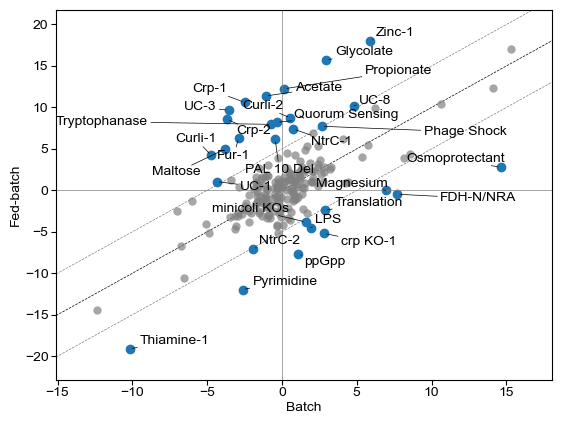

In [99]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
table

<Axes: ylabel='None'>

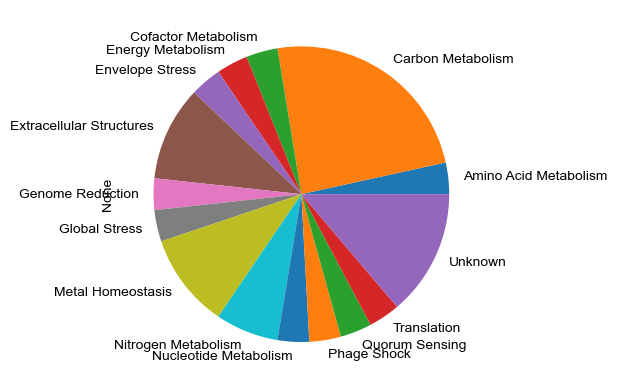

In [100]:
ica_data_p1k_with_ddb.imodulon_table.loc[table.index].groupby("functional_category").size().plot(kind="pie")

#### ddb_pd_065

In [101]:
batch_samples = hcd_sample_table[(hcd_sample_table.project == "ddb_pd_065") & (hcd_sample_table["Culture Type"] == "Batch")].index
fed_batch_samples = hcd_sample_table[(hcd_sample_table.project == "ddb_pd_065") & (hcd_sample_table["Culture Type"] == "Fed-batch")].index

difference    pvalue    qvalue          0          1
Crp-1            18.054799  0.000888  0.010495  -0.965140  17.089659
UC-3             16.843457  0.000046  0.002227  -2.327390  14.516067
Acetate          16.596824  0.000011  0.001172  -1.326762  15.270062
Crp-2            10.913261  0.001178  0.012429  -0.123272  10.789989
Propionate       10.857892  0.000020  0.001315   1.663276  12.521168
Maltose          10.451459  0.002019  0.016480  -0.216120  10.235338
Curli-2          10.362590  0.000365  0.005643   0.767248  11.129838
Glycolate        10.316399  0.000079  0.002656   3.631986  13.948385
NtrC-1            9.273181  0.000167  0.003735   0.666084   9.939265
Quorum Sensing    9.033304  0.000012  0.001172   0.805419   9.838723
Tryptophanase     8.729632  0.000309  0.005643   1.406841  10.136473
Curli-1           8.595206  0.000483  0.006065  -3.788720   4.806486
PAL 10 Del        8.121780  0.000055  0.002227  -1.409478   6.712302
ArcA              6.563651  0.014487  0.053923  -2.659610   3.904041
UC-8              6.268011  0.007863  0.033593   3.955099  10.223110
Rhamnose          6.031445  0.000466  0.006065  -0.476748   5.554697
Nitrogen          5.772772  0.000123  0.003091   0.894849   6.667622
Translation      -5.005389  0.042365  0.099017   0.012187  -4.993202
Magnesium        -5.197554  0.002050  0.016480   6.211002   1.013448
NtrC-2           -5.633083  0.003936  0.025520  -2.192840  -7.825923
ppGpp            -6.481504  0.031139  0.080242  -1.754239  -8.235742
Phosphate-2      -6.888381  0.004705  0.027013   9.423500   2.535118
Pyrimidine       -7.463506  0.004741  0.027013  -2.873156 -10.336662
FliA             -8.243195  0.003660  0.024589  11.813894   3.570699
Thiamine-1       -8.554546  0.000443  0.006065 -10.508496 -19.063042
gcvB             -8.737136  0.017164  0.058226   5.274759  -3.462377
FDH-N/NRA        -8.931175  0.004106  0.025792   8.508003  -0.423172
crp KO-1        -10.600370  0.000253  0.005087   0.877595  -9.722775
Osmoprotectant  -10.730409  0.000120  0.003091  14.320810   3.590402

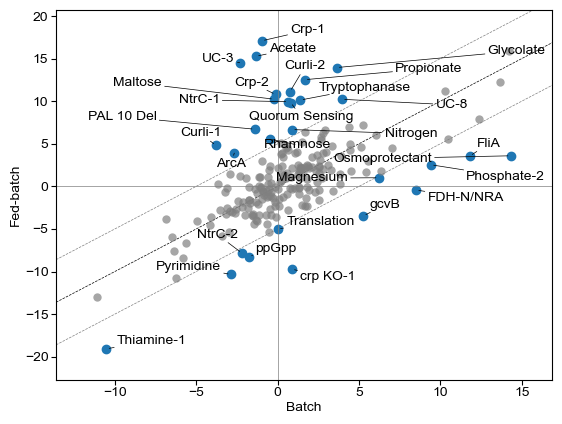

In [102]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
table

<Axes: ylabel='None'>

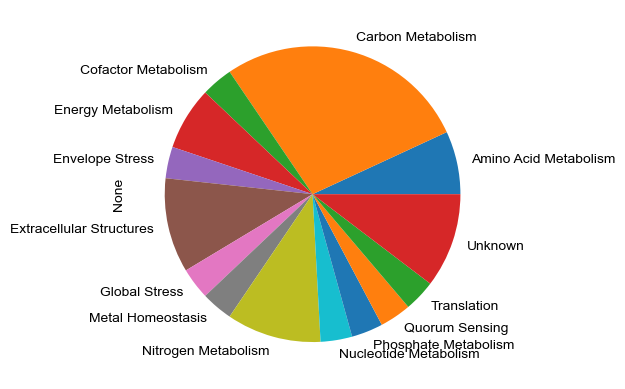

In [103]:
ica_data_p1k_with_ddb.imodulon_table.loc[table.index].groupby("functional_category").size().plot(kind="pie")

In [104]:
hcd_sample_table["Base Media"].unique()

array(['Medium C', 'DDB_BM_002', 'DDB_BM_005', 'DDB_BM_016'], dtype=object)

In [105]:
hcd_sample_table.columns

Index(['study', 'project', 'condition', 'rep_id', 'Strain Description',
       'Strain', 'Culture Type', 'Evolved Sample', 'Base Media',
       'Temperature (C)', 'pH', 'Carbon Source (g/L)', 'Nitrogen Source (g/L)',
       'Electron Acceptor', 'Trace Element Mixture', 'Supplement',
       'Antibiotic for selection', 'Growth Rate (1/hr)', 'Isolate Type',
       'Additional Details', 'project_reference', 'Sequencing Machine',
       'LibraryLayout', 'Platform', 'Biological Replicates', 'doi', 'GEO',
       'SRX', 'Run', 'R1', 'R2', 'contact', 'creator', 'passed_fastqc',
       'passed_pct_reads_mapped', 'passed_reads_mapped_to_CDS',
       'passed_global_correlation', 'full_name', 'passed_similar_replicates',
       'passed_number_replicates', 'run_date', 'n_replicates', 'sample_id',
       'Time in phase [h]', 'CTR [mol/h]', 'D-glucose consumed [cmol]',
       'OD [-]', 'base volume [ml]', 'citrate [mmol/L]', 'pyruvate [mmol/L]',
       'succinate [mmol/L]', 'formate [mmol/L]', 'lactat

### By medium

#### All Media

In [106]:
batch_samples = hcd_sample_table[hcd_sample_table["Culture Type"] == "Batch"].index
fed_batch_samples = hcd_sample_table[hcd_sample_table["Culture Type"] == "Fed-batch"].index

difference    pvalue    qvalue          0          1
Crp-1            16.017856  0.001236  0.011968  -1.594037  14.423819
UC-3             14.457333  0.000086  0.002893  -2.680725  11.776608
Acetate          12.694172  0.000041  0.002039  -0.578768  12.115404
Glycolate        12.327160  0.000036  0.002039   3.375571  15.702731
Propionate       11.869585  0.000012  0.002006   0.538821  12.408406
Zinc-1           10.863083  0.000737  0.008227   3.499070  14.362153
Crp-2            10.565145  0.001295  0.011968  -0.617434   9.947711
Maltose           9.627381  0.002499  0.018674  -1.693432   7.933949
Curli-2           9.284425  0.000536  0.007693   0.678593   9.963017
Curli-1           9.134994  0.000382  0.006949  -4.052513   5.082481
Tryptophanase     8.593495  0.000329  0.006605  -0.015307   8.578188
Quorum Sensing    8.180177  0.000020  0.002006   0.886527   9.066704
NtrC-1            7.406146  0.000415  0.006949   0.900153   8.306299
PAL 10 Del        6.742811  0.000138  0.003976  -0.454728   6.288083
Fur-1             5.253118  0.036014  0.097611  -2.922090   2.331028
UC-8              5.094656  0.013045  0.052440   4.787248   9.881905
minicoli KOs     -5.005020  0.003663  0.026294   0.354816  -4.650205
NtrC-2           -5.085632  0.005299  0.034356  -1.744261  -6.829893
Purine           -5.835767  0.012417  0.050933  -0.140091  -5.975858
FliA             -6.384793  0.006778  0.038139   7.903086   1.518293
FlhDC-2          -6.639787  0.015756  0.056551   8.232389   1.592603
Magnesium        -7.167295  0.000650  0.008163   5.920612  -1.246683
Translation      -7.340829  0.019756  0.065098   2.265646  -5.075183
Thiamine-1       -8.213442  0.000515  0.007693 -10.526568 -18.740010
ppGpp            -8.426985  0.019568  0.065098  -0.431114  -8.858099
FDH-N/NRA        -8.930960  0.004107  0.027514   8.200933  -0.730027
crp KO-1         -9.931204  0.000325  0.006605   1.472314  -8.458890
Pyrimidine      -10.393812  0.002020  0.016920  -2.376849 -12.770661
Osmoprotectant  -12.027096  0.000076  0.002893  14.526461   2.499364

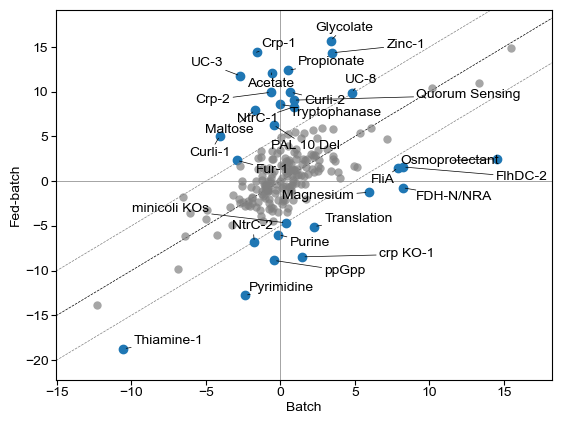

In [107]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
table

<Axes: ylabel='None'>

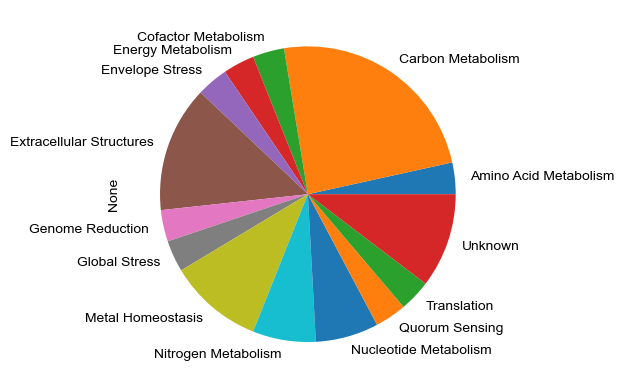

In [108]:
ica_data_p1k_with_ddb.imodulon_table.loc[table.index].groupby("functional_category").size().plot(kind="pie")

#### Medium C

In [109]:
medium_c_table = hcd_sample_table[hcd_sample_table["Base Media"] == "Medium C"]
batch_samples = medium_c_table[medium_c_table["Culture Type"] == "Batch"].index
fed_batch_samples = medium_c_table[medium_c_table["Culture Type"] == "Fed-batch"].index

difference    pvalue    qvalue          0          1
Crp-1            15.974692  0.001245  0.012011  -1.506750  14.467942
Zinc-1           15.598691  0.000212  0.004706   3.822002  19.420693
UC-3             15.104815  0.000072  0.002906  -2.525383  12.579432
Glycolate        13.626711  0.000023  0.001532   3.427129  17.053840
Propionate       12.716874  0.000009  0.001532   0.364854  13.081728
Acetate          12.318733  0.000047  0.002341  -0.248172  12.070561
Crp-2            10.680058  0.001255  0.012011   0.101665  10.781723
Maltose          10.341688  0.002075  0.016687  -1.483300   8.858387
Curli-1           9.042935  0.000397  0.005319  -3.931201   5.111734
Curli-2           8.950564  0.000607  0.007183   0.689592   9.640156
Tryptophanase     8.820599  0.000297  0.004706  -0.180968   8.639631
NtrC-1            8.135900  0.000286  0.004706   0.997718   9.133618
Quorum Sensing    8.107228  0.000021  0.001532   1.242762   9.349990
Fur-1             7.382296  0.018820  0.062013  -3.371669   4.010627
PAL 10 Del        6.280226  0.000194  0.004706  -0.216039   6.064187
Putrescine        5.470540  0.005871  0.032780  -6.337750  -0.867210
FucR/ExuR         5.449955  0.000883  0.009863   0.124364   5.574318
NrdR              5.427271  0.006396  0.033830  -2.738178   2.689093
ykgR              5.296035  0.013261  0.049360   0.894025   6.190061
Xylose            5.230435  0.000342  0.004916   0.834303   6.064737
Nitrogen          5.104445  0.000225  0.004706   0.520832   5.625277
NtrC-2           -5.348028  0.004583  0.028787  -1.574526  -6.922554
Purine           -6.108187  0.011298  0.045418  -0.108098  -6.216286
Magnesium        -6.132689  0.001151  0.012011   5.566932  -0.565757
Translation      -6.732000  0.023683  0.073446   2.667106  -4.064894
Thiamine-1       -8.105390  0.000540  0.006785 -10.626013 -18.731403
ppGpp            -8.214519  0.020504  0.065417  -0.514597  -8.729116
FliA             -8.238484  0.003665  0.025405   9.379179   1.140695
FDH-N/NRA        -9.116534  0.003898  0.026119   8.259162  -0.857371
FlhDC-2          -9.164725  0.008030  0.038431   9.612237   0.447512
crp KO-1        -10.635487  0.000250  0.004706   1.250659  -9.384829
Osmoprotectant  -10.819696  0.000116  0.003895  14.551584   3.731888
Pyrimidine      -12.109488  0.001330  0.012149  -2.183711 -14.293198

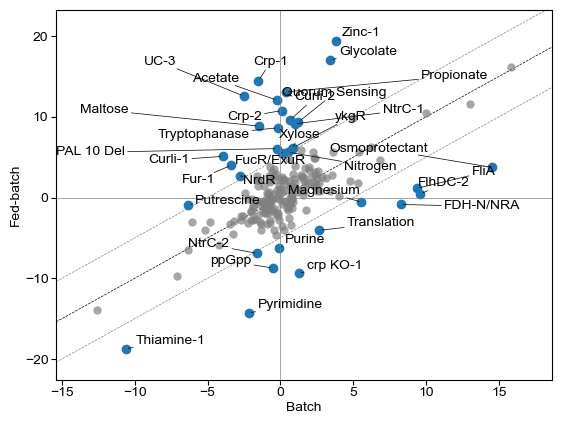

In [110]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
table

<Axes: ylabel='None'>

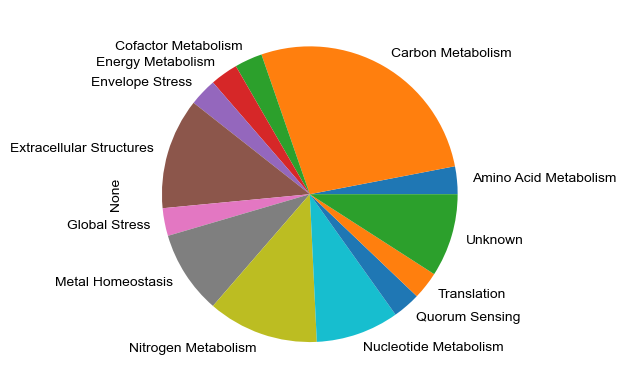

In [111]:
ica_data_p1k_with_ddb.imodulon_table.loc[table.index].groupby("functional_category").size().plot(kind="pie")

#### DDB_BM_002

In [112]:
medium_c_table = hcd_sample_table[hcd_sample_table["Base Media"] == "DDB_BM_002"]
batch_samples = medium_c_table[medium_c_table["Culture Type"] == "Batch"].index
fed_batch_samples = medium_c_table[medium_c_table["Culture Type"] == "Fed-batch"].index

difference    pvalue    qvalue          0          1
UC-3             13.232566  0.000123  0.004121  -3.566817   9.665748
Crp-1            13.080569  0.002121  0.020301  -2.483168  10.597401
Glycolate        12.739146  0.000031  0.002086   2.954983  15.694129
Acetate          12.471360  0.000044  0.002212  -1.100941  11.370419
Crp-2            12.252271  0.000834  0.009856  -3.681577   8.570694
Zinc-1           12.175128  0.000503  0.008988   5.860594  18.035722
Propionate       12.101107  0.000011  0.001591   0.149196  12.250303
Fur-1             9.226965  0.011839  0.048564  -2.889787   6.337178
Curli-1           8.980091  0.000408  0.008197  -4.733459   4.246632
Maltose           8.774588  0.003164  0.023859  -3.800560   4.974028
Tryptophanase     8.662281  0.000319  0.008003  -0.705766   7.956515
Quorum Sensing    8.540903  0.000016  0.001591  -0.335138   8.205765
Curli-2           8.186462  0.000821  0.009856   0.558000   8.744462
NtrC-1            6.629241  0.000636  0.009771   0.758162   7.387403
PAL 10 Del        6.617492  0.000151  0.004348  -0.454734   6.162758
UC-1              5.417016  0.025626  0.079244  -4.359527   1.057489
UC-8              5.411465  0.011296  0.048461   4.810347  10.221812
Phage Shock       5.060814  0.002349  0.020532   2.665625   7.726439
NtrC-2           -5.082936  0.005307  0.033333  -1.953682  -7.036617
Translation      -5.265285  0.038522  0.099269   2.854392  -2.410893
minicoli KOs     -5.420983  0.002899  0.023311   1.595862  -3.825121
LPS              -6.425076  0.055409  0.124549   1.922748  -4.502329
Magnesium        -6.949464  0.000729  0.009771   6.942732  -0.006732
crp KO-1         -8.016300  0.000715  0.009771   2.818988  -5.197312
FDH-N/NRA        -8.176430  0.005117  0.033178   7.710036  -0.466394
ppGpp            -8.769128  0.018181  0.064111   1.075301  -7.693827
Thiamine-1       -8.925104  0.000379  0.008197 -10.181378 -19.106482
Pyrimidine       -9.331731  0.002688  0.022515  -2.627983 -11.959715
Osmoprotectant  -11.854889  0.000081  0.003256  14.622058   2.767169

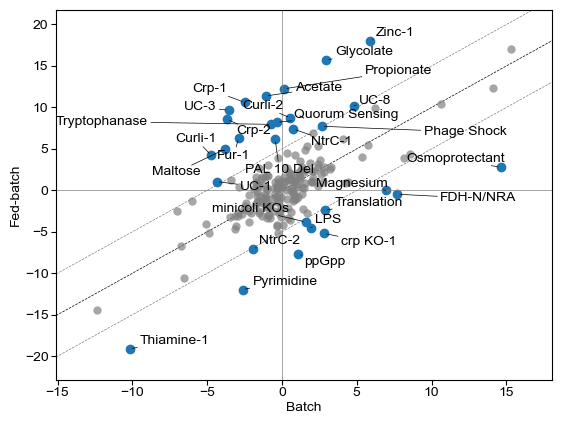

In [113]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
table

<Axes: ylabel='None'>

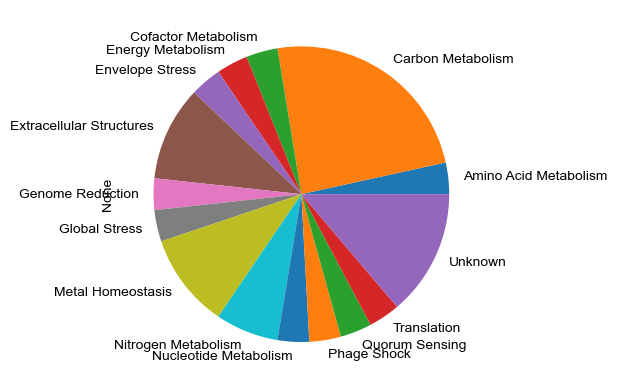

In [114]:
ica_data_p1k_with_ddb.imodulon_table.loc[table.index].groupby("functional_category").size().plot(kind="pie")

#### DDB_BM_005

In [115]:
medium_c_table = hcd_sample_table[hcd_sample_table["Base Media"] == "DDB_BM_005"]
batch_samples = medium_c_table[medium_c_table["Culture Type"] == "Batch"].index
fed_batch_samples = medium_c_table[medium_c_table["Culture Type"] == "Fed-batch"].index

difference    pvalue    qvalue          0          1
Crp-1            18.054799  0.000888  0.010495  -0.965140  17.089659
UC-3             16.843457  0.000046  0.002227  -2.327390  14.516067
Acetate          16.596824  0.000011  0.001172  -1.326762  15.270062
Crp-2            10.913261  0.001178  0.012429  -0.123272  10.789989
Propionate       10.857892  0.000020  0.001315   1.663276  12.521168
Maltose          10.451459  0.002019  0.016480  -0.216120  10.235338
Curli-2          10.362590  0.000365  0.005643   0.767248  11.129838
Glycolate        10.316399  0.000079  0.002656   3.631986  13.948385
NtrC-1            9.273181  0.000167  0.003735   0.666084   9.939265
Quorum Sensing    9.033304  0.000012  0.001172   0.805419   9.838723
Tryptophanase     8.729632  0.000309  0.005643   1.406841  10.136473
Curli-1           8.595206  0.000483  0.006065  -3.788720   4.806486
PAL 10 Del        8.121780  0.000055  0.002227  -1.409478   6.712302
ArcA              6.563651  0.014487  0.053923  -2.659610   3.904041
UC-8              6.268011  0.007863  0.033593   3.955099  10.223110
Rhamnose          6.031445  0.000466  0.006065  -0.476748   5.554697
Nitrogen          5.772772  0.000123  0.003091   0.894849   6.667622
Translation      -5.005389  0.042365  0.099017   0.012187  -4.993202
Magnesium        -5.197554  0.002050  0.016480   6.211002   1.013448
NtrC-2           -5.633083  0.003936  0.025520  -2.192840  -7.825923
ppGpp            -6.481504  0.031139  0.080242  -1.754239  -8.235742
Phosphate-2      -6.888381  0.004705  0.027013   9.423500   2.535118
Pyrimidine       -7.463506  0.004741  0.027013  -2.873156 -10.336662
FliA             -8.243195  0.003660  0.024589  11.813894   3.570699
Thiamine-1       -8.554546  0.000443  0.006065 -10.508496 -19.063042
gcvB             -8.737136  0.017164  0.058226   5.274759  -3.462377
FDH-N/NRA        -8.931175  0.004106  0.025792   8.508003  -0.423172
crp KO-1        -10.600370  0.000253  0.005087   0.877595  -9.722775
Osmoprotectant  -10.730409  0.000120  0.003091  14.320810   3.590402

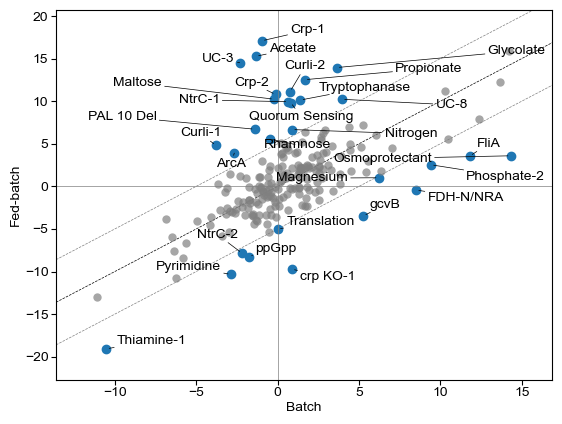

In [116]:
sample_1 = batch_samples
sample_2 = fed_batch_samples

ax, table = plot_dima(
    ica_data_p1k_with_ddb,
    sample_1,
    sample_2,
    fdr=1,
    threshold=5,
    line45_margin=5,
    table=True
)

plt.xlabel("Batch")
plt.ylabel("Fed-batch")
table

<Axes: ylabel='None'>

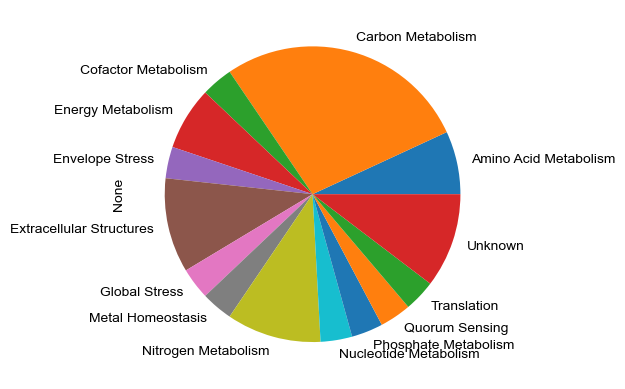

In [117]:
ica_data_p1k_with_ddb.imodulon_table.loc[table.index].groupby("functional_category").size().plot(kind="pie")

## Growth phase stimulons

In [118]:
violet1 = mpl.colors.to_hex(mpl.cm.PRGn(0))
green1 = mpl.colors.to_hex(mpl.cm.PRGn(254))

violet2 = mpl.colors.to_hex(mpl.cm.PiYG(0))
green2 = mpl.colors.to_hex(mpl.cm.PiYG(254))

blue1 = mpl.colors.to_hex(mpl.cm.bwr(0))
red1 = mpl.colors.to_hex(mpl.cm.bwr(254))

blue2 = mpl.colors.to_hex(mpl.cm.coolwarm(0))
red2 = mpl.colors.to_hex(mpl.cm.coolwarm(254))

cmap1 = mpl.colors.LinearSegmentedColormap.from_list(
    name="custom", 
    colors=[(0,blue2), (0.25,"white"), (0.75,"white"), (1,red2)],
    N=20
)

cmap2 = mpl.colors.LinearSegmentedColormap.from_list(
    name="custom", 
    colors=[(0,green2), (0.25,"white"), (0.75,"white"), (1,violet2)],
    N=20
)

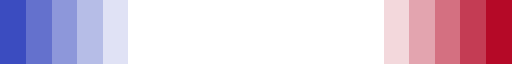

In [119]:
cmap1

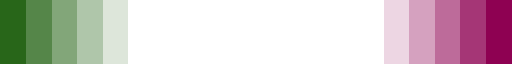

In [120]:
cmap2

### Sample correlation

In [121]:
iMs = ica_data_p1k_with_ddb.A.index
samples = hcd_sample_table.index

In [122]:
A_filtered = ica_data_p1k_with_ddb.A.loc[iMs][samples]

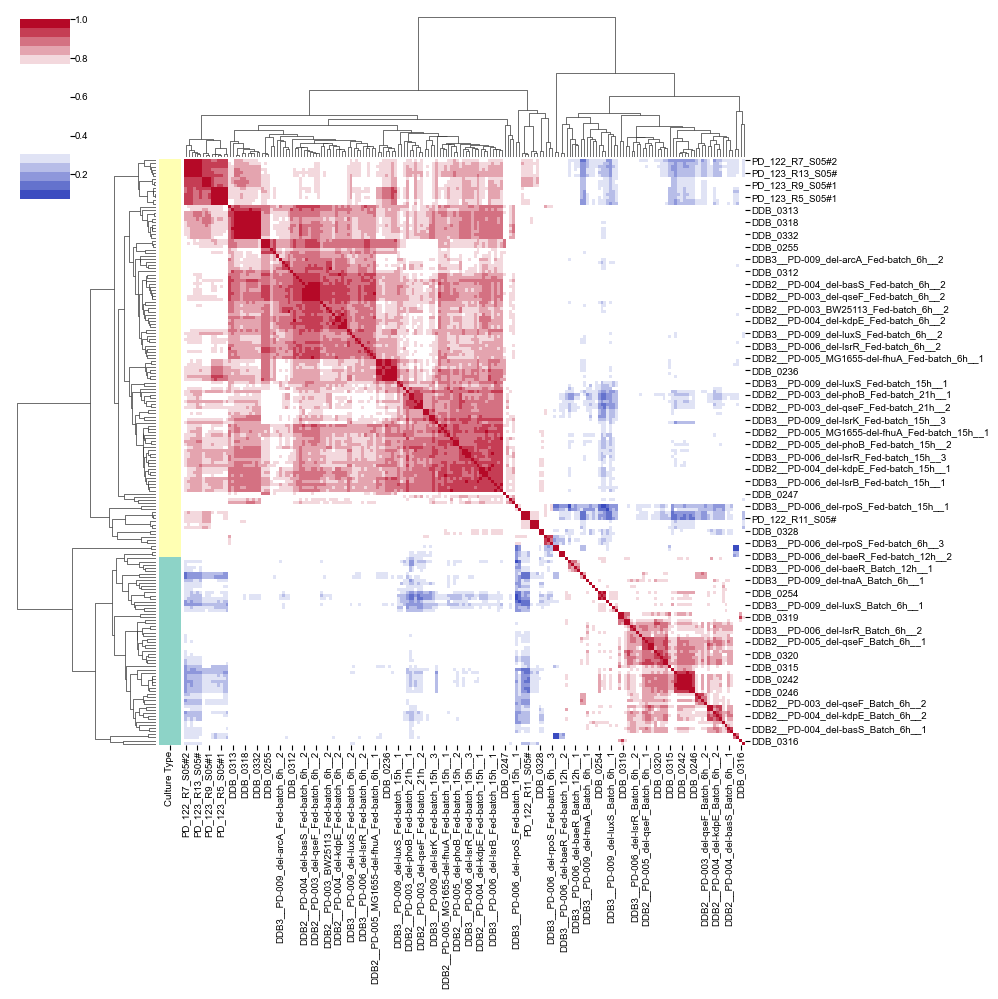

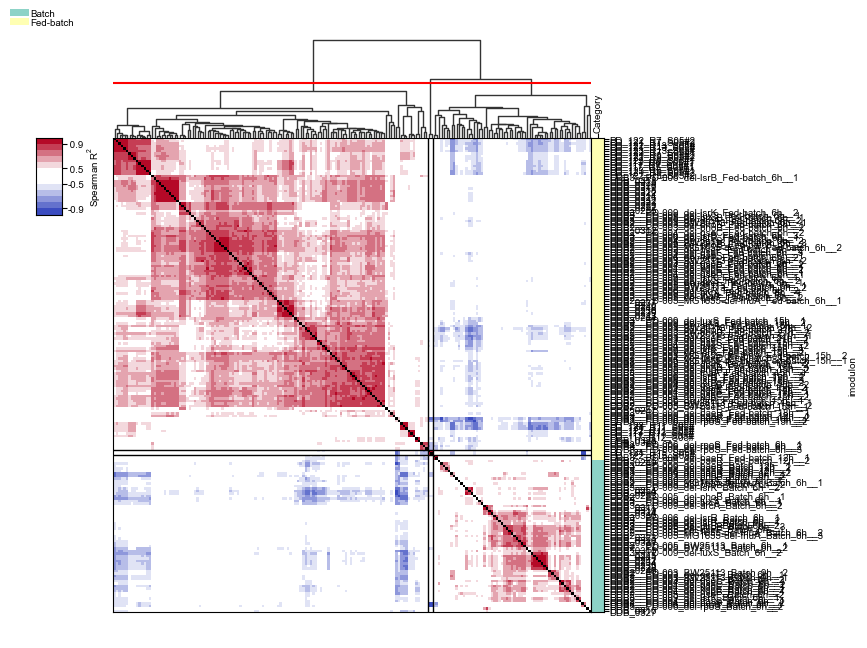

In [123]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

A_corr = A_filtered.corr(method="spearman")
clustered_df = A_corr

### Color definition for the iM categories
cmap = cm.get_cmap(name="Set3")
category = ica_data_p1k_with_ddb.sample_table.loc[list(A_corr.index)]["Culture Type"]

row_palette = dict(zip(category.unique(), [cmap(x) for x in range(0,len(category.unique()))]))
row_colors = category.map(row_palette)


g = sns.clustermap(
    data = clustered_df,
    cmap=cmap1,
    row_colors=row_colors
)

row_labels = list(clustered_df.iloc[g.dendrogram_row.reordered_ind].index)
col_labels = list(clustered_df.T.iloc[g.dendrogram_col.reordered_ind].index)

heatmap_df = clustered_df.loc[row_labels].T
heatmap_df = heatmap_df.loc[col_labels].T

fig = plt.figure(figsize=(53/6,49/6))
spec = fig.add_gridspec(nrows=49, ncols=53)

frame_ax = fig.add_subplot(spec[:,:])
main_ax = fig.add_subplot(spec[10:47,8:45])
dn_col_ax = fig.add_subplot(spec[2:10,8:45])
iM_cat_ax = fig.add_subplot(spec[10:47,45])
cbar_ax = fig.add_subplot(spec[10:16,2:4])

plt.subplots_adjust(hspace=0, wspace=0)

# ### Plot Heatmap
# ################

# sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar_ax=cbar_ax,cbar=True)
sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar=False)

main_ax.yaxis.set_label_position("right")
main_ax.yaxis.tick_right()
main_ax.set_yticklabels([])
main_ax.set_xticklabels([])
main_ax.set_yticks([])
main_ax.set_xticks([])

main_ax.spines[["top","bottom","right","left"]].set_visible(True)

for idx in range(0,len(clustered_df)):
    r = plt.Rectangle(width=1,height=1,xy=(idx,idx),facecolor="k")
    main_ax.add_patch(r)

### Plot Categories
###################   

iM_cat_ax.yaxis.set_label_position("right")
iM_cat_ax.yaxis.tick_right()
iM_cat_ax.set_ylabel("imodulon")

iM_cat_ax.xaxis.set_label_position("top")
iM_cat_ax.xaxis.tick_top()

iM_cat_ax.set_xticks([0.5])
iM_cat_ax.set_xticklabels(["Category"], rotation = 90)
iM_cat_ax.set_yticks(np.arange(0.5,len(row_labels),1))
iM_cat_ax.set_yticklabels(row_labels)

iM_cat_ax.set_ylim(0,len(row_labels))
iM_cat_ax.set_xlim(0,1)

row_color_list = [g.row_colors[i] for i in g.dendrogram_row.reordered_ind]


for i in range(0, len(row_color_list)):
    rectangle = plt.Rectangle((0,i), 1, 1, fc=row_color_list[i])
    iM_cat_ax.add_patch(rectangle)
    # iM_cat_ax.vlines(x=i,ymin=0,ymax=1, colors="k",linewidth=0.7)
    # iM_cat_ax.vlines(x=len(row_color_list),ymin=0,ymax=1, colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=0,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=1,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    
iM_cat_ax.invert_yaxis()
    
    
cat_df = category.drop_duplicates().reset_index()
cat_df.sort_values("Culture Type", inplace=True)
    
legend_labels = list(cat_df["Culture Type"])
    
legend_elements = []
for i, cat in cat_df.itertuples(index=False):
    legend_elements.append((Patch(facecolor=row_colors.loc[i], edgecolor=None)))
    
frame_ax.legend(
    legend_elements, 
    legend_labels, 
    fancybox=False,
    bbox_to_anchor=(0,1),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.1,
    labelspacing = 0,
    # title='Category:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
)

### Plot Colorbar
#################

norm = mpl.colors.Normalize(vmin=0, vmax=1)

r = plt.Rectangle(xy=(0,0),width=1,height=0.08, facecolor=cmap1(norm(0.025)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.08),width=1,height=0.08, facecolor=cmap1(norm(0.075)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.16),width=1,height=0.08, facecolor=cmap1(norm(0.125)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.24),width=1,height=0.08, facecolor=cmap1(norm(0.175)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.32),width=1,height=0.08, facecolor=cmap1(norm(0.225)))
cbar_ax.add_patch(r)


r = plt.Rectangle(xy=(0,0.6),width=1,height=0.08, facecolor=cmap1(norm(0.775)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.68),width=1,height=0.08, facecolor=cmap1(norm(0.825)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.76),width=1,height=0.08, facecolor=cmap1(norm(0.875)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.84),width=1,height=0.08, facecolor=cmap1(norm(0.925)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.92),width=1,height=0.08, facecolor=cmap1(norm(0.975)))
cbar_ax.add_patch(r)


cbar_ax.yaxis.set_label_position("right")
cbar_ax.yaxis.tick_right()
cbar_ax.set_yticks([0.08,0.4,0.6,0.92])
cbar_ax.set_yticklabels(["-0.9","-0.5"," 0.5"," 0.9"])
cbar_ax.set_ylabel("Spearman R$^{2}$")
cbar_ax.set_xticks([])


# ### Plot Dendrogram
# ###################

g.dendrogram_col.plot(ax=dn_col_ax,tree_kws={"linewidth":1})

thr = 3

d = dendrogram(
    Z = g.dendrogram_col.linkage,
    color_threshold = thr,
    no_plot=True
);

x0 = dn_col_ax.get_xlim()[0]
x1 = dn_col_ax.get_xlim()[1]

dn_col_ax.hlines(y=thr,xmin=x0,xmax=x1,colors="red",linestyles="-")

dn_col_ax.spines[["top","bottom","right","left"]].set_visible(False)
dn_col_ax.set_xticks([])
dn_col_ax.set_yticks([]);

# # ### Draw cluster lines into the clustermap based on dengrogram threshold
# # ########################################################################

leaves_color_list = list(map(str, d["leaves_color_list"]))
counter = 1
line_list = []

for idx in range(0,len(leaves_color_list)-1):

    if leaves_color_list[idx] != leaves_color_list[counter]:
        
        line_list.append(counter)
        
    counter = counter+1

y0 = main_ax.get_ylim()[0]
y1 = main_ax.get_ylim()[1]
x0 = main_ax.get_xlim()[0]
x1 = main_ax.get_xlim()[1]

for line_id in line_list:

    main_ax.vlines(x=line_id, ymin = y0, ymax= y1, colors="k", linewidths=1)
    main_ax.hlines(y=line_id, xmin = x0, xmax= x1, colors="k", linewidths=1)
    
frame_ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
frame_ax.set_yticks([])
frame_ax.set_xticks([]);

In [124]:
clusters_df = pd.DataFrame()
clusters_df["label"] = row_labels
clusters_df["cluster"] = leaves_color_list

In [125]:
clusters_df

label cluster
0                      PD_122_R7_S05#2      C1
1                      PD_121_R7_S05#2      C1
2                      PD_122_R13_S05#      C1
3                      PD_121_R13_S05#      C1
4                      PD_123_R13_S05#      C1
..                                 ...     ...
185  DDB2__PD-004_del-basS_Batch_6h__2      C3
186  DDB3__PD-006_del-rpoS_Batch_9h__1      C3
187  DDB3__PD-006_del-rpoS_Batch_9h__2      C3
188                           DDB_0316      C3
189                           DDB_0327      C3

[190 rows x 2 columns]

### Sample correlation (selected iMs)

In [126]:
iMs = dima_table.index
samples = hcd_sample_table.index

In [127]:
A_filtered = ica_data_p1k_with_ddb.A.loc[iMs][samples]

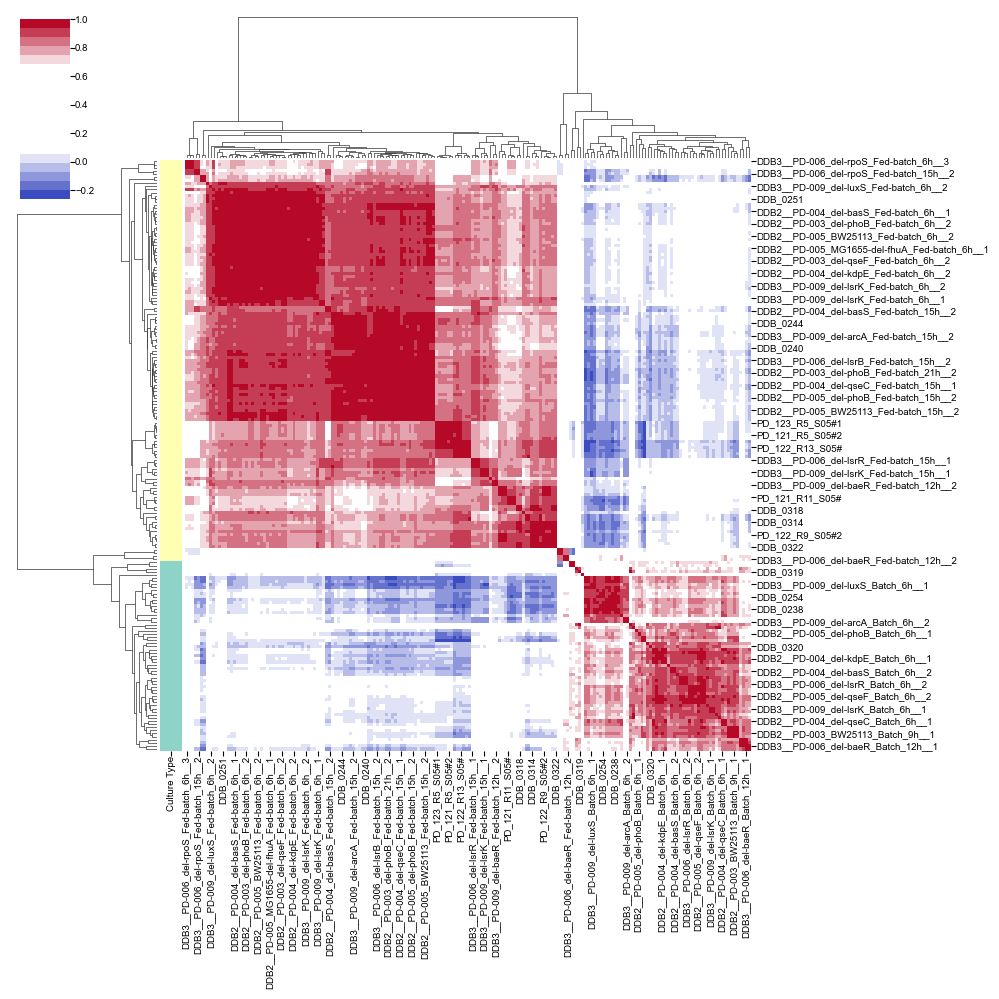

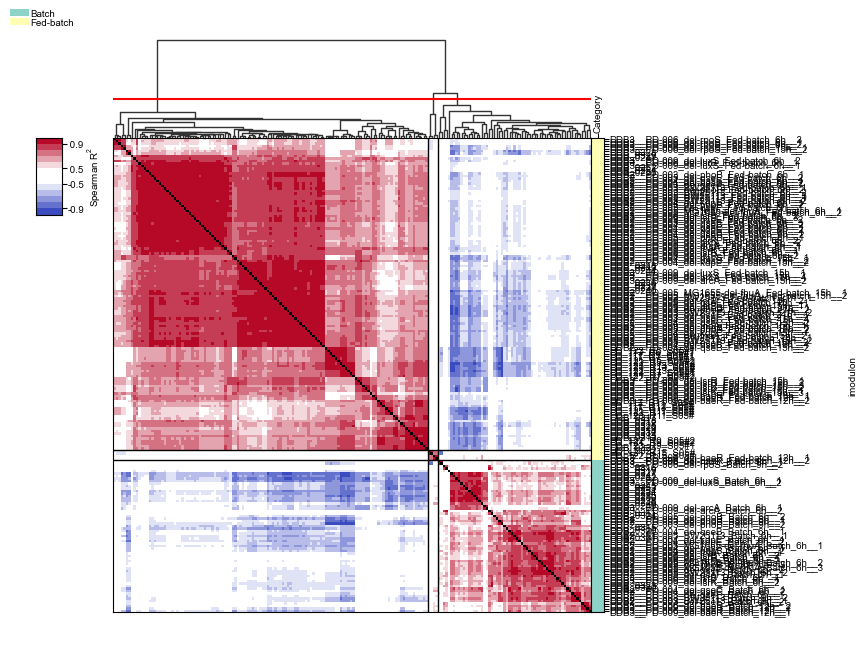

In [128]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

A_corr = A_filtered.corr(method="spearman")
clustered_df = A_corr

### Color definition for the iM categories
cmap = cm.get_cmap(name="Set3")
category = ica_data_p1k_with_ddb.sample_table.loc[list(A_corr.index)]["Culture Type"]

row_palette = dict(zip(category.unique(), [cmap(x) for x in range(0,len(category.unique()))]))
row_colors = category.map(row_palette)


g = sns.clustermap(
    data = clustered_df,
    cmap=cmap1,
    row_colors=row_colors
)

row_labels = list(clustered_df.iloc[g.dendrogram_row.reordered_ind].index)
col_labels = list(clustered_df.T.iloc[g.dendrogram_col.reordered_ind].index)

heatmap_df = clustered_df.loc[row_labels].T
heatmap_df = heatmap_df.loc[col_labels].T

fig = plt.figure(figsize=(53/6,49/6))
spec = fig.add_gridspec(nrows=49, ncols=53)

frame_ax = fig.add_subplot(spec[:,:])
main_ax = fig.add_subplot(spec[10:47,8:45])
dn_col_ax = fig.add_subplot(spec[2:10,8:45])
iM_cat_ax = fig.add_subplot(spec[10:47,45])
cbar_ax = fig.add_subplot(spec[10:16,2:4])

plt.subplots_adjust(hspace=0, wspace=0)

# ### Plot Heatmap
# ################

# sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar_ax=cbar_ax,cbar=True)
sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar=False)

main_ax.yaxis.set_label_position("right")
main_ax.yaxis.tick_right()
main_ax.set_yticklabels([])
main_ax.set_xticklabels([])
main_ax.set_yticks([])
main_ax.set_xticks([])

main_ax.spines[["top","bottom","right","left"]].set_visible(True)

for idx in range(0,len(clustered_df)):
    r = plt.Rectangle(width=1,height=1,xy=(idx,idx),facecolor="k")
    main_ax.add_patch(r)

### Plot Categories
###################   

iM_cat_ax.yaxis.set_label_position("right")
iM_cat_ax.yaxis.tick_right()
iM_cat_ax.set_ylabel("imodulon")

iM_cat_ax.xaxis.set_label_position("top")
iM_cat_ax.xaxis.tick_top()

iM_cat_ax.set_xticks([0.5])
iM_cat_ax.set_xticklabels(["Category"], rotation = 90)
iM_cat_ax.set_yticks(np.arange(0.5,len(row_labels),1))
iM_cat_ax.set_yticklabels(row_labels)

iM_cat_ax.set_ylim(0,len(row_labels))
iM_cat_ax.set_xlim(0,1)

row_color_list = [g.row_colors[i] for i in g.dendrogram_row.reordered_ind]


for i in range(0, len(row_color_list)):
    rectangle = plt.Rectangle((0,i), 1, 1, fc=row_color_list[i])
    iM_cat_ax.add_patch(rectangle)
    # iM_cat_ax.vlines(x=i,ymin=0,ymax=1, colors="k",linewidth=0.7)
    # iM_cat_ax.vlines(x=len(row_color_list),ymin=0,ymax=1, colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=0,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=1,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    
iM_cat_ax.invert_yaxis()
    
    
cat_df = category.drop_duplicates().reset_index()
cat_df.sort_values("Culture Type", inplace=True)
    
legend_labels = list(cat_df["Culture Type"])
    
legend_elements = []
for i, cat in cat_df.itertuples(index=False):
    legend_elements.append((Patch(facecolor=row_colors.loc[i], edgecolor=None)))
    
frame_ax.legend(
    legend_elements, 
    legend_labels, 
    fancybox=False,
    bbox_to_anchor=(0,1),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.1,
    labelspacing = 0,
    # title='Category:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
)

### Plot Colorbar
#################

norm = mpl.colors.Normalize(vmin=0, vmax=1)

r = plt.Rectangle(xy=(0,0),width=1,height=0.08, facecolor=cmap1(norm(0.025)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.08),width=1,height=0.08, facecolor=cmap1(norm(0.075)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.16),width=1,height=0.08, facecolor=cmap1(norm(0.125)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.24),width=1,height=0.08, facecolor=cmap1(norm(0.175)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.32),width=1,height=0.08, facecolor=cmap1(norm(0.225)))
cbar_ax.add_patch(r)


r = plt.Rectangle(xy=(0,0.6),width=1,height=0.08, facecolor=cmap1(norm(0.775)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.68),width=1,height=0.08, facecolor=cmap1(norm(0.825)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.76),width=1,height=0.08, facecolor=cmap1(norm(0.875)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.84),width=1,height=0.08, facecolor=cmap1(norm(0.925)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.92),width=1,height=0.08, facecolor=cmap1(norm(0.975)))
cbar_ax.add_patch(r)


cbar_ax.yaxis.set_label_position("right")
cbar_ax.yaxis.tick_right()
cbar_ax.set_yticks([0.08,0.4,0.6,0.92])
cbar_ax.set_yticklabels(["-0.9","-0.5"," 0.5"," 0.9"])
cbar_ax.set_ylabel("Spearman R$^{2}$")
cbar_ax.set_xticks([])


# ### Plot Dendrogram
# ###################

g.dendrogram_col.plot(ax=dn_col_ax,tree_kws={"linewidth":1})

thr = 4

d = dendrogram(
    Z = g.dendrogram_col.linkage,
    color_threshold = thr,
    no_plot=True
);

x0 = dn_col_ax.get_xlim()[0]
x1 = dn_col_ax.get_xlim()[1]

dn_col_ax.hlines(y=thr,xmin=x0,xmax=x1,colors="red",linestyles="-")

dn_col_ax.spines[["top","bottom","right","left"]].set_visible(False)
dn_col_ax.set_xticks([])
dn_col_ax.set_yticks([]);

# # ### Draw cluster lines into the clustermap based on dengrogram threshold
# # ########################################################################

leaves_color_list = list(map(str, d["leaves_color_list"]))
counter = 1
line_list = []

for idx in range(0,len(leaves_color_list)-1):

    if leaves_color_list[idx] != leaves_color_list[counter]:
        
        line_list.append(counter)
        
    counter = counter+1

y0 = main_ax.get_ylim()[0]
y1 = main_ax.get_ylim()[1]
x0 = main_ax.get_xlim()[0]
x1 = main_ax.get_xlim()[1]

for line_id in line_list:

    main_ax.vlines(x=line_id, ymin = y0, ymax= y1, colors="k", linewidths=1)
    main_ax.hlines(y=line_id, xmin = x0, xmax= x1, colors="k", linewidths=1)
    
frame_ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
frame_ax.set_yticks([])
frame_ax.set_xticks([]);

In [129]:
clusters_df = pd.DataFrame()
clusters_df["label"] = row_labels
clusters_df["cluster"] = leaves_color_list

In [130]:
clusters_df

label cluster
0     DDB3__PD-006_del-rpoS_Fed-batch_6h__3      C1
1     DDB3__PD-006_del-rpoS_Fed-batch_6h__1      C1
2     DDB3__PD-006_del-rpoS_Fed-batch_6h__2      C1
3    DDB3__PD-006_del-rpoS_Fed-batch_15h__1      C1
4    DDB3__PD-006_del-rpoS_Fed-batch_15h__2      C1
..                                      ...     ...
185       DDB2__PD-003_del-qseF_Batch_6h__2      C3
186      DDB3__PD-006_del-baeR_Batch_12h__2      C3
187      DDB3__PD-009_del-baeR_Batch_12h__2      C3
188      DDB3__PD-006_del-baeR_Batch_12h__1      C3
189      DDB3__PD-009_del-baeR_Batch_12h__1      C3

[190 rows x 2 columns]

### iModulon correlation

In [131]:
iMs = ica_data_p1k_with_ddb.A.index
samples = hcd_sample_table.index

In [132]:
A_filtered = ica_data_p1k_with_ddb.A.loc[iMs][samples]

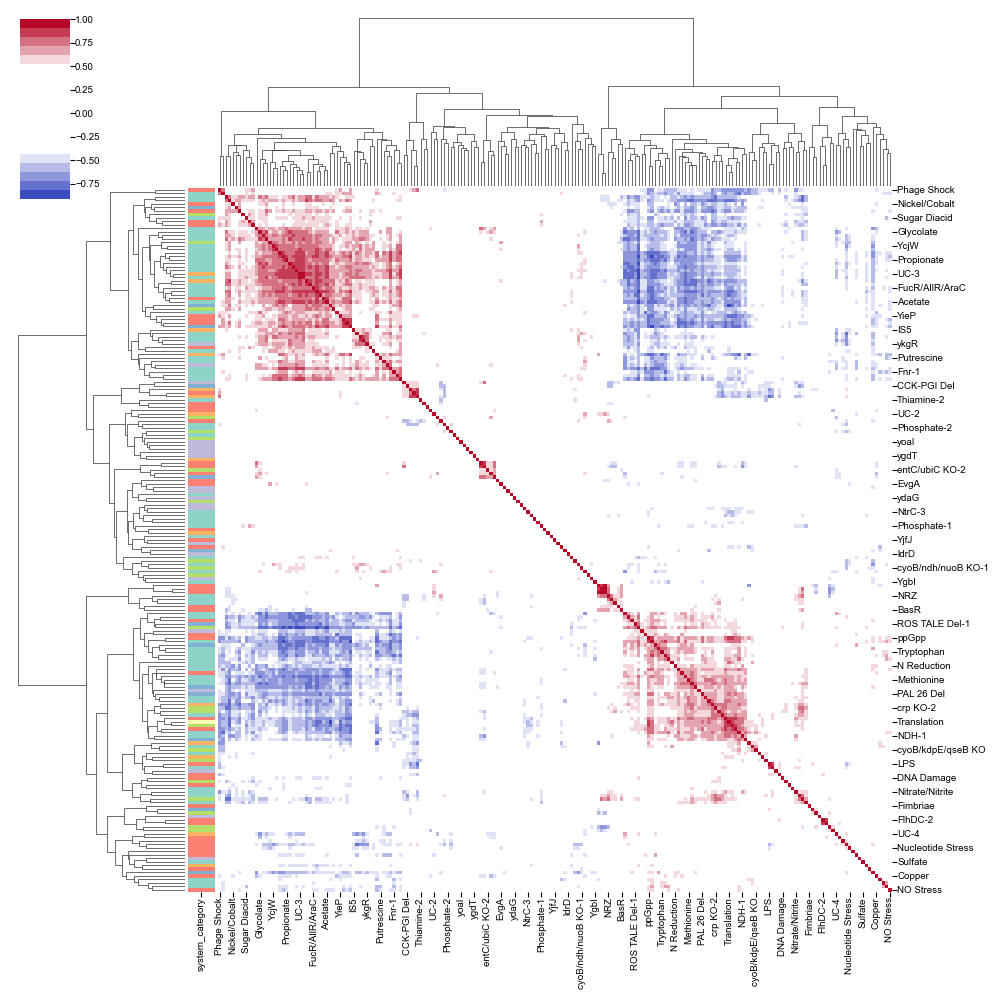

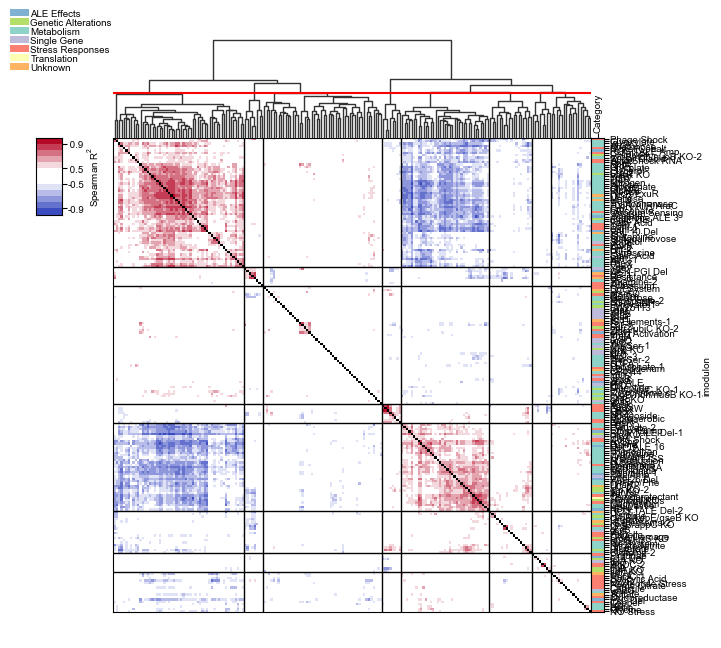

In [133]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

A_corr = A_filtered.T.corr(method="spearman")
clustered_df = A_corr

### Color definition for the iM categories
cmap = cm.get_cmap(name="Set3")
category = ica_data_p1k_with_ddb.imodulon_table.loc[list(A_corr.index)]["system_category"]

row_palette = dict(zip(category.unique(), [cmap(x) for x in range(0,len(category.unique()))]))
row_colors = category.map(row_palette)


g = sns.clustermap(
    data = clustered_df,
    cmap=cmap1,
    row_colors=row_colors
)

row_labels = list(clustered_df.iloc[g.dendrogram_row.reordered_ind].index)
col_labels = list(clustered_df.T.iloc[g.dendrogram_col.reordered_ind].index)

heatmap_df = clustered_df.loc[row_labels].T
heatmap_df = heatmap_df.loc[col_labels].T

fig = plt.figure(figsize=(53/6,49/6))
spec = fig.add_gridspec(nrows=49, ncols=53)

frame_ax = fig.add_subplot(spec[:,:])
main_ax = fig.add_subplot(spec[10:47,8:45])
dn_col_ax = fig.add_subplot(spec[2:10,8:45])
iM_cat_ax = fig.add_subplot(spec[10:47,45])
cbar_ax = fig.add_subplot(spec[10:16,2:4])

plt.subplots_adjust(hspace=0, wspace=0)

# ### Plot Heatmap
# ################

# sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar_ax=cbar_ax,cbar=True)
sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar=False)

main_ax.yaxis.set_label_position("right")
main_ax.yaxis.tick_right()
main_ax.set_yticklabels([])
main_ax.set_xticklabels([])
main_ax.set_yticks([])
main_ax.set_xticks([])

main_ax.spines[["top","bottom","right","left"]].set_visible(True)

for idx in range(0,len(clustered_df)):
    r = plt.Rectangle(width=1,height=1,xy=(idx,idx),facecolor="k")
    main_ax.add_patch(r)

### Plot Categories
###################   

iM_cat_ax.yaxis.set_label_position("right")
iM_cat_ax.yaxis.tick_right()
iM_cat_ax.set_ylabel("imodulon")

iM_cat_ax.xaxis.set_label_position("top")
iM_cat_ax.xaxis.tick_top()

iM_cat_ax.set_xticks([0.5])
iM_cat_ax.set_xticklabels(["Category"], rotation = 90)
iM_cat_ax.set_yticks(np.arange(0.5,len(row_labels),1))
iM_cat_ax.set_yticklabels(row_labels)

iM_cat_ax.set_ylim(0,len(row_labels))
iM_cat_ax.set_xlim(0,1)

row_color_list = [g.row_colors[i] for i in g.dendrogram_row.reordered_ind]


for i in range(0, len(row_color_list)):
    rectangle = plt.Rectangle((0,i), 1, 1, fc=row_color_list[i])
    iM_cat_ax.add_patch(rectangle)
    # iM_cat_ax.vlines(x=i,ymin=0,ymax=1, colors="k",linewidth=0.7)
    # iM_cat_ax.vlines(x=len(row_color_list),ymin=0,ymax=1, colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=0,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=1,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    
iM_cat_ax.invert_yaxis()
    
    
cat_df = category.drop_duplicates().reset_index()
cat_df.sort_values("system_category", inplace=True)
    
legend_labels = list(cat_df["system_category"])
    
legend_elements = []
for i, cat in cat_df.itertuples(index=False):
    legend_elements.append((Patch(facecolor=row_colors.loc[i], edgecolor=None)))
    
frame_ax.legend(
    legend_elements, 
    legend_labels, 
    fancybox=False,
    bbox_to_anchor=(0,1),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.1,
    labelspacing = 0,
    # title='Category:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
)

### Plot Colorbar
#################

norm = mpl.colors.Normalize(vmin=0, vmax=1)

r = plt.Rectangle(xy=(0,0),width=1,height=0.08, facecolor=cmap1(norm(0.025)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.08),width=1,height=0.08, facecolor=cmap1(norm(0.075)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.16),width=1,height=0.08, facecolor=cmap1(norm(0.125)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.24),width=1,height=0.08, facecolor=cmap1(norm(0.175)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.32),width=1,height=0.08, facecolor=cmap1(norm(0.225)))
cbar_ax.add_patch(r)


r = plt.Rectangle(xy=(0,0.6),width=1,height=0.08, facecolor=cmap1(norm(0.775)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.68),width=1,height=0.08, facecolor=cmap1(norm(0.825)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.76),width=1,height=0.08, facecolor=cmap1(norm(0.875)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.84),width=1,height=0.08, facecolor=cmap1(norm(0.925)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.92),width=1,height=0.08, facecolor=cmap1(norm(0.975)))
cbar_ax.add_patch(r)


cbar_ax.yaxis.set_label_position("right")
cbar_ax.yaxis.tick_right()
cbar_ax.set_yticks([0.08,0.4,0.6,0.92])
cbar_ax.set_yticklabels(["-0.9","-0.5"," 0.5"," 0.9"])
cbar_ax.set_ylabel("Spearman R$^{2}$")
cbar_ax.set_xticks([])


# ### Plot Dendrogram
# ###################

g.dendrogram_col.plot(ax=dn_col_ax,tree_kws={"linewidth":1})

thr = 4

d = dendrogram(
    Z = g.dendrogram_col.linkage,
    color_threshold = thr,
    no_plot=True
);

x0 = dn_col_ax.get_xlim()[0]
x1 = dn_col_ax.get_xlim()[1]

dn_col_ax.hlines(y=thr,xmin=x0,xmax=x1,colors="red",linestyles="-")

dn_col_ax.spines[["top","bottom","right","left"]].set_visible(False)
dn_col_ax.set_xticks([])
dn_col_ax.set_yticks([]);

# # ### Draw cluster lines into the clustermap based on dengrogram threshold
# # ########################################################################

leaves_color_list = list(map(str, d["leaves_color_list"]))
counter = 1
line_list = []

for idx in range(0,len(leaves_color_list)-1):

    if leaves_color_list[idx] != leaves_color_list[counter]:
        
        line_list.append(counter)
        
    counter = counter+1

y0 = main_ax.get_ylim()[0]
y1 = main_ax.get_ylim()[1]
x0 = main_ax.get_xlim()[0]
x1 = main_ax.get_xlim()[1]

for line_id in line_list:

    main_ax.vlines(x=line_id, ymin = y0, ymax= y1, colors="k", linewidths=1)
    main_ax.hlines(y=line_id, xmin = x0, xmax= x1, colors="k", linewidths=1)
    
frame_ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
frame_ax.set_yticks([])
frame_ax.set_xticks([]);

In [134]:
clusters_df = pd.DataFrame()
clusters_df["label"] = row_labels
clusters_df["cluster"] = leaves_color_list

In [135]:
clusters_df

label cluster
0      Phage Shock      C1
1       Glyoxylate      C1
2             ArcA      C1
3         Rhamnose      C1
4    Nickel/Cobalt      C1
..             ...     ...
196         Copper      C8
197            Lrp      C8
198         Biotin      C8
199        Glycine      C8
200      NO Stress      C8

[201 rows x 2 columns]

### iModulon correlation (selected iMs) - among hcd samples

In [136]:
iMs = dima_table_w_tps.index
samples = hcd_sample_table.index

In [137]:
A_filtered = ica_data_p1k_with_ddb.A.loc[iMs][samples]

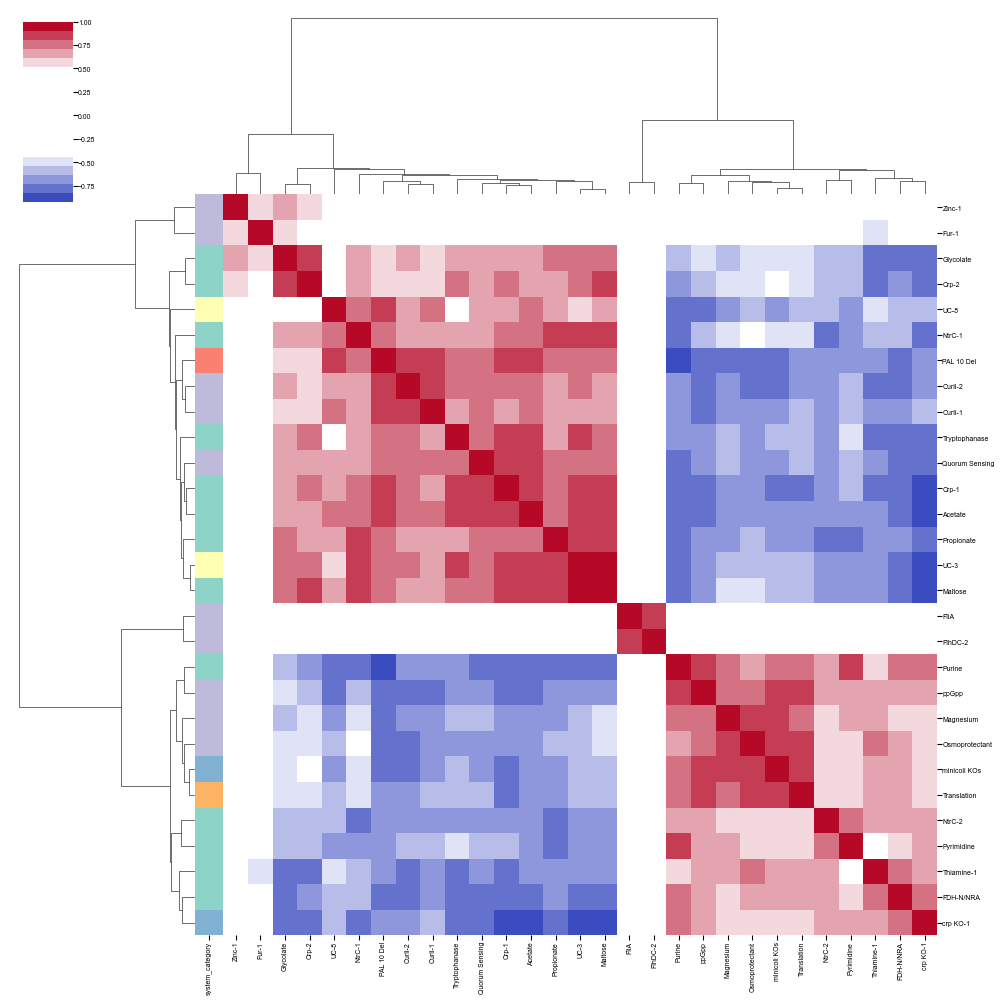

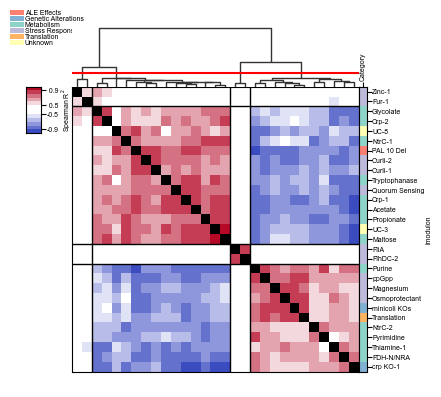

In [138]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# formatting
plt.rcParams['font.size'] = 5
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

A_corr = A_filtered.T.corr(method="spearman")
clustered_df = A_corr

### Color definition for the iM categories
cmap = cm.get_cmap(name="Set3")
category = ica_data_p1k_with_ddb.imodulon_table.loc[list(A_corr.index)]["system_category"]

row_palette = dict(zip(category.unique(), [cmap(x) for x in range(0,len(category.unique()))]))
row_colors = category.map(row_palette)


g = sns.clustermap(
    data = clustered_df,
    cmap=cmap1,
    row_colors=row_colors
)

row_labels = list(clustered_df.iloc[g.dendrogram_row.reordered_ind].index)
col_labels = list(clustered_df.T.iloc[g.dendrogram_col.reordered_ind].index)

heatmap_df = clustered_df.loc[row_labels].T
heatmap_df = heatmap_df.loc[col_labels].T

fig = plt.figure(figsize=(53/10,49/10))
spec = fig.add_gridspec(nrows=49, ncols=53)

frame_ax = fig.add_subplot(spec[:,:])
main_ax = fig.add_subplot(spec[10:47,8:45])
dn_col_ax = fig.add_subplot(spec[2:10,8:45])
iM_cat_ax = fig.add_subplot(spec[10:47,45])
cbar_ax = fig.add_subplot(spec[10:16,2:4])

plt.subplots_adjust(hspace=0, wspace=0)

# ### Plot Heatmap
# ################

# sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar_ax=cbar_ax,cbar=True)
sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar=False)

main_ax.yaxis.set_label_position("right")
main_ax.yaxis.tick_right()
main_ax.set_yticklabels([])
main_ax.set_xticklabels([])
main_ax.set_yticks([])
main_ax.set_xticks([])

main_ax.spines[["top","bottom","right","left"]].set_visible(True)

for idx in range(0,len(clustered_df)):
    r = plt.Rectangle(width=1,height=1,xy=(idx,idx),facecolor="k")
    main_ax.add_patch(r)

### Plot Categories
###################   

iM_cat_ax.yaxis.set_label_position("right")
iM_cat_ax.yaxis.tick_right()
iM_cat_ax.set_ylabel("imodulon")

iM_cat_ax.xaxis.set_label_position("top")
iM_cat_ax.xaxis.tick_top()

iM_cat_ax.set_xticks([0.5])
iM_cat_ax.set_xticklabels(["Category"], rotation = 90)
iM_cat_ax.set_yticks(np.arange(0.5,len(row_labels),1))
iM_cat_ax.set_yticklabels(row_labels)

iM_cat_ax.set_ylim(0,len(row_labels))
iM_cat_ax.set_xlim(0,1)

row_color_list = [g.row_colors[i] for i in g.dendrogram_row.reordered_ind]


for i in range(0, len(row_color_list)):
    rectangle = plt.Rectangle((0,i), 1, 1, fc=row_color_list[i])
    iM_cat_ax.add_patch(rectangle)
    # iM_cat_ax.vlines(x=i,ymin=0,ymax=1, colors="k",linewidth=0.7)
    # iM_cat_ax.vlines(x=len(row_color_list),ymin=0,ymax=1, colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=0,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=1,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    
iM_cat_ax.invert_yaxis()
    
    
cat_df = category.drop_duplicates().reset_index()
cat_df.sort_values("system_category", inplace=True)
    
legend_labels = list(cat_df["system_category"])
    
legend_elements = []
for i, cat in cat_df.itertuples(index=False):
    legend_elements.append((Patch(facecolor=row_colors.loc[i], edgecolor=None)))
    
frame_ax.legend(
    legend_elements, 
    legend_labels, 
    fancybox=False,
    bbox_to_anchor=(0,1),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.1,
    labelspacing = 0,
    # title='Category:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
)

### Plot Colorbar
#################

norm = mpl.colors.Normalize(vmin=0, vmax=1)

r = plt.Rectangle(xy=(0,0),width=1,height=0.08, facecolor=cmap1(norm(0.025)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.08),width=1,height=0.08, facecolor=cmap1(norm(0.075)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.16),width=1,height=0.08, facecolor=cmap1(norm(0.125)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.24),width=1,height=0.08, facecolor=cmap1(norm(0.175)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.32),width=1,height=0.08, facecolor=cmap1(norm(0.225)))
cbar_ax.add_patch(r)


r = plt.Rectangle(xy=(0,0.6),width=1,height=0.08, facecolor=cmap1(norm(0.775)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.68),width=1,height=0.08, facecolor=cmap1(norm(0.825)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.76),width=1,height=0.08, facecolor=cmap1(norm(0.875)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.84),width=1,height=0.08, facecolor=cmap1(norm(0.925)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.92),width=1,height=0.08, facecolor=cmap1(norm(0.975)))
cbar_ax.add_patch(r)


cbar_ax.yaxis.set_label_position("right")
cbar_ax.yaxis.tick_right()
cbar_ax.set_yticks([0.08,0.4,0.6,0.92])
cbar_ax.set_yticklabels(["-0.9","-0.5"," 0.5"," 0.9"])
cbar_ax.set_ylabel("Spearman R$^{2}$")
cbar_ax.set_xticks([])


# ### Plot Dendrogram
# ###################

g.dendrogram_col.plot(ax=dn_col_ax,tree_kws={"linewidth":1})

thr = 1.5

d = dendrogram(
    Z = g.dendrogram_col.linkage,
    color_threshold = thr,
    no_plot=True
);

x0 = dn_col_ax.get_xlim()[0]
x1 = dn_col_ax.get_xlim()[1]

dn_col_ax.hlines(y=thr,xmin=x0,xmax=x1,colors="red",linestyles="-")

dn_col_ax.spines[["top","bottom","right","left"]].set_visible(False)
dn_col_ax.set_xticks([])
dn_col_ax.set_yticks([]);

# # ### Draw cluster lines into the clustermap based on dengrogram threshold
# # ########################################################################

leaves_color_list = list(map(str, d["leaves_color_list"]))
counter = 1
line_list = []

for idx in range(0,len(leaves_color_list)-1):

    if leaves_color_list[idx] != leaves_color_list[counter]:
        
        line_list.append(counter)
        
    counter = counter+1

y0 = main_ax.get_ylim()[0]
y1 = main_ax.get_ylim()[1]
x0 = main_ax.get_xlim()[0]
x1 = main_ax.get_xlim()[1]

for line_id in line_list:

    main_ax.vlines(x=line_id, ymin = y0, ymax= y1, colors="k", linewidths=1)
    main_ax.hlines(y=line_id, xmin = x0, xmax= x1, colors="k", linewidths=1)
    
frame_ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
frame_ax.set_yticks([])
frame_ax.set_xticks([]);

# plt.savefig("cluster_test.svg", dpi=900)

In [152]:
clusters_df = pd.DataFrame()
clusters_df["label"] = row_labels
clusters_df["cluster"] = leaves_color_list

In [153]:
cluster_iMs = clusters_df[clusters_df["cluster"] == "C1"]["label"].values
ica_data_p1k_with_ddb.M_binarized[cluster_iMs].sum().sort_values(ascending=False)

Fur-1     32.0
Zinc-1    14.0
dtype: float64

In [154]:
clusters_df[clusters_df["cluster"] == "C1"]["label"].values

array(['Zinc-1', 'Fur-1'], dtype=object)

In [155]:
cluster_iMs = clusters_df[clusters_df["cluster"] == "C2"]["label"].values
ica_data_p1k_with_ddb.M_binarized[cluster_iMs].sum().sort_values(ascending=False)

PAL 10 Del        108.0
Crp-1              61.0
UC-3               51.0
Crp-2              21.0
NtrC-1             18.0
Quorum Sensing     10.0
UC-8                9.0
Maltose             9.0
Acetate             7.0
Glycolate           6.0
Curli-1             6.0
Curli-2             5.0
Propionate          4.0
Tryptophanase       2.0
dtype: float64

In [156]:
cluster_iMs = clusters_df[clusters_df["cluster"] == "C3"]["label"].values
ica_data_p1k_with_ddb.M_binarized[cluster_iMs].sum().sort_values(ascending=False)

FlhDC-2    43.0
FliA       37.0
dtype: float64

In [157]:
cluster_iMs = clusters_df[clusters_df["cluster"] == "C4"]["label"].values
ica_data_p1k_with_ddb.M_binarized[cluster_iMs].sum().sort_values(ascending=False)

minicoli KOs      115.0
ppGpp              70.0
Translation        53.0
crp KO-1           24.0
Purine             22.0
Magnesium          21.0
FDH-N/NRA          15.0
Pyrimidine         13.0
NtrC-2             10.0
Thiamine-1          9.0
Osmoprotectant      4.0
dtype: float64

### iModulon correlation (selected iMs) - among hcd and p1K samples

In [158]:
iMs = dima_table.index
samples = hcd_sample_table.index

In [159]:
A_filtered = ica_data_p1k_with_ddb.A.loc[iMs]

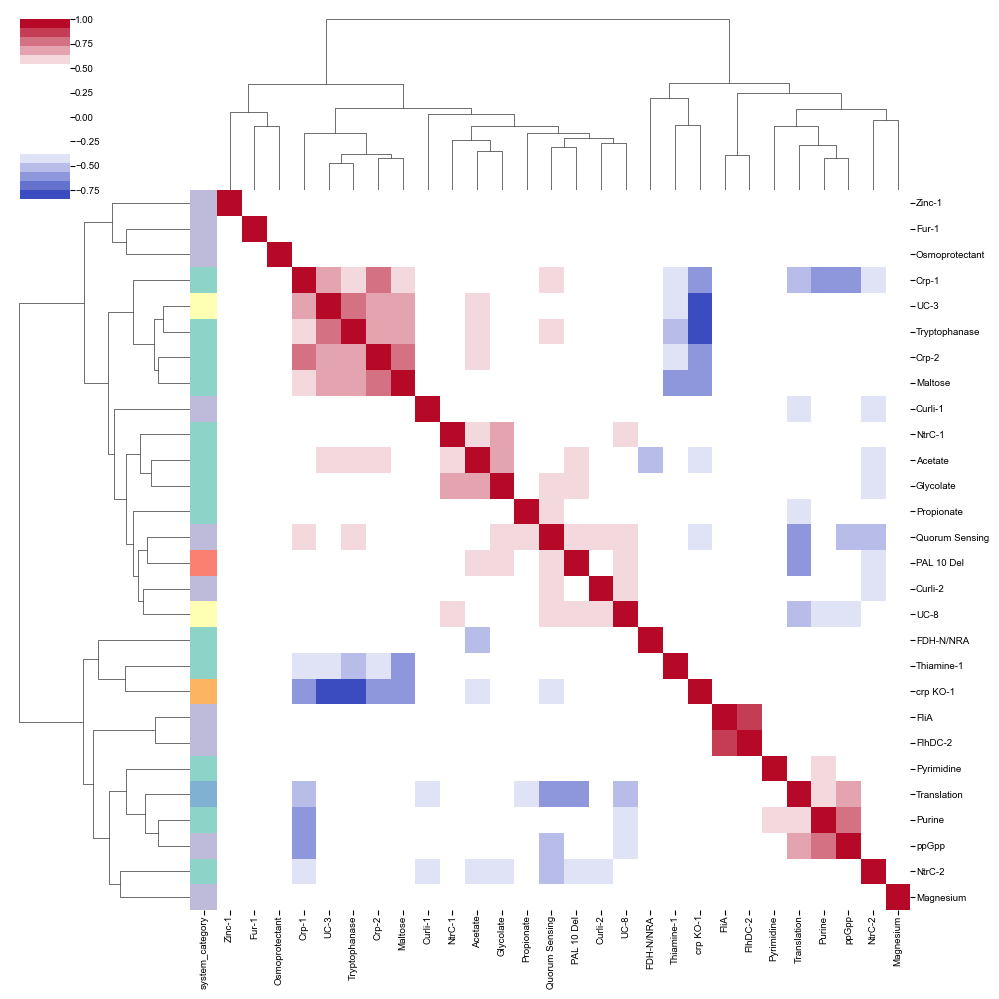

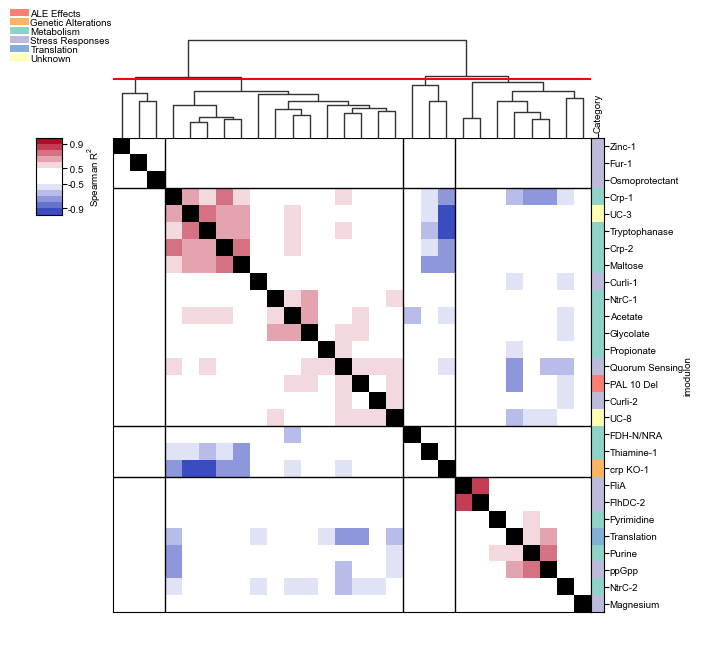

In [160]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

A_corr = A_filtered.T.corr(method="spearman")
clustered_df = A_corr

### Color definition for the iM categories
cmap = cm.get_cmap(name="Set3")
category = ica_data_p1k_with_ddb.imodulon_table.loc[list(A_corr.index)]["system_category"]

row_palette = dict(zip(category.unique(), [cmap(x) for x in range(0,len(category.unique()))]))
row_colors = category.map(row_palette)


g = sns.clustermap(
    data = clustered_df,
    cmap=cmap1,
    row_colors=row_colors
)

row_labels = list(clustered_df.iloc[g.dendrogram_row.reordered_ind].index)
col_labels = list(clustered_df.T.iloc[g.dendrogram_col.reordered_ind].index)

heatmap_df = clustered_df.loc[row_labels].T
heatmap_df = heatmap_df.loc[col_labels].T

fig = plt.figure(figsize=(53/6,49/6))
spec = fig.add_gridspec(nrows=49, ncols=53)

frame_ax = fig.add_subplot(spec[:,:])
main_ax = fig.add_subplot(spec[10:47,8:45])
dn_col_ax = fig.add_subplot(spec[2:10,8:45])
iM_cat_ax = fig.add_subplot(spec[10:47,45])
cbar_ax = fig.add_subplot(spec[10:16,2:4])

plt.subplots_adjust(hspace=0, wspace=0)

# ### Plot Heatmap
# ################

# sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar_ax=cbar_ax,cbar=True)
sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar=False)

main_ax.yaxis.set_label_position("right")
main_ax.yaxis.tick_right()
main_ax.set_yticklabels([])
main_ax.set_xticklabels([])
main_ax.set_yticks([])
main_ax.set_xticks([])

main_ax.spines[["top","bottom","right","left"]].set_visible(True)

for idx in range(0,len(clustered_df)):
    r = plt.Rectangle(width=1,height=1,xy=(idx,idx),facecolor="k")
    main_ax.add_patch(r)

### Plot Categories
###################   

iM_cat_ax.yaxis.set_label_position("right")
iM_cat_ax.yaxis.tick_right()
iM_cat_ax.set_ylabel("imodulon")

iM_cat_ax.xaxis.set_label_position("top")
iM_cat_ax.xaxis.tick_top()

iM_cat_ax.set_xticks([0.5])
iM_cat_ax.set_xticklabels(["Category"], rotation = 90)
iM_cat_ax.set_yticks(np.arange(0.5,len(row_labels),1))
iM_cat_ax.set_yticklabels(row_labels)

iM_cat_ax.set_ylim(0,len(row_labels))
iM_cat_ax.set_xlim(0,1)

row_color_list = [g.row_colors[i] for i in g.dendrogram_row.reordered_ind]


for i in range(0, len(row_color_list)):
    rectangle = plt.Rectangle((0,i), 1, 1, fc=row_color_list[i])
    iM_cat_ax.add_patch(rectangle)
    # iM_cat_ax.vlines(x=i,ymin=0,ymax=1, colors="k",linewidth=0.7)
    # iM_cat_ax.vlines(x=len(row_color_list),ymin=0,ymax=1, colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=0,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=1,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    
iM_cat_ax.invert_yaxis()
    
    
cat_df = category.drop_duplicates().reset_index()
cat_df.sort_values("system_category", inplace=True)
    
legend_labels = list(cat_df["system_category"])
    
legend_elements = []
for i, cat in cat_df.itertuples(index=False):
    legend_elements.append((Patch(facecolor=row_colors.loc[i], edgecolor=None)))
    
frame_ax.legend(
    legend_elements, 
    legend_labels, 
    fancybox=False,
    bbox_to_anchor=(0,1),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.1,
    labelspacing = 0,
    # title='Category:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
)

### Plot Colorbar
#################

norm = mpl.colors.Normalize(vmin=0, vmax=1)

r = plt.Rectangle(xy=(0,0),width=1,height=0.08, facecolor=cmap1(norm(0.025)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.08),width=1,height=0.08, facecolor=cmap1(norm(0.075)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.16),width=1,height=0.08, facecolor=cmap1(norm(0.125)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.24),width=1,height=0.08, facecolor=cmap1(norm(0.175)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.32),width=1,height=0.08, facecolor=cmap1(norm(0.225)))
cbar_ax.add_patch(r)


r = plt.Rectangle(xy=(0,0.6),width=1,height=0.08, facecolor=cmap1(norm(0.775)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.68),width=1,height=0.08, facecolor=cmap1(norm(0.825)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.76),width=1,height=0.08, facecolor=cmap1(norm(0.875)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.84),width=1,height=0.08, facecolor=cmap1(norm(0.925)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.92),width=1,height=0.08, facecolor=cmap1(norm(0.975)))
cbar_ax.add_patch(r)


cbar_ax.yaxis.set_label_position("right")
cbar_ax.yaxis.tick_right()
cbar_ax.set_yticks([0.08,0.4,0.6,0.92])
cbar_ax.set_yticklabels(["-0.9","-0.5"," 0.5"," 0.9"])
cbar_ax.set_ylabel("Spearman R$^{2}$")
cbar_ax.set_xticks([])


# ### Plot Dendrogram
# ###################

g.dendrogram_col.plot(ax=dn_col_ax,tree_kws={"linewidth":1})

thr = 2

d = dendrogram(
    Z = g.dendrogram_col.linkage,
    color_threshold = thr,
    no_plot=True
);

x0 = dn_col_ax.get_xlim()[0]
x1 = dn_col_ax.get_xlim()[1]

dn_col_ax.hlines(y=thr,xmin=x0,xmax=x1,colors="red",linestyles="-")

dn_col_ax.spines[["top","bottom","right","left"]].set_visible(False)
dn_col_ax.set_xticks([])
dn_col_ax.set_yticks([]);

# # ### Draw cluster lines into the clustermap based on dengrogram threshold
# # ########################################################################

leaves_color_list = list(map(str, d["leaves_color_list"]))
counter = 1
line_list = []

for idx in range(0,len(leaves_color_list)-1):

    if leaves_color_list[idx] != leaves_color_list[counter]:
        
        line_list.append(counter)
        
    counter = counter+1

y0 = main_ax.get_ylim()[0]
y1 = main_ax.get_ylim()[1]
x0 = main_ax.get_xlim()[0]
x1 = main_ax.get_xlim()[1]

for line_id in line_list:

    main_ax.vlines(x=line_id, ymin = y0, ymax= y1, colors="k", linewidths=1)
    main_ax.hlines(y=line_id, xmin = x0, xmax= x1, colors="k", linewidths=1)
    
frame_ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
frame_ax.set_yticks([])
frame_ax.set_xticks([]);

In [161]:
clusters_df = pd.DataFrame()
clusters_df["label"] = row_labels
clusters_df["cluster"] = leaves_color_list

In [162]:
clusters_df

label cluster
0           Zinc-1      C1
1            Fur-1      C1
2   Osmoprotectant      C1
3            Crp-1      C2
4             UC-3      C2
5    Tryptophanase      C2
6            Crp-2      C2
7          Maltose      C2
8          Curli-1      C2
9           NtrC-1      C2
10         Acetate      C2
11       Glycolate      C2
12      Propionate      C2
13  Quorum Sensing      C2
14      PAL 10 Del      C2
15         Curli-2      C2
16            UC-8      C2
17       FDH-N/NRA      C3
18      Thiamine-1      C3
19        crp KO-1      C3
20            FliA      C4
21         FlhDC-2      C4
22      Pyrimidine      C4
23     Translation      C4
24          Purine      C4
25           ppGpp      C4
26          NtrC-2      C4
27       Magnesium      C4

### iModulon correlation (selected iMs from separate strain DiMAs) - among hcd samples

In [163]:
iMs = separate_strain_iMs
samples = hcd_sample_table.index

In [164]:
A_filtered = ica_data_p1k_with_ddb.A.loc[iMs][samples]

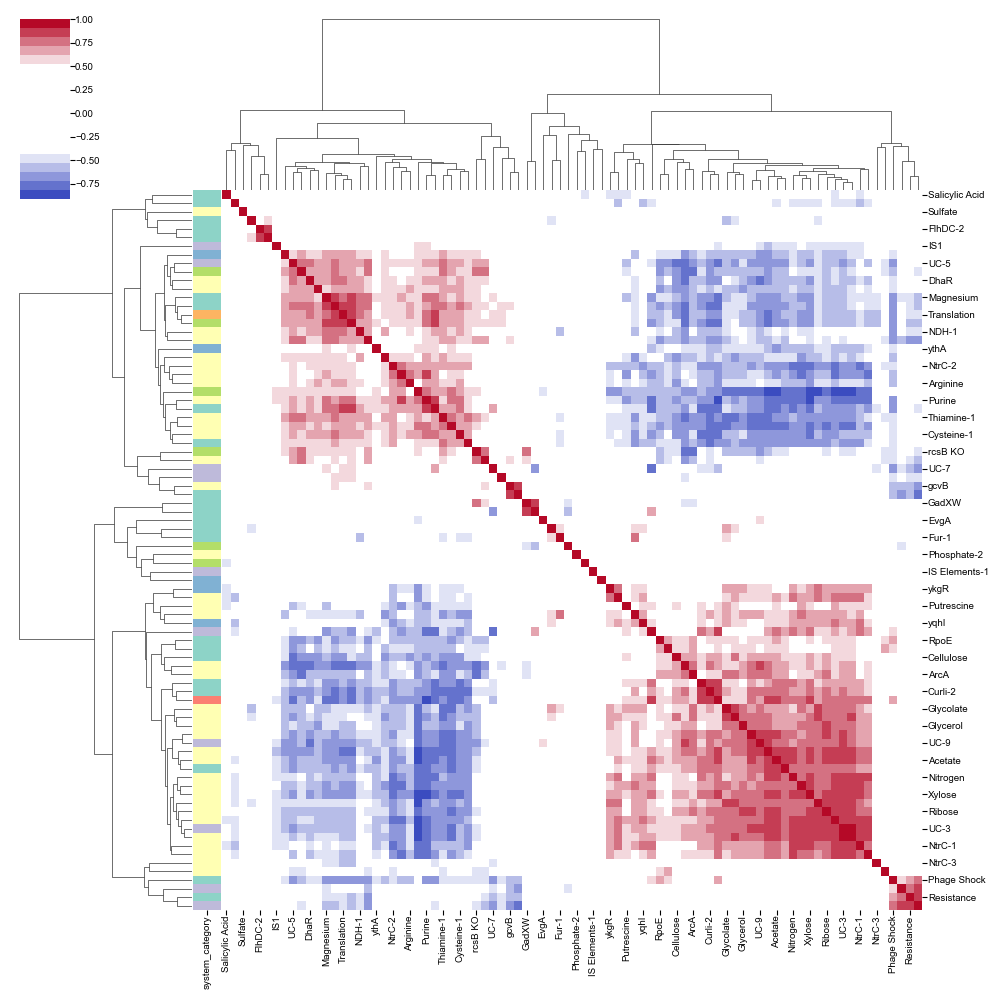

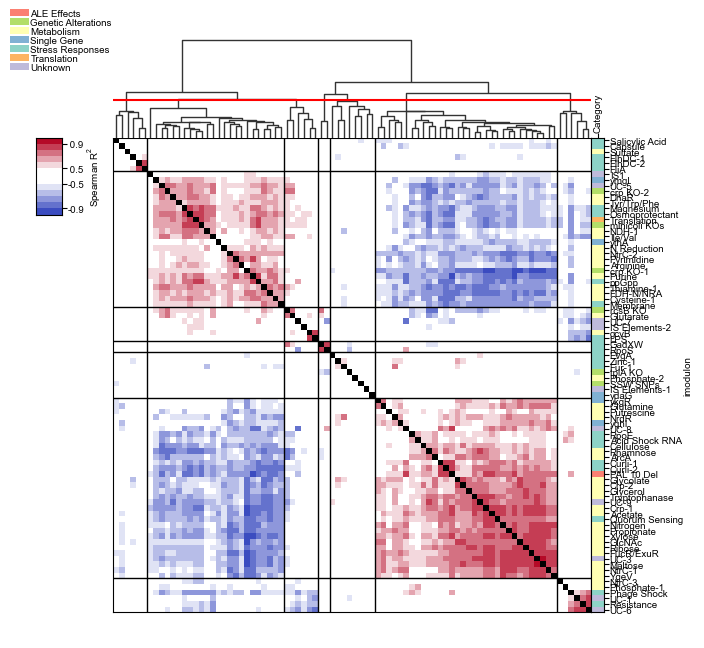

In [165]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

A_corr = A_filtered.T.corr(method="spearman")
clustered_df = A_corr

### Color definition for the iM categories
cmap = cm.get_cmap(name="Set3")
category = ica_data_p1k_with_ddb.imodulon_table.loc[list(A_corr.index)]["system_category"]

row_palette = dict(zip(category.unique(), [cmap(x) for x in range(0,len(category.unique()))]))
row_colors = category.map(row_palette)


g = sns.clustermap(
    data = clustered_df,
    cmap=cmap1,
    row_colors=row_colors
)

row_labels = list(clustered_df.iloc[g.dendrogram_row.reordered_ind].index)
col_labels = list(clustered_df.T.iloc[g.dendrogram_col.reordered_ind].index)

heatmap_df = clustered_df.loc[row_labels].T
heatmap_df = heatmap_df.loc[col_labels].T

fig = plt.figure(figsize=(53/6,49/6))
spec = fig.add_gridspec(nrows=49, ncols=53)

frame_ax = fig.add_subplot(spec[:,:])
main_ax = fig.add_subplot(spec[10:47,8:45])
dn_col_ax = fig.add_subplot(spec[2:10,8:45])
iM_cat_ax = fig.add_subplot(spec[10:47,45])
cbar_ax = fig.add_subplot(spec[10:16,2:4])

plt.subplots_adjust(hspace=0, wspace=0)

# ### Plot Heatmap
# ################

# sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar_ax=cbar_ax,cbar=True)
sns.heatmap(heatmap_df, ax=main_ax, cmap=cmap1, linewidths=0,cbar=False)

main_ax.yaxis.set_label_position("right")
main_ax.yaxis.tick_right()
main_ax.set_yticklabels([])
main_ax.set_xticklabels([])
main_ax.set_yticks([])
main_ax.set_xticks([])

main_ax.spines[["top","bottom","right","left"]].set_visible(True)

for idx in range(0,len(clustered_df)):
    r = plt.Rectangle(width=1,height=1,xy=(idx,idx),facecolor="k")
    main_ax.add_patch(r)

### Plot Categories
###################   

iM_cat_ax.yaxis.set_label_position("right")
iM_cat_ax.yaxis.tick_right()
iM_cat_ax.set_ylabel("imodulon")

iM_cat_ax.xaxis.set_label_position("top")
iM_cat_ax.xaxis.tick_top()

iM_cat_ax.set_xticks([0.5])
iM_cat_ax.set_xticklabels(["Category"], rotation = 90)
iM_cat_ax.set_yticks(np.arange(0.5,len(row_labels),1))
iM_cat_ax.set_yticklabels(row_labels)

iM_cat_ax.set_ylim(0,len(row_labels))
iM_cat_ax.set_xlim(0,1)

row_color_list = [g.row_colors[i] for i in g.dendrogram_row.reordered_ind]


for i in range(0, len(row_color_list)):
    rectangle = plt.Rectangle((0,i), 1, 1, fc=row_color_list[i])
    iM_cat_ax.add_patch(rectangle)
    # iM_cat_ax.vlines(x=i,ymin=0,ymax=1, colors="k",linewidth=0.7)
    # iM_cat_ax.vlines(x=len(row_color_list),ymin=0,ymax=1, colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=0,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    # iM_cat_ax.hlines(y=1,xmin=0,xmax=len(row_color_list), colors="white",linewidth=0.7)
    
iM_cat_ax.invert_yaxis()
    
    
cat_df = category.drop_duplicates().reset_index()
cat_df.sort_values("system_category", inplace=True)
    
legend_labels = list(cat_df["system_category"])
    
legend_elements = []
for i, cat in cat_df.itertuples(index=False):
    legend_elements.append((Patch(facecolor=row_colors.loc[i], edgecolor=None)))
    
frame_ax.legend(
    legend_elements, 
    legend_labels, 
    fancybox=False,
    bbox_to_anchor=(0,1),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.1,
    labelspacing = 0,
    # title='Category:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
)

### Plot Colorbar
#################

norm = mpl.colors.Normalize(vmin=0, vmax=1)

r = plt.Rectangle(xy=(0,0),width=1,height=0.08, facecolor=cmap1(norm(0.025)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.08),width=1,height=0.08, facecolor=cmap1(norm(0.075)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.16),width=1,height=0.08, facecolor=cmap1(norm(0.125)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.24),width=1,height=0.08, facecolor=cmap1(norm(0.175)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.32),width=1,height=0.08, facecolor=cmap1(norm(0.225)))
cbar_ax.add_patch(r)


r = plt.Rectangle(xy=(0,0.6),width=1,height=0.08, facecolor=cmap1(norm(0.775)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.68),width=1,height=0.08, facecolor=cmap1(norm(0.825)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.76),width=1,height=0.08, facecolor=cmap1(norm(0.875)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.84),width=1,height=0.08, facecolor=cmap1(norm(0.925)))
cbar_ax.add_patch(r)

r = plt.Rectangle(xy=(0,0.92),width=1,height=0.08, facecolor=cmap1(norm(0.975)))
cbar_ax.add_patch(r)


cbar_ax.yaxis.set_label_position("right")
cbar_ax.yaxis.tick_right()
cbar_ax.set_yticks([0.08,0.4,0.6,0.92])
cbar_ax.set_yticklabels(["-0.9","-0.5"," 0.5"," 0.9"])
cbar_ax.set_ylabel("Spearman R$^{2}$")
cbar_ax.set_xticks([])


# ### Plot Dendrogram
# ###################

g.dendrogram_col.plot(ax=dn_col_ax,tree_kws={"linewidth":1})

thr = 3

d = dendrogram(
    Z = g.dendrogram_col.linkage,
    color_threshold = thr,
    no_plot=True
);

x0 = dn_col_ax.get_xlim()[0]
x1 = dn_col_ax.get_xlim()[1]

dn_col_ax.hlines(y=thr,xmin=x0,xmax=x1,colors="red",linestyles="-")

dn_col_ax.spines[["top","bottom","right","left"]].set_visible(False)
dn_col_ax.set_xticks([])
dn_col_ax.set_yticks([]);

# # ### Draw cluster lines into the clustermap based on dengrogram threshold
# # ########################################################################

leaves_color_list = list(map(str, d["leaves_color_list"]))
counter = 1
line_list = []

for idx in range(0,len(leaves_color_list)-1):

    if leaves_color_list[idx] != leaves_color_list[counter]:
        
        line_list.append(counter)
        
    counter = counter+1

y0 = main_ax.get_ylim()[0]
y1 = main_ax.get_ylim()[1]
x0 = main_ax.get_xlim()[0]
x1 = main_ax.get_xlim()[1]

for line_id in line_list:

    main_ax.vlines(x=line_id, ymin = y0, ymax= y1, colors="k", linewidths=1)
    main_ax.hlines(y=line_id, xmin = x0, xmax= x1, colors="k", linewidths=1)
    
frame_ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
frame_ax.set_yticks([])
frame_ax.set_xticks([]);

In [166]:
clusters_df = pd.DataFrame()
clusters_df["label"] = row_labels
clusters_df["cluster"] = leaves_color_list

In [167]:
clusters_df

label cluster
0   Salicylic Acid      C1
1          Capsule      C1
2          Sulfate      C1
3          FlhDC-1      C1
4          FlhDC-2      C1
..             ...     ...
79     Phosphate-1      C7
80     Phage Shock      C7
81            UC-1      C7
82      Resistance      C7
83            UC-6      C7

[84 rows x 2 columns]

### A matrix clustermap

In [168]:
iMs = dima_table.index
samples = hcd_sample_table.index

In [169]:
A_filtered = ica_data_p1k_with_ddb.A.loc[iMs][samples]

In [170]:
### Color definition for the iM categories
cmap = cm.get_cmap(name="Set3")
category = ica_data_p1k_with_ddb.imodulon_table.loc[list(A_filtered.index)]["system_category"]

row_palette = dict(zip(category.unique(), [cmap(x) for x in range(0,len(category.unique()))]))
row_colors = category.map(row_palette)

### Color definition for the strains
cmap = cm.get_cmap(name="tab10")
growth_phase = ica_data_p1k_with_ddb.sample_table["Culture Type"]

col_palette = dict(zip(growth_phase.unique(), [cmap(x) for x in range(0,len(growth_phase.unique()))]))
col_colors = growth_phase.map(col_palette)

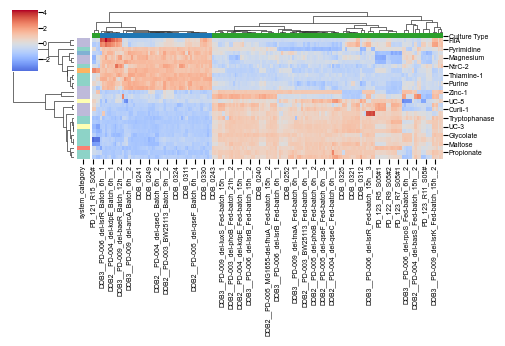

In [171]:
# formatting
plt.rcParams['font.size'] = 5
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5

g = sns.clustermap(
    data = A_filtered,
    figsize=(5, 3.4),
    dendrogram_ratio=0.15,
    cmap="coolwarm",
    center=0,
    z_score=0,
    col_colors=col_colors,
    row_colors=row_colors,
    metric="correlation",
    method="complete"
)

## Metal homeostasis

In [172]:
metal_iM_table = ica_data_p1k_with_ddb.imodulon_table[ica_data_p1k_with_ddb.imodulon_table.functional_category == "Metal Homeostasis"]
metal_iMs = metal_iM_table.index

In [173]:
metal_A_df = ica_data_p1k_with_ddb.A.loc[metal_iMs][hcd_sample_table.index].T
metal_A_df = pd.concat([metal_A_df,hcd_sample_table],axis=1)

In [174]:
metal_A_df["Culture Type"]

DDB2__PD-005_BW25113_Batch_6h__1            Batch
DDB2__PD-005_BW25113_Batch_6h__2            Batch
DDB2__PD-003_BW25113_Batch_9h__1            Batch
DDB2__PD-003_BW25113_Batch_9h__2            Batch
DDB2__PD-003_BW25113_Fed-batch_6h__1    Fed-batch
                                          ...    
PD_123_R11_S05#                         Fed-batch
PD_123_R13_S05#                         Fed-batch
PD_123_R5_S05#1                         Fed-batch
PD_123_R7_S05#1                         Fed-batch
PD_123_R9_S05#1                         Fed-batch
Name: Culture Type, Length: 190, dtype: object

In [175]:
metal_iMs

Index(['Ferric Citrate', 'Zinc-1', 'Nickel', 'Fur-1', 'Fur-2', 'Magnesium',
       'Zinc-2', 'Potassium', 'Molybdenum', 'Copper', 'efeU Activation',
       'Nickel/Cobalt', 'Suf System'],
      dtype='object')

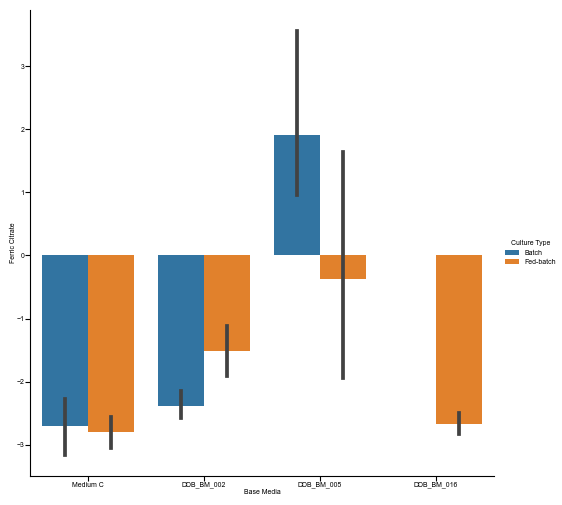

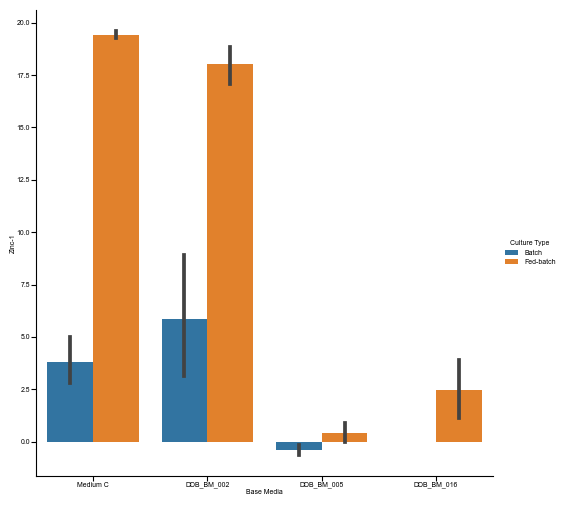

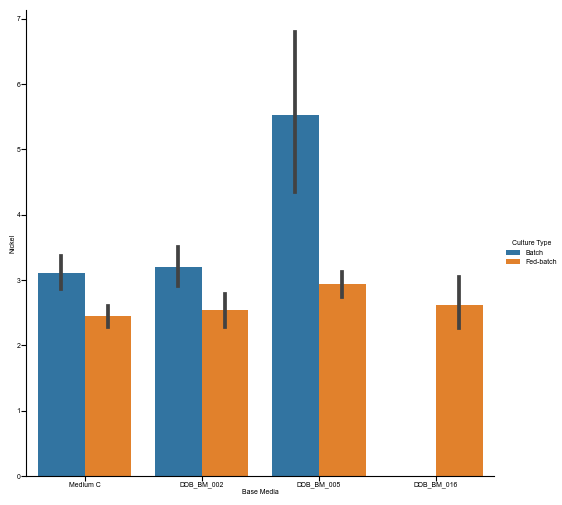

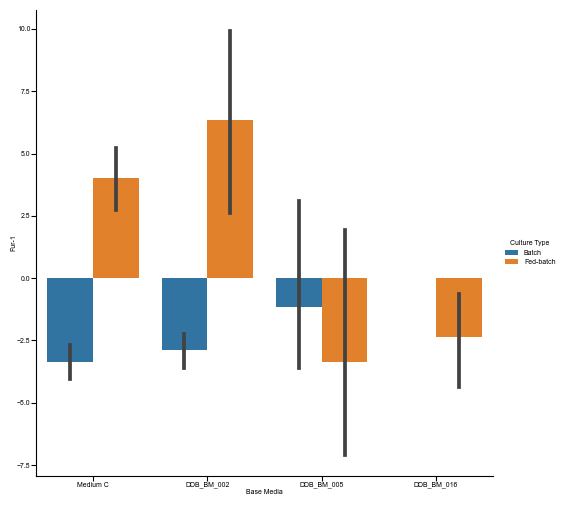

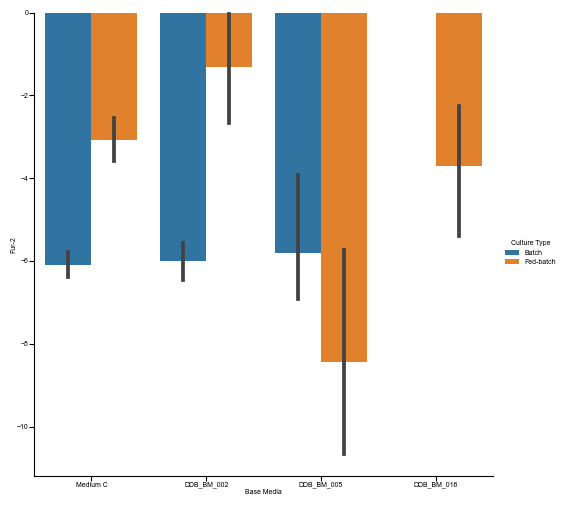

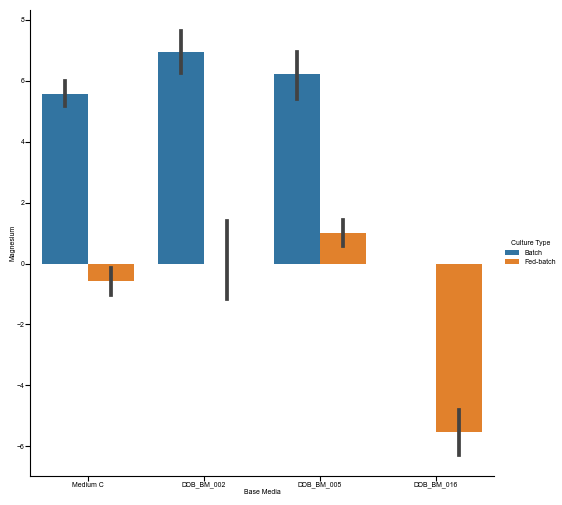

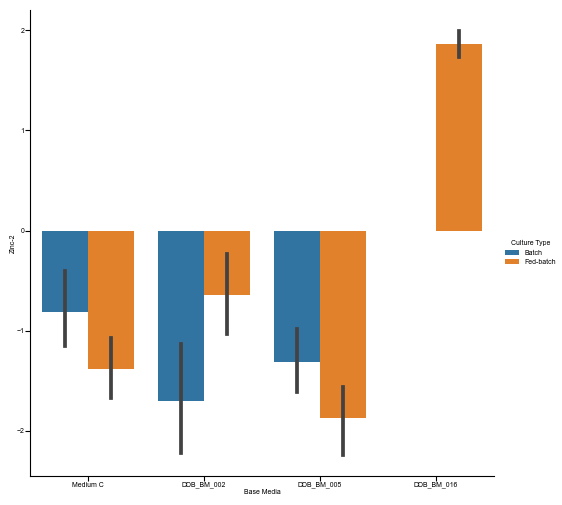

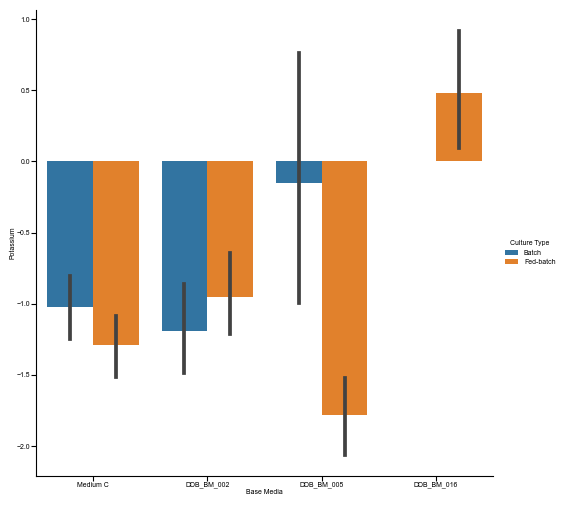

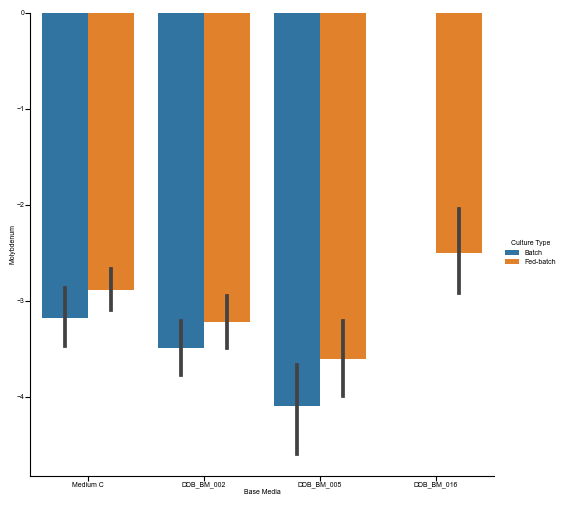

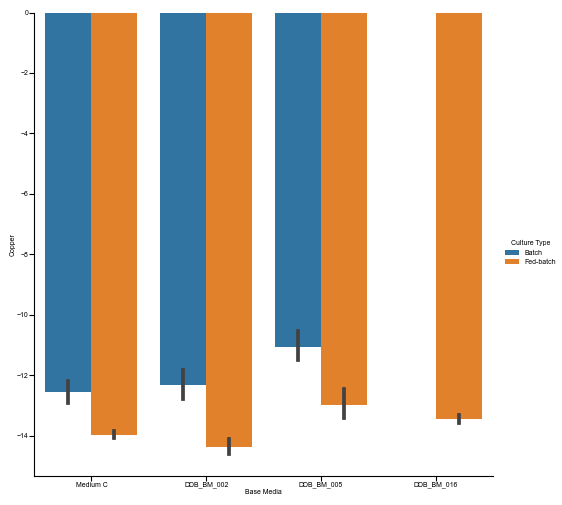

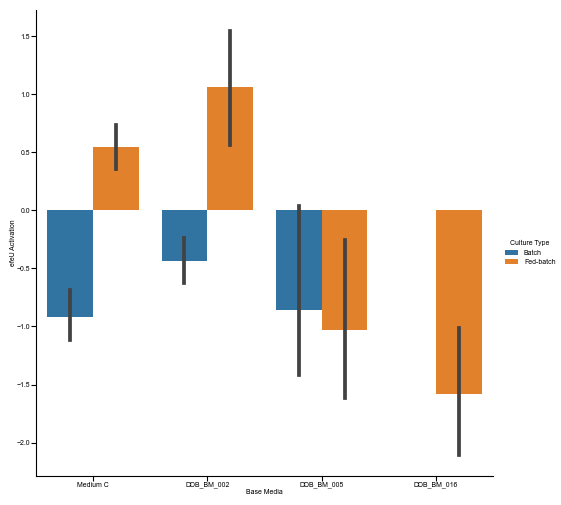

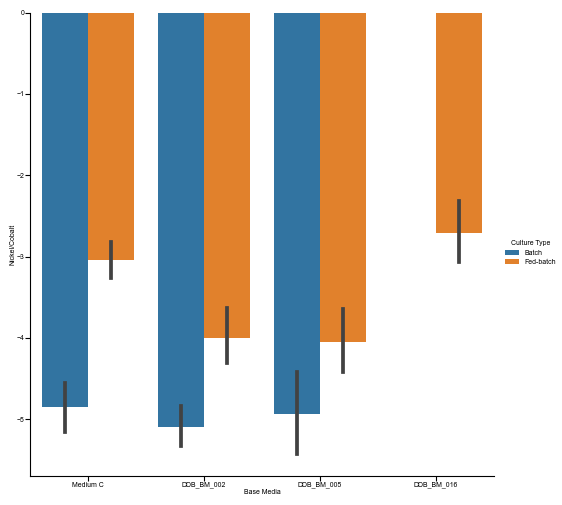

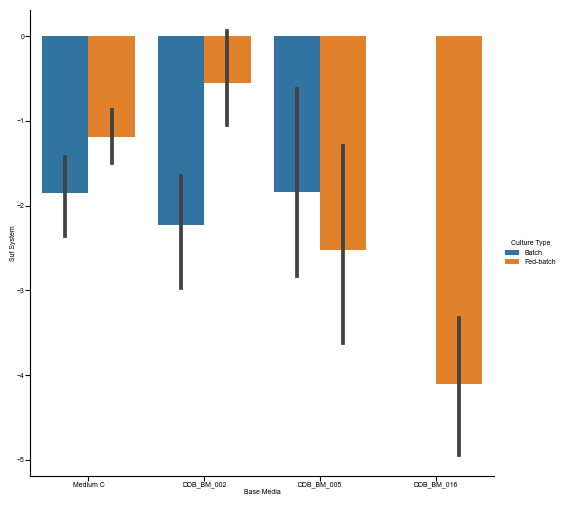

In [176]:
for iM in metal_iMs:
    sns.catplot(
        metal_A_df,
        x="Base Media",
        y=iM,
        hue="Culture Type",
        kind="bar"
    )